## Data Wrangling

### Introduction

This project is part of a Capstone project for Springboard Data Science Career Track.

The goal of this project is to develop a machine learning model to rank and predict the likelihood that an oil company will initiate a frac job in a county within the Permian Basin in the first quarter of 2024.
How can we develop a machine learning model that can accurately forecast at least 
- 8 of the top 10 energy companies by production volume of oil, natural gas, condensate, and casinghead gas in at least 
- 1 out of the 2 top districts in Texas 
- for the first quarter of 2024, using historical production data, well characteristics, and geographic location as inputs.

In [1]:
# Imports
import os
import logging

# Logger setup
logger = logging.getLogger(__name__)

# Clear existing handlers
logger.handlers = []
logger.setLevel(logging.ERROR)

# Create handlers
# c_handler = logging.StreamHandler()
f_handler = logging.FileHandler("CapstoneTwo-DataWrangling.log")
# c_handler.setLevel(logging.ERROR)
f_handler.setLevel(logging.ERROR)

formatter = logging.Formatter("%(asctime)s - %(name)s - %(levelname)s - %(message)s")
# c_handler.setFormatter(formatter)
f_handler.setFormatter(formatter)

# logger.addHandler(c_handler)
logger.addHandler(f_handler)

# Prevent propagation to root logger
logger.propagate = False

In [2]:
# Import statements
from collections import defaultdict
from http.client import IncompleteRead
from time import sleep
import concurrent.futures as cf
from datetime import datetime
import json
import random
import re
import tempfile
import warnings
from functools import lru_cache
from pathlib import Path
from typing import Optional
from urllib.request import urlopen
from urllib.error import URLError
from zipfile import ZipFile

import missingno as msno
import cartopy.crs as ccrs
from shapely import wkt
from shapely.geometry import Point
import geopandas as gpd
import geoviews as gv
import geoviews.tile_sources as gts
import colorcet as cc
import holoviews as hv
from holoviews import opts
import hvplot.pandas  # noqa
import hvplot.dask  # noqa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyproj
from fiona.io import ZipMemoryFile
from pyvis.network import Network
from google.cloud import storage


from tqdm.notebook import tqdm
import dask
from dask import persist
import dask.dataframe as dd

from dask.distributed import Client
import panel as pn
import panel.widgets as pnw
from panel.template import FastListTemplate

hv.extension("bokeh")
gv.extension("bokeh")
pn.extension("tabulator", template="fast", sizing_mode="stretch_width")

In [3]:
# ignore all warnings
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", 40)

In [4]:
# Test initial print statement
print("CapstoneJourney begins!")

CapstoneJourney begins!


Problem Statement

Texas is the largest oil producing state in the United States. It plays a vital role in the energy future of the US. It is therefore vital that energy companies are able to make informed decisions as to where to allocate resources and capital. The goal of this project is to develop a machine learning model to predict the top ten counties in Texas that will have the highest oil and the highest gas production in the first quarter of 2024. The model will use historical Production data from the Texas RRC, well properties data from the FracFocus website, geological features and ecnomic indicators as input. An interactive vizualization tool that will allow users to explore predicted rankings and factors influencing these rankings. The success of this project hinges on the precision of at least 80% of the top 10 predictions. This will provide with a focused and engaging tool for strategic planning and data driven future planning.

How can we develop a machine learning model that can accurately forecast the top ten oil and gas producing counties in Texas for the first quarter of 2024, using historical production data, well characteristics, and geographic location as inputs?

#### Constants
Let's start by defining some constants that will be used throughout this notebook.

Most of the data was first downloaded from external websites and then uploaded onto a cloud storage bucket. This was done to ensure consistency and availability during the project. A brief description of the data and its original source link is referenced below.

### Data Sources

The following table provides an overview of the data sources used in this project:

| Dataset Name | Source URL | Original Source | Description | Date Downloaded |
|--------------|------------|-----------------|-------------|-----------------|
| RegistryUpload Table | [link](https://fracfocus.org/data-download) | FracFocus | This table contains each disclosure’s header information such as the job date, API number, location, base water volume, and total vertical depth. | 2023-11-11 |
| RBDMSWells | [link](https://gisdata-occokc.opendata.arcgis.com/datasets/OCCOKC::rbdms-wells/about) | Oklahoma Corporation Commission | This table contains Oklahoma RBDMS statewide well data | 2023-11-23 |
| Wolfcamp Delaware Play Boundary | [link](https://www.eia.gov/maps/maps.htm)| EIA | Permian Basin, Delaware Sub-Basin: Wolfcamp play boundary (9/4/2018) | 2023-11-19 |
| Wolfcamp Midland Play Boundaries | [link](https://www.eia.gov/maps/maps.htm)| EIA | Wolfcamp A, B, C, and D play boundaries, Midland Basin (6/4/2020) | 2023-11-21 |
| ShalePlay Delaware | [link](https://www.eia.gov/maps/maps.htm)| EIA |Delaware play boundary (10/8/2019)  | 2023-11-21 |
| AboYeso GlorietaYeso Spraberry | [link](https://www.eia.gov/maps/maps.htm)| EIA | Abo-Yeso, Glorieta-Yeso, and Spraberry play boundaries (3/11/2016) | 2023-11-21 |
| Production Data Query Dump| [link](https://rrc.texas.gov/resource-center/research/data-sets-available-for-download/)| Railroad Commission of Texas | Production Data Query Dump (11/17/2023) | 2023-11-17 |
| All Layers By County | [link](https://rrc.texas.gov/resource-center/research/data-sets-available-for-download/)  | Railroad Commission of Texas | Map & Associated Data: Base Map, Wells, Surveys & Pipelines layers | 2023-11-17 |
| Oil & Gas Leases | [link](https://www.glo.texas.gov/land/land-management/gis/index.html) | Texas General Land Office | Active Leases (11/17/2023) | 2023-11-17 |
| Oil & Gas Units | [link](https://www.glo.texas.gov/land/land-management/gis/index.html) | Texas General Land Office | Active Units (11/17/2023) | 2023-11-17 |
| U.S. County Boundaries | [link](https://www2.census.gov/geo/tiger/TIGER2022/COUNTY/tl_2022_us_county.zip) | United States Census Bureau | County (2022-10-31). Data is downloaded directly in the code. | N/A |
| U.S. County FIPS Codes | [link](https://en.wikipedia.org/wiki/List_of_United_States_FIPS_codes_by_county) | Wikipedia | List of United States FIPS codes by county. Data is downloaded directly in the code. | N/A |

Each row in the table represents a different dataset. The columns are:

- **Dataset Name**: The name of the dataset.
- **Source URL**: The URL where the dataset can be downloaded. Click on "link" to access the webpage.
- **Original Source**: The original source of the data.
- **Description**: A brief description of the dataset.
- **Date Downloaded**: The date when the dataset was downloaded.

In [5]:
# Constants
# URLs to retrieve data taken from data sources named above.
# They have been predownloaded and stored in a Google Cloud Storage bucket.


# FracFocus Chemical Disclosure Registry CSV files.
# There are 24 files in total, named FracFocusRegistry_i.csv where i ranges from 1 to 24.

DATA_URLS1 = [
    f"https://storage.googleapis.com/mrprime_dataset/fracfocus/FracFocusRegistry_{i}.csv"
    for i in range(1, 25)
]


# FracFocus registryupload CSV files.
# There are 3 files in total, named registryupload_i.csv where i ranges from 1 to 3.

DATA_URLS2 = [
    f"https://storage.googleapis.com/mrprime_dataset/fracfocus/registryupload_{j}.csv"
    for j in range(1, 4)
]


# FracFocus readme.txt file

DATA_README_URL = [
    "https://storage.googleapis.com/mrprime_dataset/fracfocus/readme.txt"
]


# Oklahoma Corporation Commission well data

OCC_PARQUET_URL = "https://storage.googleapis.com/mrprime_dataset/capstone_journey/occ/rbdms_wells.parquet"


# Energy Information Administration (EIA) shale play geospatial data
# url for the shapefiles of Permian Basin, Delaware Sub-Basin: Wolfcamp play boundary
WOLFCAMP_ZIP_URL = "https://storage.googleapis.com/mrprime_dataset/capstone_journey/eia/Wolfcamp_Delaware_Play_Boundary.zip"
MIDLAND_ZIP_URL = "https://storage.googleapis.com/mrprime_dataset/capstone_journey/eia/Wolfcamp_Midland_Play_Boundaries_EIA.zip"
DELAWARE_ZIP_URL = "https://storage.googleapis.com/mrprime_dataset/capstone_journey/eia/ShalePlay_Delaware_EIA.zip"
ABOYESO_ZIP_URL = "https://storage.googleapis.com/mrprime_dataset/capstone_journey/eia/ShalePlays_AboYeso_GlorietaYeso_Spraberry_EIA.zip"

# group EIA shale play geospatial data urls into a list
basins_url_list = [WOLFCAMP_ZIP_URL, MIDLAND_ZIP_URL,
                   DELAWARE_ZIP_URL, ABOYESO_ZIP_URL]

# Railroad Commission of Texas (RRC) Production Report data query
PDQ_URL = (
    "https://storage.googleapis.com/mrprime_dataset/capstone_journey/rrc/PDQ_DSV.zip"
)

# county numbers for each county fips number in Texas
county_nums = [str(i).zfill(3) for i in range(1, 508) if i % 2]

# RRC statewide map layers shapefiles
SHP_ZIP_URLS = [
    f"https://storage.googleapis.com/mrprime_dataset/capstone_journey/rrc/all_layers_rrc_20231117/Shp{num}.zip"
    for num in county_nums
]
# RRC descriptive information on the oil and gas wells
API_URLS = [
    f"https://storage.googleapis.com/mrprime_dataset/capstone_journey/rrc/statewide_api_rrc_20231205/api{num}.dbf"
    for num in county_nums
]

# Texas General Land Office (GLO) oil and gas lease data
GDB_ZIP_URLS = [
    "https://storage.googleapis.com/mrprime_dataset/capstone_journey/glo/GDB_ActiveLeases.zip",
    "https://storage.googleapis.com/mrprime_dataset/capstone_journey/glo/GDB_ActiveUnits.zip",
]

In [6]:
# Url for the shapefile for US counties from the Census Bureau's website.
CENSUS_COUNTY_MAP_URL = (
    "https://www2.census.gov/geo/tiger/TIGER2022/COUNTY/tl_2022_us_county.zip"
)
# Url for a Wikipedia page containing a table of FIPS codes for US counties.
FIPS_WIKI_URL = (
    "https://en.wikipedia.org/wiki/List_of_United_States_FIPS_codes_by_county"
)
# Bounds of the continental US in longitude and latitude.
USA_BOUNDS = (-124.77, 24.52, -66.95, 49.38)
# bounds of the continental US in Web Mercator coordinates.
USA_BOUNDS_MERCATOR = (-13874905.0, 2870341.0, -7453304.0, 6338219.0)

#### Function definitions
Next, let's define some functions that will be used throughout this notebook.

In [7]:
@lru_cache(maxsize=None)
def get_county_data():
    county = gpd.read_file(CENSUS_COUNTY_MAP_URL)[
        ["GEOID", "STATEFP", "COUNTYFP", "NAME", "geometry"]
    ]
    county.columns = county.columns.str.lower()
    return county

In [8]:
def read_csv_concurrent(urls_list):
    """Reads a list of CSV files concurrently"""
    # Create a thread pool
    with cf.ThreadPoolExecutor() as executor:
        # Use map to apply pd.read_csv to each URL
        results = list(tqdm(executor.map(pd.read_csv, urls_list), total=len(urls_list)))
    # Return the results
    return results

In [9]:
def extract_matching_shp_files_from_zip_urls(
    zip_urls: list[str], regex_patterns: list[str]
) -> dict[str, gpd.GeoDataFrame]:
    """
    Reads shapefiles from a list of zip file urls and returns a dictionary
    where the keys are the names of the shapefiles and the values are GeoDataFrames.
    """
    # Initialize an empty dictionary to store the GeoDataFrames
    shp_dict = {}
    # compile the regex patterns
    patterns = [re.compile(pattern) for pattern in regex_patterns]

    # Loop over the list of zip file urls
    for zip_url in tqdm(zip_urls, desc="Processing zip files"):
        # download the zip file
        with urlopen(zip_url) as u:
            zip_data = u.read()
        # create a ZipMemoryFile from the zip data
        with ZipMemoryFile(zip_data) as z:
            # get the list of files in the zip file
            zip_files = z.listdir()
            # filter for shapefiles that match any of the patterns
            shp_files = [
                f
                for f in zip_files
                for pattern in patterns
                if pattern.search(f) and f.endswith(".shp")
            ]
            # read the shapefiles into GeoDataFrames
            for shp_file in shp_files:
                with z.open(shp_file) as f:
                    shp_dict[Path(shp_file).stem] = gpd.GeoDataFrame.from_features(
                        f, crs=f.crs
                    )
    # Return the dictionary of GeoDataFrames
    return shp_dict

In [10]:
def process_zip_url(
    zip_url: str, patterns: list[re.Pattern]
) -> Optional[dict[str, gpd.GeoDataFrame]]:
    """Downloads a zip file url and returns a dictionary of GeoDataFrames for shapefiles that match the patterns"""

    shp_dict = {}

    retries = 5
    delay = 1

    for i in range(retries):
        try:
            with urlopen(zip_url) as u:
                zip_data = u.read()
            with ZipMemoryFile(zip_data) as z:
                zip_files = z.listdir()

                shp_files = [
                    f
                    for f in zip_files
                    for pattern in patterns
                    if pattern.search(f) and f.endswith(".shp")
                ]

                for shp_file in shp_files:
                    with z.open(shp_file) as f:
                        shp_dict[Path(shp_file).stem] = gpd.GeoDataFrame.from_features(
                            f, crs=f.crs
                        )

            return shp_dict

        except (IncompleteRead, URLError) as e:
            if i < retries - 1:
                sleep(delay)
                delay *= 2
                continue

            else:
                logger.error(
                    f"Error: {e} on try {i+1} of {retries} for {zip_url}")
                raise


def extract_matching_shp_files_from_zip_urls_concurrent(
    zip_urls: list[str], regex_patterns: list[str]
) -> dict[str, gpd.GeoDataFrame]:
    """Reads shapefiles from a list of zip file urls and returns a dictionary where the keys are the names of the shapefiles and the values are GeoDataFrames."""

    shp_dict = {}

    patterns = [re.compile(pattern) for pattern in regex_patterns]

    with cf.ThreadPoolExecutor() as executor:
        future_to_url = {
            executor.submit(process_zip_url, url, patterns): url for url in zip_urls
        }

        futures = tqdm(
            cf.as_completed(future_to_url),
            total=len(future_to_url),
            desc="Processing URLs",
            dynamic_ncols=True,
        )

        for future in futures:
            result = future.result()

            if result:
                shp_dict.update(result)
    return shp_dict

In [11]:
def concat_gdf_from_dict(gdf_dict: dict[str, gpd.GeoDataFrame]) -> gpd.GeoDataFrame:
    """
    Given a dictionary of GeoDataFrames, returns a single GeoDataFrame
    with a new column indicating the source of the data.
    """
    # use a dictionary comprehension to create a new dictionary
    gdf_data = {k: gdf.assign(source_file=k) for k, gdf in gdf_dict.items()}
    # return the concatenated GeoDataFrame
    return pd.concat(gdf_data.values(), ignore_index=True)

In [12]:
def extract_gdfs_from_zip_url(zip_url: str) -> Optional[dict[str, gpd.GeoDataFrame]]:
    """
    Downloads a ZIP file from a URL, reads shapefiles from the ZIP file, and returns a dictionary of GeoDataFrames.
    """
    gdfs = {}
    # Open the URL
    with urlopen(zip_url) as u:
        # Read the content of the response into a byte stream
        zip_data = u.read()
        # Open the ZIP file from the byte stream
        with ZipMemoryFile(zip_data) as z:
            # Get the list of files in the ZIP file
            zip_contents = z.listdir()
            # Find the shapefiles
            shp_files = [f for f in zip_contents if f.endswith(".shp")]
            for shp_file in shp_files:
                # Read the shapefile into a GeoDataFrame
                with z.open(shp_file) as f:
                    gdf = gpd.GeoDataFrame.from_features(f, crs=f.crs)
                gdfs[Path(shp_file).stem] = gdf

    # If no shapefile was found, return None
    return gdfs if gdfs else None

In [13]:
def process_shp_url(zip_url: str):
    """Downloads a zip file url and returns a dictionary of GeoDataFrames for shapefiles that match the patterns"""
    shp_dict = {}
    with urlopen(zip_url) as u:
        zip_data = u.read()
    with ZipMemoryFile(zip_data) as z:
        zip_files = z.listdir()
        shp_files = [f for f in zip_files if f.endswith(".shp")]
        for shp_file in shp_files:
            with z.open(shp_file) as f:
                shp_dict[Path(shp_file).stem] = gpd.GeoDataFrame.from_features(
                    f, crs=f.crs
                )
    return shp_dict


def extract_gdfs_from_zip_url_concurrent(
    zip_urls: list[str],
) -> dict[str, gpd.GeoDataFrame]:
    """Reads shapefiles from a list of zip file urls and returns a dictionary
    where the keys are the names of the shapefiles and the values are GeoDataFrames."""
    shp_dict = {}
    with cf.ThreadPoolExecutor() as executor:
        future_to_url = {executor.submit(process_shp_url, url): url for url in zip_urls}
        futures = tqdm(
            cf.as_completed(future_to_url),
            total=len(future_to_url),
            desc="Processing URLs",
            dynamic_ncols=True,
        )
        for future in futures:
            shp_dict.update(future.result())
    return shp_dict

In [14]:
def read_gdb_from_zip_url(gdb_urls_list: list[str]):
    """Reads a list of zip file urls containing geodatabases and returns a dictionary of GeoDataFrames"""
    # initialize an empty dictionary
    gdb_dict = {}
    # loop through each zip file
    for gdb_url in gdb_urls_list:
        # create a temporary directory
        with tempfile.TemporaryDirectory() as tmp_dir:
            # download the zip file
            with urlopen(gdb_url) as u, open(f"{tmp_dir}/data.zip", "wb") as f_out:
                f_out.write(u.read())
            # extract the zip file
            with ZipFile(f"{tmp_dir}/data.zip", "r") as zip_ref:
                zip_ref.extractall(tmp_dir)
            # get the list of extracted files
            extracted_files = list(Path(tmp_dir).iterdir())
            # filter for gdb folders
            gdb_folders = [f for f in extracted_files if f.suffix == ".gdb"]
            # if there is a gdb folder in the extracted files
            if gdb_folders:
                # get it and read it into a GeoDataFrame
                gdb_folder = gdb_folders[0]
                gdb_dict[Path(gdb_folder).stem] = gpd.read_file(gdb_folder).to_crs(
                    "EPSG:4269"
                )
    # return the dictionary of GeoDataFrames
    return gdb_dict

In [15]:
def process_gdb_url(gdb_url):
    """Downloads a zip file url containing a geodatabase and returns a GeoDataFrame"""
    with tempfile.TemporaryDirectory() as tmp_dir:
        # download the zip file
        with urlopen(gdb_url) as u, open(f"{tmp_dir}/data.zip", "wb") as f_out:
            f_out.write(u.read())
        # extract the zip file
        with ZipFile(f"{tmp_dir}/data.zip", "r") as zip_ref:
            zip_ref.extractall(tmp_dir)
        # get the list of extracted files
        extracted_files = list(Path(tmp_dir).iterdir())
        # filter for gdb folders
        gdb_folders = [f for f in extracted_files if f.suffix == ".gdb"]
        # if there is a gdb folder in the extracted files
        if gdb_folders:
            # get it and read it into a GeoDataFrame
            gdb_folder = gdb_folders[0]
            return Path(gdb_folder).stem, gpd.read_file(gdb_folder)


def read_gdb_from_zip_url_concurrent(gdb_urls_list: list[str]):
    """Reads a list of zip file urls containing geodatabases and returns a dictionary of GeoDataFrames"""
    # initialize an empty dictionary
    gdb_dict = {}
    # create a ThreadPoolExecutor
    with cf.ThreadPoolExecutor() as executor:
        # submit the process_gdb_url function for each url and gather the results
        future_to_url = {
            executor.submit(process_gdb_url, url): url for url in gdb_urls_list
        }
        for future in cf.as_completed(future_to_url):
            url = future_to_url[future]
            try:
                key, data = future.result()
                gdb_dict[key] = data
            except Exception as exc:
                print(f"{url} generated an exception: {exc}")
    # return the dictionary of GeoDataFrames
    return gdb_dict

In [16]:
# Function definitions
def pascal_to_snake(name: str):
    """Converts a string from PascalCase to snake_case"""
    # (?<=[A-Za-z0-9]) - positive lookbehind for any alphanumeric character
    # (?=[A-Z][a-z]) - positive lookahead for any uppercase followed by lowercase
    pattern = re.compile(r"(?<=[A-Za-z0-9])(?=[A-Z][a-z])")
    name = pattern.sub("_", name).lower()
    return name

In [ ]:
# define func to plot hbar of missing columns
def plot_missing_hbars(df, **kwargs):
    """Plots horizontal bars of the missing data in each column of a dataframe"""
    data = df.copy()
    # Calculate the percentage of missing values in each column
    missing_data_percent = (data.notna().mean() * 100).rename("Percent")
    # Create a DataFrame of the counts of missing values
    missing_count = data.notna().sum().rename("Count")
    # Concatenate the two DataFrames along the columns
    missing_data = pd.concat([missing_data_percent, missing_count], axis=1)
    # Create a horizontal bar plot of the percentage of missing data
    hbar_plot = missing_data.hvplot.barh(
        y="Percent",
        width=800,
        height=600,
        ylabel="",
        xlabel="",
        xaxis="bare",
        hover_cols="all",
        **kwargs,
    ).opts(
        active_tools=["box_zoom"],
        toolbar="above",
    )
    return hbar_plot

In [17]:
def plot_nonmissing_hbar(df):
    # Calculate the percentage of non-missing values in each column
    missing_data_percent = (df.notnull().mean()).rename("Percent")

    # Create a DataFrame of the counts of non-missing values
    if isinstance(df, dd.DataFrame):
        non_missing_count, missing_data_percent = dask.compute(
            df.count().rename("Count"), (missing_data_percent * 100)
        )
    else:
        missing_data_percent = missing_data_percent * 100
        non_missing_count = df.notnull().sum().rename("Count")

    # Concatenate the two DataFrames along the columns
    non_missing_data = pd.concat([missing_data_percent, non_missing_count], axis=1)

    # Create a horizontal bar plot of the percentage of non-missing data
    hbar_plot = non_missing_data.hvplot.barh(
        y="Percent",
        width=800,
        height=600,
        title="Percentage of Non-Missing Data in Each Column",
        ylabel="",
        xlabel="",
        xaxis="bare",
        hover_cols="all",
    ).opts(
        active_tools=["box_zoom"],
        toolbar="above",
    )

    return hbar_plot

In [18]:
def unify_crs(
    dataframe: pd.DataFrame,
    lon_col: str = "longitude",
    lat_col: str = "latitude",
    crs_col: str = "crs",
    final_crs: str = "EPSG:4269",
):
    """
    Given a DataFrame with lon/lat or x/y coordinates,
    converts the coordinates to a unified crs and combines
    into a single GeoDataframe with a geometry column.
    """

    # Define the main columns that will be used for the conversion
    main_cols = [lon_col, lat_col, crs_col]

    # Get the other columns in the dataframe
    other_cols = list(set(dataframe.columns) - set(main_cols))

    # Create a subframe with only the main columns
    subframe = dataframe[main_cols]

    # Create a list of GeoDataFrames, each with a different CRS
    geo_dfs = [
        gpd.GeoDataFrame(
            # Use the data for this CRS
            data=data,
            # Create a geometry column from the lon/lat columns
            geometry=gpd.points_from_xy(x=data[lon_col].values, y=data[lat_col].values),
            # Set the CRS for this GeoDataFrame
            crs=pyproj.CRS(crs_val),
            # Convert the GeoDataFrame to the final CRS
        ).to_crs(final_crs)
        # Do this for each unique CRS in the subframe
        for crs_val, data in subframe.groupby(crs_col)
    ]

    # Merge the GeoDataFrames back together and return the result
    return pd.merge(
        # Concatenate the GeoDataFrames
        pd.concat(geo_dfs, sort=True),
        # Add the other columns back in
        dataframe[other_cols],
        # Merge on the index
        left_index=True,
        right_index=True,
    )

In [19]:
# @lru_cache(maxsize=3)
def get_background_map(bgcolor="black", alpha=0.5):
    """Returns a GeoViews background map"""
    return gts.CartoLight().opts(bgcolor=bgcolor, alpha=alpha)


def platecaree_to_mercator_vectorised(x, y):
    """Use Cartopy to convert PlateCarree coordinates to Mercator"""
    return ccrs.GOOGLE_MERCATOR.transform_points(ccrs.PlateCarree(), x, y)[:, :2]

In [20]:
from shapely.geometry import Polygon


def transform_polygon(polygon, src_crs, tgt_crs):
    """Transform the coordinates of a polygon from src_crs to tgt_crs."""
    return Polygon(
        [tgt_crs.transform_point(x, y, src_crs) for x, y in polygon.exterior.coords]
    )


def platecaree_to_mercator_polygons(gdf):
    """Transform the coordinates of all polygons in a GeoDataFrame from PlateCarree to Mercator."""
    src_crs = ccrs.PlateCarree()
    tgt_crs = ccrs.GOOGLE_MERCATOR
    gdf["geometry"] = gdf["geometry"].apply(transform_polygon, args=(src_crs, tgt_crs))
    return gdf

In [21]:
def format_in_000(num):
    """Formats a number in thousands"""
    for unit in ["", "thousand", "million", "billion", "trillion"]:
        if abs(num) < 1000.0:
            return f"{num:3.2f} {unit}"
        num /= 1000.0
    return f"{num:.2f} quadrillion"

In [22]:
def split_datetime(df, column):
    """Splits a datetime column into year, month, and day columns"""
    column_stem = column.replace("_date", "") if "_date" in column else column
    datetime_series = pd.to_datetime(
        df.get(column, pd.Series(dtype="float64")), errors="coerce"
    )
    if datetime_series.isna().any():
        logger.info(f"Some datetime values did not convert in column {column}.")
    df[column_stem + "_year"] = datetime_series.dt.year
    df[column_stem + "_month"] = datetime_series.dt.month
    df[column_stem + "_day"] = datetime_series.dt.day

In [ ]:
def download_blobs_into_memory(bucket_name, prefix):
    """Downloads all blobs with a given prefix from a bucket into memory and reads them into GeoDataFrames."""
    storage_client = storage.Client()
    bucket = storage_client.bucket(bucket_name)

    # Get all blobs in the bucket that match the prefix
    blobs = bucket.list_blobs(prefix=prefix)

    # Create a dictionary to hold the GeoDataFrames
    gdfs = {}

    # Loop over the blobs and read each one into a GeoDataFrame
    for blob in blobs:
        if blob.name.endswith(".dbf"):
            contents = blob.download_as_bytes()  # download as bytes
            gdf = gpd.read_file(contents)  # read into a GeoDataFrame
            gdfs[blob.name] = gdf  # add to the dictionary

    return gdfs

In [23]:
def format_in_B(num):
    """Formats a number in thousands"""
    for unit in ["", "k", "M", "G", "T"]:
        if abs(num) < 1024:
            return f"{num:3.2f} {unit}B"
        num /= 1024
    return f"{num:.1f} TB"


def get_table_overview_from_frame(table_name_dict, table_name):
    """Returns an overview of the data in a dask dataframe"""

    # get the dask dataframe from the dictionary
    ddf = table_name_dict[table_name]
    # get the number of rows and columns
    num_rows = ddf.shape[0]
    # get the size on disk
    size = ddf.memory_usage(deep=True).sum()
    # get the column names
    columns = ddf.columns.tolist()
    # get the column dtypes
    dtypes = ddf.dtypes.to_list()
    # get the number of partitions

    # compute values and put these properties in 1 row of a dataframe
    num_rows, size = dask.compute(num_rows, size)
    # create a dataframe with the properties
    df = pd.DataFrame(
        {
            "table": [table_name],
            "rows": [f"{num_rows:,}"],
            "cols": [len(columns)],
            "columns": [columns],
            "size": [format_in_B(size)],
            "col_dtypes": [dtypes],
        }
    )
    return df


def get_table_description_from_frame(table_name_dict, table_name):
    """Returns a Dask Dataframe with the statistical description of the data in the table"""
    # get the dask dataframe from the dictionary
    ddf = table_name_dict[table_name]
    # compute the descriptive statistics for the numeric columns
    desc_ddf = ddf.describe(include="all")
    # add row with value in each of the columns in the describe dataframe for the dtype
    ddf_dtypes = dd.from_pandas(
        pd.DataFrame(desc_ddf.dtypes.apply(lambda x: x.name), columns=["dtype"]).T,
        npartitions=1,
    )
    # Return the descriptive statistics as a tuple of Dask dataframes
    desc_ddf = dd.concat([desc_ddf, ddf_dtypes])
    return desc_ddf


def get_data_for_plots(ddf):
    """takes in a dask dataframe and returns the df data to be used for plotting"""
    # define order for the columns
    column_order = [
        "dtype",
        "count",
        "unique",
        "top",
        "freq",
        "mean",
        "std",
        "min",
        "25%",
        "50%",
        "75%",
        "max",
    ]
    # get the data for the plots
    computed_ddf = ddf.compute()
    return computed_ddf.T[column_order].sort_values(by="dtype", ascending=False)


def plot_stats_table_hbar(ddf, title=""):
    """Plots a barh plot and a table in a layout."""
    # state opts of barh plot
    hbar_opts = dict(
        title=title,
        ylabel="",
        xlabel="",
        xaxis="bare",
        tools=["hover"],
    )
    df = pd.DataFrame()
    df = get_data_for_plots(ddf)
    # turn the count column into an int dtype column
    df["count"] = pd.to_numeric(df["count"]).astype(int)
    # round the values of the floats to integers
    float_cols = ["mean", "std", "min", "25%", "50%", "75%", "max"]
    for col in float_cols:
        df[col] = pd.to_numeric(df[col].fillna("0.0"), errors="coerce").astype(int)
    # df[float_cols] = df[float_cols].round(0)
    # create a horizontal bartplot of the count column using hvplot
    df["fraction_nonmissing"] = round(df["count"] / df["count"].max(), 4)
    element_height = (1 + df.shape[0]) * 33
    # set the index to the query_field column
    table_panel = pnw.Tabulator(df.iloc[::-1], height=element_height)

    barh_plot = df.hvplot.barh(
        y="fraction_nonmissing", height=element_height, **hbar_opts
    ).opts(active_tools=["box_zoom"], toolbar="above")
    barh_panel = pn.panel(barh_plot)

    # return a panel row with the tabulator table and the bar plot
    return pn.Row(
        barh_panel,
        table_panel,
        sizing_mode="stretch_width",
    )


def display_table_overview_from_frame(
    persisted_overviews, table_name_dict, table_name, nrows=15, column_types={}
):
    """Display an overview of the data in a Dask DataFrame."""
    over_view_table = persisted_overviews[table_name]
    # over_view_table = get_table_overview_from_frame(
    #     table_name_dict, table_name, column_types
    # )

    # display the shape of the table with decorative ~*~ around it
    num_rows = over_view_table["rows"].values[0]
    num_cols = over_view_table["cols"].values[0]
    print(f"~*~ {table_name} ~*~")
    print(f"{num_rows} rows, {num_cols} columns")

    # get ddf from the dictionary
    ddf = table_name_dict[table_name]
    # display nrows of the dask dataframe
    display(ddf.head(nrows))


def get_table_card_from_frame(table_name_dict, table_name):
    """returns a panel card with the table and the bar plot"""
    results = get_table_description_from_frame(table_name_dict, table_name)
    bar_table = plot_stats_table_hbar(results, title=table_name)
    return pn.Card(bar_table, title=table_name)

### Load data

#### 1. FracFocus Dataset
First dataset is from FracFocus. It contains the readme file, which contains the data dictionary for the dataset, and the 3 data files in csv format.

In [25]:
logger.info("First dataset request for FracFocus data")

# get readme data
readme = urlopen(DATA_README_URL[0]).read().decode("windows-1252")

# We can collect all the dataframe into a list and then concatenate them
df_list = read_csv_concurrent(DATA_URLS2)
dfs = pd.concat(df_list).reset_index(drop=True)

logger.info("First dataset request for FracFocus data complete")


print(readme)
print()
registry_df = pd.DataFrame()
registry_df = dfs.copy()
registry_df.info(memory_usage="deep")

  0%|          | 0/3 [00:00<?, ?it/s]

FRACFOCUS DATA DICTIONARY - Last updated: July 19th, 2017
--------------------------------------------------------
This data dictionary defines each attribute found in the FracFocusRegistry database backup which includes all disclosures 
locatable through the FracFocus ‘Find a Well’ search.


Table Name: RegistryUpload
--------------------------
pKey - Key index for the table

JobStartDate - The date on which the hydraulic fracturing job was initiated.  Does not include site preparation or setup.

JobEndDate - The date on which the hydraulic fracturing job was completed.  Does not include site teardown.

APINumber - The American Petroleum Institute well identification number formatted as follows xx-xxx-xxxxx0000 Where: First two digits 
represent the state, second three digits represent the county, third 5 digits represent the well.

StateNumber - The first two digits of the API number.  Range is from 01-50.

CountyNumber - The 3 digit county code.

OperatorName - The name of the opera

#### 2. US Census bureau and Wikipedia
Next dataset to load is the fips geodataframe dataset. This dataset contains the county boundaries for the United States. This geo data can be reliably used as a reference for spatial boundaries.

In [26]:
logger.info("Second dataset request for county data")

# get the US counties map data and the FIPS codes data


county_gdf = get_county_data()
fips_df = pd.read_html(FIPS_WIKI_URL)[1]
fips_df.columns = ["geoid", "county", "state"]
fips_df["geoid"] = fips_df["geoid"].astype("string").str.zfill(5)
county_fips_gdf = county_gdf.merge(fips_df, on="geoid")
county_fips_gdf.sample(3)


logger.info("Second dataset request for county data complete")
county_gdf.info(memory_usage="deep")
county_gdf.sample(3)

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 3235 entries, 0 to 3234
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   geoid     3235 non-null   object  
 1   statefp   3235 non-null   object  
 2   countyfp  3235 non-null   object  
 3   name      3235 non-null   object  
 4   geometry  3235 non-null   geometry
dtypes: geometry(1), object(4)
memory usage: 800.0 KB


,geoid,statefp,countyfp,name,geometry
1396,09150,09,150,Northeastern Connecticut,"POLYGON ((-72.23479 41.95780, -72.23445 41.958..."
1529,41027,41,027,Hood River,"POLYGON ((-121.48175 45.50505, -121.48174 45.5..."
1738,27113,27,113,Pennington,"POLYGON ((-95.59303 48.10761, -95.59302 48.106..."


#### 3. Oklahoma Corporation Commission
This dataset is from the Oklahoma Corporation Commission. It contains the oil and gas well locations within the state of Oklahoma. It was converted to parquet format for faster loading

In [27]:
logger.info("Third dataset request for Oklahoma shapefiles")
# Read in OK well data


occ_wells = pd.read_parquet(OCC_PARQUET_URL)
logger.info("Third dataset request for Oklahoma shapefiles complete")
# Convert the WKT column back to a geometry column
occ_wells["geometry"] = occ_wells["geometry"].apply(lambda x: wkt.loads(x))
# Convert the DataFrame to a GeoDataFrame, specifying the CRS
occ_wells = gpd.GeoDataFrame(
    occ_wells, geometry="geometry", crs=occ_wells["crs"].iloc[0]
)
occ_wells.info(memory_usage="deep")
# look at sample rows of the dataframe
occ_wells.sample(3)

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 445575 entries, 0 to 445574
Data columns (total 27 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   objectid           445575 non-null  int64   
 1   api                445575 non-null  float64 
 2   well_browse_link   445575 non-null  object  
 3   well_records_docs  445575 non-null  object  
 4   well_name          445568 non-null  object  
 5   well_num           445570 non-null  object  
 6   operator           445575 non-null  object  
 7   wellstatus         443813 non-null  object  
 8   welltype           365021 non-null  object  
 9   symbol_class       445575 non-null  object  
 10  sh_lat             437073 non-null  float64 
 11  sh_lon             437073 non-null  float64 
 12  county             445575 non-null  object  
 13  section            445454 non-null  float64 
 14  township           445450 non-null  object  
 15  range              445575 

,objectid,api,well_browse_link,well_records_docs,well_name,well_num,operator,wellstatus,welltype,symbol_class,sh_lat,sh_lon,county,section,township,range,qtr4,qtr3,qtr2,qtr1,pm,footage_ew,ew,footage_ns,ns,geometry,crs
92106,92107,3.503728e+09,http://wellbrowse.occ.ok.gov/Webforms/WellInfo...,https://public.occ.ok.gov/OGCDWebLink/Search.a...,EAST KELLYVILLE DUTCHER UNIT,#9,MIDNIGHT ENERGY OPERATING LLC,AC,OIL,OIL,35.948124,-96.203213,CREEK,13.0,17N,10E,NE,NW,SE,SW,IM,1780.0,W,1240.0,S,POINT (-96.20321 35.94812),EPSG:4326
411248,411249,3.514324e+09,http://wellbrowse.occ.ok.gov/Webforms/WellInfo...,https://public.occ.ok.gov/OGCDWebLink/Search.a...,BAGGETT,#2-33,SBOC LLC,AC,GAS,GAS,36.087390,-96.144720,TULSA,33.0,19N,11E,S2,SW,NW,NE,IM,330.0,W,1603.0,S,POINT (-96.14472 36.08739),EPSG:4326
20398,20399,3.501521e+09,http://wellbrowse.occ.ok.gov/Webforms/WellInfo...,https://public.occ.ok.gov/OGCDWebLink/Search.a...,R V GARRETT,#1-21,OTC/OCC NOT ASSIGNED,PA,None,PLUGGED,35.419885,-98.480626,CADDO,21.0,11N,12W,None,None,NW,NW,IM,560.0,W,660.0,N,POINT (-98.48063 35.41989),EPSG:4326


#### 4. Railroad Commission of Texas
Next few datasets are from the Texas Railroad Commission (RRC). First we have a zip file of all the map layers shape files. There is one for each county, so that is 254 in total in TX. The shapefiles contain various data ranging from point geometry well locations to survey data polygon area. We will use the land survey data, bottom well data, and surface well data which are each in separate shapefiles within the zip.

In [28]:
# regex patterns to identify which shapefiles to extract
# we are grabbing the survey lines, surface wells, and bottom well locations shp files
patterns = [r"surv\d{3}p", r"well\d{3}s", r"well\d{3}b"]

# Look at the survey lines polygons and the surface wells points. Data saved from RRC website
shp_dict = extract_matching_shp_files_from_zip_urls_concurrent(SHP_ZIP_URLS, patterns)

# use the patterns to separate the gdf in the dict based on the pattern
surv_dict = {k: shp_dict[k] for k, v in shp_dict.items() if re.search(patterns[0], k)}
swell_dict = {k: shp_dict[k] for k, v in shp_dict.items() if re.search(patterns[1], k)}
bwell_dict = {k: shp_dict[k] for k, v in shp_dict.items() if re.search(patterns[2], k)}

# concatenate the gdf from the dict
surv_gdf = concat_gdf_from_dict(surv_dict)
swell_gdf = concat_gdf_from_dict(swell_dict)
bwell_gdf = concat_gdf_from_dict(bwell_dict)

# show a sample of the data
surv_gdf.info(memory_usage="deep")
display(surv_gdf.sample(3))
swell_gdf.info(memory_usage="deep")
display(swell_gdf.sample(3))
bwell_gdf.info(memory_usage="deep")
display(bwell_gdf.sample(3))

Processing URLs:   0%|          | 0/254 [00:00<?, ?it/s]

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 311248 entries, 0 to 311247
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype   
---  ------       --------------   -----   
 0   geometry     311248 non-null  geometry
 1   ABSTRACT_N   311127 non-null  object  
 2   LEVEL1_SUR   310857 non-null  object  
 3   LEVEL2_BLO   139664 non-null  object  
 4   LEVEL3_SUR   221353 non-null  object  
 5   LEVEL4_SUR   108712 non-null  object  
 6   ABSTRACT_L   311240 non-null  object  
 7   SCRAP_FILE   9271 non-null    object  
 8   source_file  311248 non-null  object  
dtypes: geometry(1), object(8)
memory usage: 124.3 MB


,geometry,ABSTRACT_N,LEVEL1_SUR,LEVEL2_BLO,LEVEL3_SUR,LEVEL4_SUR,ABSTRACT_L,SCRAP_FILE,source_file
234129,"POLYGON ((-101.63311 31.34458, -101.63332 31.3...",383168,GC&SF RR CO,None,1205,None,A-168,None,surv383p
239708,"POLYGON ((-102.87600 30.73074, -102.87603 30.7...",3713482,T&STL RR CO,133,1,None,A-3482,None,surv371p
246957,"POLYGON ((-101.69606 36.32728, -101.69622 36.3...",4211052,GH&H RR CO,1C,34,"SNYDER, J JR",A-1052,None,surv421p


<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1359173 entries, 0 to 1359172
Data columns (total 11 columns):
 #   Column       Non-Null Count    Dtype   
---  ------       --------------    -----   
 0   geometry     1359173 non-null  geometry
 1   SURFACE_ID   1359173 non-null  int64   
 2   SYMNUM       1359173 non-null  int64   
 3   API          1359173 non-null  object  
 4   RELIAB       1359173 non-null  object  
 5   LONG27       1359173 non-null  float64 
 6   LAT27        1359173 non-null  float64 
 7   LONG83       1359173 non-null  float64 
 8   LAT83        1359173 non-null  float64 
 9   WELLID       994978 non-null   object  
 10  source_file  1359173 non-null  object  
dtypes: float64(4), geometry(1), int64(2), object(4)
memory usage: 383.0 MB


,geometry,SURFACE_ID,SYMNUM,API,RELIAB,LONG27,LAT27,LONG83,LAT83,WELLID,source_file
584553,POINT (-98.89563 26.92727),12483,4,247,15,-98.895632,26.927267,-98.895939,26.927590,None,well247s
1121126,POINT (-103.29013 31.25820),1315892,86,38935068,55,-103.290133,31.258197,-103.290579,31.258337,35068,well389s
880097,POINT (-102.04642 31.86758),413225,6,32931465,15,-102.046425,31.867581,-102.046838,31.867709,31465,well329s


<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1375390 entries, 0 to 1375389
Data columns (total 18 columns):
 #   Column       Non-Null Count    Dtype   
---  ------       --------------    -----   
 0   geometry     1375390 non-null  geometry
 1   BOTTOM_ID    1375390 non-null  int64   
 2   SURFACE_ID   1375390 non-null  int64   
 3   SYMNUM       1375390 non-null  int64   
 4   APINUM       1375390 non-null  object  
 5   RELIAB       1375390 non-null  object  
 6   API10        1375390 non-null  object  
 7   API          1375390 non-null  object  
 8   LONG27       1375390 non-null  float64 
 9   LAT27        1375390 non-null  float64 
 10  LONG83       1375390 non-null  float64 
 11  LAT83        1375390 non-null  float64 
 12  OUT_FIPS     1375311 non-null  object  
 13  CWELLNUM     1342491 non-null  object  
 14  RADIOACT     66484 non-null    object  
 15  WELLID       1011289 non-null  object  
 16  STCODE       169650 non-null   object  
 17  source_file  137539

,geometry,BOTTOM_ID,SURFACE_ID,SYMNUM,APINUM,RELIAB,API10,API,LONG27,LAT27,LONG83,LAT83,OUT_FIPS,CWELLNUM,RADIOACT,WELLID,STCODE,source_file
184741,POINT (-100.71374 32.03497),489410,489410,7,42081,15,081,081,-100.713745,32.034970,-100.714129,32.035104,N,7WIW,None,None,None,well081b
187785,POINT (-100.82268 31.76971),338283,338283,3,42081,15,081,081,-100.822683,31.769712,-100.823068,31.769856,N,1,None,None,None,well081b
771868,POINT (-101.11120 32.29662),1052317,1052317,7,4233534097,40,33534097,33534097,-101.111198,32.296616,-101.111607,32.296759,N,42,None,34097,None,well335b


Also from the RRC is the Statewide API dataset. These files contain descriptive information about oil and gas wells which are maintained by RRC mapping system. These files are organized by map area and contains API number, survey name, well number, plug date, completion date, lease name, and lease I.D. The file is organized by USGS 7.5 minute quadrangle and is sorted by API number within each quadrangle. It is intended to be used along with location information extracted from the well mapping system. Records contained in these files will match the API numbers identified in the quad maps, but may not represent all known API numbers in the map area. They have been unzipped from the original zipfile so are now in `.dbs` format.

In [29]:
def load_dbf(url):
    try:
        dbf = gpd.read_file(url)
        return dbf
    except Exception as e:
        logger.error(f"Failed to read data from {url}: {e}")
        return None



# Create a ThreadPoolExecutor
with cf.ThreadPoolExecutor() as executor:
    # Use the executor to map the load_dbf function to the URLs
    futures = [executor.submit(load_dbf, url) for url in API_URLS]

    # Initialize an empty list to hold the GeoDataFrames
    dbfs = []

    # loop over the futures as they complete
    for future in tqdm(cf.as_completed(futures), total=len(API_URLS)):
        # Get the result from the future
        dbf = future.result()

        # If the result is not None, add it to the list
        if dbf is not None:
            dbfs.append(dbf)

logger.info("Finished request for RRC API data")

# Concatenate the GeoDataFrames into a single DataFrame
api_df = pd.concat(dbfs).reset_index(drop=True)

logger.info("Successfully concatenated the data into a single DataFrame")

# show sample of the dataframe
api_df.info(memory_usage="deep")
api_df.sample(3)

  0%|          | 0/254 [00:00<?, ?it/s]

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1527310 entries, 0 to 1527309
Data columns (total 20 columns):
 #   Column      Non-Null Count    Dtype   
---  ------      --------------    -----   
 0   ABSTRACT    735654 non-null   object  
 1   APINUM      1527310 non-null  object  
 2   BLOCK       474543 non-null   object  
 3   COMPLETION  1527310 non-null  object  
 4   FIELD_NAME  1161126 non-null  object  
 5   LEASE_NAME  1328034 non-null  object  
 6   GAS_RRCID   1527310 non-null  object  
 7   OIL_GAS_CO  1093662 non-null  object  
 8   ON_OFF_SCH  1093662 non-null  object  
 9   OPERATOR    1357758 non-null  object  
 10  PERMIT_NUM  1527309 non-null  object  
 11  PLUG_DATE   1527310 non-null  object  
 12  REFER_TO_A  1527310 non-null  object  
 13  SECTION     565818 non-null   object  
 14  SURVEY      1080545 non-null  object  
 15  TOTAL_DEPT  1527310 non-null  object  
 16  WELLID      1374848 non-null  object  
 17  QUADNUM     1330321 non-null  object  

,ABSTRACT,APINUM,BLOCK,COMPLETION,FIELD_NAME,LEASE_NAME,GAS_RRCID,OIL_GAS_CO,ON_OFF_SCH,OPERATOR,PERMIT_NUM,PLUG_DATE,REFER_TO_A,SECTION,SURVEY,TOTAL_DEPT,WELLID,QUADNUM,OBJECTID_1,geometry
1217551,None,43531105,None,0,None,None,000000,None,None,None,000000,19751229,00000000,None,None,7934,7,3000321,875046,None
172587,None,08930299,None,19740028,BORDEN-HAMILL(WILCOX 9770),BLOECHER-WICK UNIT,057729,G,Y,"HAMILL, CLAUD B.",000000,0,00000000,None,None,10570,1,2996313,937973,None
740644,None,28531449,None,0,None,"HANCOCK ""H""",000000,None,None,TEXAS OIL & GAS CORP.,063934,0,00000000,None,"F. C. PITZER SUR. 6, A-708",0,2,None,0,None


Finally, from the RRC is the Production Data Query Dump. This is a complete dump of the Production Data and Historical Ledger databases and includes production from 1993 to current. We have unzipped and converted to `parquet` format.  Parquet is a particular good format for use with `Dask` because it is a columnar storage file format that is optimized to use with big data processing frameworks. Some of these data tables are very large to load into memory so we will leverage the `dask` partitioning capability to be able to read and anlyze the data in chunks. There are 16 data tables in the query dump.




##### Production Data Query Dump from RRC

| Table | Description|
|---|---|
|GP_COUNTY | General purpose table that stores county information.|
|GP_DATE_RANGE_CYCLE | General purpose table of PDQ data range ( Jan. 1993-current production report month/year). |
|GP_DISTRICT | General purpose table that contains district information. |
|OG_COUNTY_CYCLE | Contains production report data reported by lease and month (YYYYMM) aggregated by the county in which the wells are located.  |This is an estimate only based on allowables and potentials.
|OG_COUNTY_LEASE_CYCLE | Contains production report data reported by lease and month (YYYYMM) aggregated by lease and county in which the wells  |are located. This is an estimate only based on allowables and potentials.
|OG_DISTRICT_CYCLE | Contains production report data reported by lease and month (YYYYMM) aggregated by the completion district for the lease ID. |
|OG_FIELD_CYCLE | Contains production report data reported by lease and month (YYYYMM) aggregated by the field in which the well(s) for the lease  |are completed.
|OG_FIELD_DW | Table of field identifying data. |
|OG_LEASE_CYCLE | Contains production report data reported by lease and month (YYYYMM). |
|OG_LEASE_CYCLE_DISP | Contains production report disposition data reported by lease and month (YYYYMM). |
|OG_OPERATOR_CYCLE | Contains production report data reported by lease and month (YYYYMM) aggregated by the operator of the lease. |
|OG_OPERATOR_DW | This table contains identifying operator information. |
|OG_REGULATORY_LEASE_DW | This table contains identifying lease information. |
|OG_SUMMARY_MASTER_LARGE | Summary table. (Used for query purposes at the operator level) |
|OG_SUMMARY_ONSHORE_LEASE | Summary table. (Used for query purposes on the leases in onshore counties) |
|OG_WELL_COMPLETION | This table contains identifying well completion information. |

##### Dask Client

In [30]:
# Create a Dask client with specified configuration
# This client will use 4 workers, each with 1 thread and a memory limit of 3GB
# The Dask diagnostic dashboard will be served at the address ":8788"
client = Client(
    n_workers=6, threads_per_worker=2, memory_limit="3GB", dashboard_address=":8788"
)

# Print the link to the Dask diagnostic dashboard
# This link can be used to monitor the progress and performance of Dask computations
print(client.dashboard_link)

http://127.0.0.1:8788/status


Read in the data as parquet files from GCS. We were able to bring in the data without loading it on to disk.

In [31]:
# Create a client
storage_client = storage.Client()

# Define the bucket name and the prefix
bucket_name = "mrprime_dataset"
prefix = "capstone_journey/rrc/processed/"

# Get the bucket
bucket = storage_client.get_bucket(bucket_name)

# Get the blobs (files) in the bucket that match the prefix
blobs = bucket.list_blobs(prefix=prefix)

# Get the URLs of the data tables
data_tables = set(
    blob.name.rsplit("/", 2)[1] for blob in blobs if "_DATA_TABLE.parquet" in blob.name
)

# Load each data table into a separate DataFrame
dfs = {
    data_table: dd.read_parquet(
        f"gs://{bucket_name}/{prefix}{data_table}/*.parquet", engine="pyarrow"
    )
    for data_table in tqdm(data_tables)
}
dfs = {k.split(".")[0]: v for k, v in dfs.items()}

data_table_list = list(dfs.keys())
short_table = [k.replace("_DATA_TABLE", "").lower() for k in data_table_list]

table_zip = zip(short_table, data_table_list)


# Make the short table names the keys with dfs dict values
data_tables_dict = {k: dfs[v] for k, v in table_zip}
print("Keys for data_table_dict:")
list(data_tables_dict.keys())

  0%|          | 0/16 [00:00<?, ?it/s]

Keys for data_table_dict:


['gp_county',
 'gp_date_range_cycle',
 'og_county_cycle',
 'og_field_cycle',
 'og_lease_cycle_disp',
 'og_well_completion',
 'og_field_dw',
 'og_district_cycle',
 'og_lease_cycle',
 'og_regulatory_lease_dw',
 'og_summary_master_large',
 'gp_district',
 'og_county_lease_cycle',
 'og_operator_dw',
 'og_summary_onshore_lease',
 'og_operator_cycle']

We only initiate the `Client` and load in the dask dataframes in a dict for now. We will compute the dataframes later when we need to use them.

#### 5. Texas General Land Office
Next dataset is from the Texas General Land Office (GLO). These files contained both the Oil and Gas Leases (active only), managed by the Texas GLO, and Oil & Gas units (active only) which is Oil and Gas pooling agreements managed by the Texas GLO. They are in `gdb` format.

In [32]:
# get the geodataframe of the active leases


active_gdb_dict = read_gdb_from_zip_url_concurrent(GDB_ZIP_URLS)

logger.info("Dataset request for GLO gdb files complete")

for k, gdf in active_gdb_dict.items():
    print(f"{k}| Shape:{gdf.shape}| CRS:{gdf.crs.to_string()}")
    # gdf.info(memory_usage="deep")
    # display(gdf.sample(3))
    print()

active_units_gdf = active_gdb_dict["OAG_Units_Active"]
active_units_gdf.info(memory_usage="deep")
display(active_units_gdf.sample(3))
active_leases_gdf = active_gdb_dict["OAG_Leases_Active"]
active_leases_gdf.info(memory_usage="deep")
display(active_leases_gdf.sample(3))

OAG_Units_Active| Shape:(7383, 38)| CRS:EPSG:3857

OAG_Leases_Active| Shape:(7106, 43)| CRS:EPSG:3857

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 7383 entries, 0 to 7382
Data columns (total 38 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   VIEWID                    7371 non-null   float64 
 1   LEASE_NUMBER              7371 non-null   object  
 2   LEASE_STATUS              7371 non-null   object  
 3   LEASE_STATUS_DATE         7371 non-null   object  
 4   CURRENT_NET_ACRES         2180 non-null   float64 
 5   EFFECTIVE_DATE            7326 non-null   object  
 6   PRIMARY_TERM_END_DATE     108 non-null    object  
 7   LEASE_TYPE                7371 non-null   object  
 8   PRIMARY_TERM_YEAR         7371 non-null   object  
 9   ORIGINAL_LESSEE           0 non-null      object  
 10  LESSOR                    0 non-null      object  
 11  FIELD_NAME                5564 non-null   object 

,VIEWID,LEASE_NUMBER,LEASE_STATUS,LEASE_STATUS_DATE,CURRENT_NET_ACRES,EFFECTIVE_DATE,PRIMARY_TERM_END_DATE,LEASE_TYPE,PRIMARY_TERM_YEAR,ORIGINAL_LESSEE,LESSOR,FIELD_NAME,ALL_DEPTHS,DEPTH_FROM,DEPTH_TO,DEP_FROM_FORMATION,DEP_TO_FORMATION,DEPTH_LAND_PART,DEPTH_FROM_TEXT,DEPTH_TO_TEXT,UNIT_NAME,UNIT_EFFECTIVE_DATE,UNIT_EXPIRATION_DATE,UNIT_TOTAL_ACRES,UNIT_STATE_ACRES,UNIT_MINERAL_POOLED,UNIT_TYPE,UNIT_STATE_PARTICIPATION,UNIT_DEPTH_FROM_WELL,UNIT_DEPTH_TO_WELL,APPLICATION_BONUS,LEASE_UPDATE,LEASE_INPUT,LAND_TYPE,COUNTY,Shape_Length,Shape_Area,geometry
5939,105386945.0,7634,Producing,12/01/2016,NaN,12/01/2016,12/01/2016,Unit,"0 years, 0 months, 0 days",None,None,BRISCOE RANCH (EAGLEFORD),Specified Depths,None,None,None,None,None,surface,100 feet below the deepest depth drilled,McFaddin Unit 2 DIM,12/01/2016,12/01/2016,217.67,1.82,Oil And Gas,Standard,0.008361,None,None,None,Mar 1 2017 1:55PM,Aug 13 2015 12:22PM,01,Dimmit,5620.439213,1.084931e+06,"MULTIPOLYGON (((-11080237.905 3307352.204, -11..."
2842,105395330.0,13005,Producing,08/01/2023,NaN,06/03/2023,None,Unit,"0 years, 0 months, 0 days",None,None,EAGLEVILLE (EAGLE FORD-1),Allow All Depths,None,None,None,None,None,None,None,Phoenix Unit A #1H (alloc),06/03/2023,None,0.00,0.00,Oil And Gas,iNut,0.000317,None,None,None,None,Oct 3 2023 9:06AM,65,Gonzales,8481.902876,2.202304e+05,"MULTIPOLYGON (((-10823966.191 3424743.514, -10..."
6453,105387764.0,8103,Producing,08/02/2016,NaN,03/20/2013,None,Unit,"0 years, 0 months, 0 days",None,None,EAGLEVILLE (EAGLE FORD-2),Specified Depths,10294.000000,10580.000000,Eagle Ford,Eagle Ford,None,None,None,Patton Horizontal Unit,None,None,637.84,11.20,Oil And Gas,Standard,0.017559,Correlative Well,Correlative Well,None,Aug 31 2016 9:46AM,Aug 2 2016 10:29AM,56 ; 65,Karnes,8235.942458,3.503514e+06,"MULTIPOLYGON (((-10886286.906 3389983.933, -10..."


<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 7106 entries, 0 to 7105
Data columns (total 43 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   VIEWID                 7073 non-null   float64 
 1   LEASE_NUMBER           7073 non-null   object  
 2   LEASE_STATUS           7073 non-null   object  
 3   LEASE_STATUS_DATE      7065 non-null   object  
 4   EFFECTIVE_DATE         7073 non-null   object  
 5   PRIMARY_TERM_END_DATE  6529 non-null   object  
 6   BONUS_AMOUNT           6912 non-null   float64 
 7   ORIGINAL_GROSS_ACRES   7035 non-null   float64 
 8   ORIGINAL_NET_ACRES     4480 non-null   float64 
 9   CURRENT_GROSS_ACRES    3955 non-null   float64 
 10  CURRENT_NET_ACRES      6486 non-null   float64 
 11  LEASE_TYPE             6795 non-null   object  
 12  BONUS_AMOUNT_PER_ACRE  6567 non-null   float64 
 13  PRIMARY_TERM_YEAR      7073 non-null   object  
 14  ORIGINAL_LESSEE        6567 non-

,VIEWID,LEASE_NUMBER,LEASE_STATUS,LEASE_STATUS_DATE,EFFECTIVE_DATE,PRIMARY_TERM_END_DATE,BONUS_AMOUNT,ORIGINAL_GROSS_ACRES,ORIGINAL_NET_ACRES,CURRENT_GROSS_ACRES,CURRENT_NET_ACRES,LEASE_TYPE,BONUS_AMOUNT_PER_ACRE,PRIMARY_TERM_YEAR,ORIGINAL_LESSEE,LESSOR,FIELD_NAME,UNDIVIDED_INTEREST,UNITIZED,ALL_DEPTHS,...,DEP_TO_FORMATION,DEPTH_LAND_PART,DEPTH_FROM_TEXT,DEPTH_TO_TEXT,LEASE_ROYALTY_GAS,LEASE_ROYALTY_OIL,LEASE_ROYALTY_SULPHUR,APPLICATION_BONUS,FIRST_WELL_CLASS,FIRST_WELL_GAS,FIRST_WELL_OIL,FIRST_WELL_UNIT,FIRST_WELL_HARDMIN,LEASE_UPDATE,LEASE_INPUT,LAND_TYPE,COUNTY,Shape_Length,Shape_Area,geometry
5528,105388760.0,MF118662,Unitized,11/06/2012,11/06/2012,None,0.00,1.750,1.750,1.340,1.340,32.207 56 [State Unleased HROW],0.0,"0 years, 0 months, 0 days",None,None,None,No,Yes,Specified Depths,...,Eagle Ford Shale,None,None,None,0.25000000,0.25000000,0.25000000,None,First Production Dat,None,None,None,None,None,May 26 2017 10:19AM,56,Karnes,1192.660908,12318.773946,"MULTIPOLYGON (((-10879745.557 3365217.462, -10..."
2888,105379958.0,MF111795,Producing,11/16/2010,11/16/2010,11/16/2011,5599.00,5.599,5.599,5.599,5.599,HROW 65 [County],0.0,"1 years, 0 months, 0 days",Geosouthern Energy,State of Texas (GLO),None,No,Yes,None,...,None,None,None,None,0.25000000,0.25000000,0.25000000,5599.000000,None,None,None,None,None,Aug 12 2013 12:47PM,Dec 6 2010 9:55AM,65,DeWitt,6627.735545,103278.826063,"MULTIPOLYGON (((-10849866.333 3395985.901, -10..."
5221,105387424.0,MF117921,Producing,12/24/2014,12/24/2014,12/24/2016,1201.05,1.413,1.413,1.413,1.413,32.207 65 [County Unleased HROW],850.0,"2 years, 0 months, 0 days","CLAYTON WILLIAMS ENERGY, INC.",None,GIDDINGS (EAGLEFORD),No,Yes,Specified Depths,...,Buda,None,None,None,0.25000000,0.25000000,0.25000000,None,None,None,None,None,None,Aug 24 2016 3:25PM,Mar 11 2016 9:20AM,65,Burleson,1240.451215,10657.677575,"MULTIPOLYGON (((-10764362.531 3567337.568, -10..."


#### 6. Energy Information Administration
Final dataset is from the Energy Information Administration (EIA). These files contain the shapefiles for the 
- Permian Basin, 
- Delaware Sub-Basin: Wolfcamp play boundary (9/4/2018), 
- Wolfcamp A, B, C, and D play boundaries, 
- Midland Basin (6/4/2020), 
- Delaware play boundary (10/8/2019), and 
- Abo-Yeso, Glorieta-Yeso, and 
- Spraberry play boundaries (3/11/2016). 

They are in gdb format. They are just single row GeoDataframe of polygons showing the geographical region.

In [33]:
logger.info("Dataset request for EIA shapefiles of formations")
# Use the function 'extract_gdfs_from_zip_url_concurrent' to get GeoDataFrames from the URLs in 'basins_url_list'
# This function concurrently downloads and extracts GeoDataFrames from the given URLs
basins_dict = extract_gdfs_from_zip_url_concurrent(basins_url_list)

logger.info("Dataset request for EIA shapefiles of formations complete")

print(f"Number of sub basins/ geodataframes: {len(basins_dict)}\n")

for k, gdf in basins_dict.items():
    print(f"{k}| Shape:{gdf.shape}| CRS:{gdf.crs.to_string()}")
    print()


# Concatenate the GeoDataFrames in 'basins_dict' into a single GeoDataFrame using the function 'concat_gdf_from_dict'
basins_gdf = concat_gdf_from_dict(basins_dict)
basins_gdf

Processing URLs:   0%|          | 0/4 [00:00<?, ?it/s]

Number of sub basins/ geodataframes: 9

ShalePlay_Delaware_Boundary_EIA_201909| Shape:(1, 9)| CRS:EPSG:4326

ShalePlay_WolfcampA_Midland_Boundary_EIA_June2020| Shape:(1, 8)| CRS:EPSG:4326

ShalePlay_WolfcampB_Midland_Boundary_EIA_June2020| Shape:(1, 8)| CRS:EPSG:4326

ShalePlay_WolfcampC_Midland_Boundary_EIA_June2020| Shape:(1, 8)| CRS:EPSG:4326

ShalePlay_WolfcampD_Midland_Boundary_EIA_June2020| Shape:(1, 8)| CRS:EPSG:4326

ShalePlay_AboYeso_Boundary_EIA_Aug2015_v2| Shape:(1, 8)| CRS:EPSG:4326

ShalePlay_GlorietaYeso_Boundary_EIA_Aug2015_v2| Shape:(1, 8)| CRS:EPSG:4326

ShalePlay_Spraberry_Boundary_EIA_Aug2015_v2| Shape:(1, 8)| CRS:EPSG:4326

ShalePlay_Wolfcamp_Boundary_EIA_201809| Shape:(1, 9)| CRS:EPSG:4326



,geometry,Shale_play,Basin,Lithology,Age_shale,Area_sq_mi,Area_sq_km,Shape_Leng,Shape_Area,source_file,SubBasin,Source
0,"POLYGON ((-104.46350 32.58017, -104.46045 32.5...",Delaware,Permian,Mixed Shale & Limestone,Permian,6935.472271,17962.790718,5.326937,1.714039,ShalePlay_Delaware_Boundary_EIA_201909,NaN,NaN
1,"POLYGON ((-101.82494 30.95612, -101.84145 30.9...",Wolfcamp A,Permian,Mixed Shale & Limestone,Permian,10622.700000,27512.600000,NaN,NaN,ShalePlay_WolfcampA_Midland_Boundary_EIA_June2020,Midland,NaN
2,"POLYGON ((-101.82758 30.95595, -101.83219 30.9...",Wolfcamp B,Permian,Mixed Shale & Limestone,Permian,10973.400000,28421.000000,NaN,NaN,ShalePlay_WolfcampB_Midland_Boundary_EIA_June2020,Midlland,NaN
3,"POLYGON ((-101.82758 30.95595, -101.83219 30.9...",Wolfcamp C,Permian,Mixed Shale & Limestone,Permian,12207.400000,31617.100000,NaN,NaN,ShalePlay_WolfcampC_Midland_Boundary_EIA_June2020,Midland,NaN
4,"POLYGON ((-101.27115 30.53255, -101.30963 30.5...",Wolfcamp D,Permian,Mixed Shale & Limestone,Permian,14739.500000,38175.100000,NaN,NaN,ShalePlay_WolfcampD_Midland_Boundary_EIA_June2020,Midland,NaN
5,"POLYGON ((-103.07715 32.17419, -103.09132 32.1...",Abo-Yeso,Permian,Mixed Shale & Limestone-Siltstone-Sandstone,Permian,4472.000000,11582.000000,NaN,NaN,ShalePlay_AboYeso_Boundary_EIA_Aug2015_v2,NaN,EIA
6,"POLYGON ((-104.46115 32.38698, -104.49155 32.3...",Glorieta-Yeso,Permian,Mixed Shale & Limestone-Siltstone-Sandstone,Permian,795.000000,2059.000000,NaN,NaN,ShalePlay_GlorietaYeso_Boundary_EIA_Aug2015_v2,NaN,EIA
7,"POLYGON ((-101.40781 33.01837, -101.38362 33.0...",Spraberry,Permian,Mixed Shale & Limestone-Siltstone-Sandstone,Permian,5297.000000,13719.000000,NaN,NaN,ShalePlay_Spraberry_Boundary_EIA_Aug2015_v2,NaN,EIA
8,"POLYGON ((-103.55237 30.87349, -103.55237 30.8...",Wolfcamp,Permian,Mixed Shale & Limestone,Permian,6942.039741,17979.800388,NaN,NaN,ShalePlay_Wolfcamp_Boundary_EIA_201809,Delaware,EIA


### Data Cleaning

Looking at the missing values it is interesting to see that most missing values are from the `TVD`, `TotalBaseWaterVolume` and `TotalBaseNonWaterVolume`. One reason for this may be found in the data limitations on terms of use on the FracFocus website. It states:
-  Disclosures submitted using the FracFocus 1.0 format (January, 2011 to May 31, 2013) will contain only header data. 
-  Disclosures submitted using the FracFocus 2.0 format (November 2012 to present) will contain both header and chemical data. NOTE: Between November, 2012 and May 31, 2013 disclosures in both 1.0 and 2.0 formats were submitted to the system. 
-  After May 31, 2013 only disclosures submitted in the 2.0 format were accepted.
-  Data submitted appears as it was submitted by the operator or operator’s authorized agent. FracFocus does not warrant the data in any way.

In [ ]:
# show barplot to see the percentage of non-missing data in each column
plot_missing_hbars(registry_df, title="Non Missing Data")

In [ ]:
# Look at some of the rows of the dataframe
display(registry_df.head(3))
display(registry_df.sample(5, random_state=628))
display(registry_df.tail(3))

From our first look at a few sample rows some things stick out immediately.
1. The dataset may be in chronological order and the values of the `JobStartDate`/`JobEndDate` at both of the extremes may be incorrect.
2. There may be an abundance for `StateNumber` `42` if 4 out of the 5 draws of the 200k+ rows drawn at random had a `StateNumber` of `42`.



Before we jump into cleaning the data in the columns, let's make the columns look more pythonic by changing the column names to snake_case.


In [ ]:
registry_df.columns = [pascal_to_snake(col) for col in registry_df.columns]

In [ ]:
# get a number for the number of duplicates in the dataframe
num_duplicates = registry_df.iloc[:, 1:].duplicated().sum()
display(print(f"Number of duplicates: {num_duplicates}"))

# drop the duplicates
registry_df = registry_df.iloc[:, 1:].drop_duplicates()
registry_df.info(memory_usage="deep")

Next, we can remove the columns with only null values. These are the last 2 columns in the dataframe, `source` and `dtmod`. Also we can drop the `total_non_base_water_volume` column since we may not have much need for it.


In [ ]:
registry_df = registry_df.drop(
    columns=["source", "dtmod", "total_base_non_water_volume"]
)
registry_df.info(memory_usage="deep")

Next, we will fix some of the dtypes of the columns.
- Both the `job_start_date` and the `job_end_date` columns are object dtypes, so we will convert those to datetime dtypes and drop the timestamp.
- We can also separate out the date components into its various components. This may come in handy for feature engineering later on.
- The `projection` column is an object dtype. That can be converted to a string dtype and shorten to `crs` as it represents the Cooordinate Reference System used in the `latitude` and `longitude` columns values. We can dig into what CRS is later on.
- The `federal_well` and `indian_well` columns are both boolean type columns. They may be more aptly named as `is_federal_well` and `is_indian_well` respectively.

In [ ]:
# Use the function on 'job_start_date' and 'job_end_date'
split_datetime(registry_df, "job_start_date")
split_datetime(registry_df, "job_end_date")
registry_df[[col for col in registry_df.columns if re.search("start|end", col)]].info(
    memory_usage="deep"
)
# show the values which are null still
registry_df[
    registry_df[[
        col for col in registry_df.columns if re.search("start|end", col)]]
    .isna()
    .any(axis=1)
].shape

In [ ]:
# Convert 'job_start_date' to datetime format and format it as 'YYYY-MM-DD'
registry_df["job_start_date"] = pd.to_datetime(
    registry_df["job_start_date"], errors="coerce"
).dt.strftime("%Y-%m-%d")

# Convert 'job_end_date' to datetime format and format it as 'YYYY-MM-DD'
registry_df["job_end_date"] = pd.to_datetime(
    registry_df["job_end_date"], errors="coerce"
).dt.strftime("%Y-%m-%d")

# drop rows with null values in 'job_start_date' and 'job_end_date'
# registry_df = registry_df.dropna(subset=["job_start_date", "job_end_date"])


# Rename some columns for clarity
registry_df.rename(
    columns={
        "federal_well": "is_federal_well",
        "indian_well": "is_indian_well",
        "projection": "crs",
    },
    inplace=True,
)

# Display the information of the DataFrame
registry_df.info(memory_usage="deep")

Next, we will look at the `api_number` column.
We learned from the read me that 
> APINumber - The American Petroleum Institute well identification number formatted as follows xx-xxx-xxxxx0000 Where: 
> - First two digits represent the state, 
> - second three digits represent the county, 
> - third 5 digits represent the well.

Theoretically, we could just grab the first two characters of the `APINnumber` and use that as the state number according to the definition of the `APINumber` above. Actually, that would not be a good idea, and here is why.<br>
Although the column was called `APINumber`, it is not actually a number, so if it starts with a leading `0` that first character `0`, cannot be omitted from the value. Let's look at some of the rows with a single digit state numbers.

Right now, 
- the `api_number` column is an object dtype, but a better option would be a `string` dtype, as `object` dtype can be mixed . We can also shorten that column name to `api`.
- the `state_number` column and the `county_number` column are both `int64` dtypes right now. `string` type may be a stronger option.
- `state_code` and `county_code` may be better names for the `state_number` and `county_number` columns respectively.


In [ ]:
# rows where the state_number is a single digit
registry_df[
    (registry_df["state_number"] == 3) | (registry_df["state_number"] == 5)
].sample(5, random_state=628)

Some rows' `api_number` values have leading `0`, which is correct, but some do not. The rows without the leading `0` though are 13 characters long instead of 14. Maybe we can just add a leading `0` where needed until all API number values are 14 characters long. 

In [ ]:
# Check the number of characters in the api_number column
registry_df["api_number"].astype("string").str.len().value_counts()

Most are 14 characters long, but some are 13 characters long, like the ones we saw above without the leading `0`. Let's assume the ones with 13 characters are missing the leading `0` and not something else.

In [ ]:
# Convert 'api' to string and pad it with zeros to make it 14 characters long
registry_df["api"] = registry_df["api_number"].astype("string").str.zfill(14)

# Convert 'state_number' to string and pad it with zeros to make it 2 characters long
registry_df["state_code"] = registry_df["state_number"].astype(
    "string").str.zfill(2)

# Convert 'county_number' to string and pad it with zeros to make it 3 characters long
registry_df["county_code"] = registry_df["county_number"].astype(
    "string").str.zfill(3)

In [ ]:
# check which rows may have the api with the first two digits not matching the state number
api_state_mismatch_mask = registry_df["state_code"] != registry_df["api"].str[0:2]
# api_state_mismatch_mask

In [ ]:
# check which rows may have the api with the first two digits not matching the state number
registry_df[api_state_mismatch_mask][
    ["api_number", "api", "state_code", "state_name", "county_code", "county_name"]
]

We expected to get 2 rows here, since we checked the length of the `api_number` column above we saw that 1 row had 10 and another row had 12 characters. It is only two rows, so this may be an easy fix.

In [ ]:
# Remove leading zeros and pad to 14 digits on mismatches
registry_df.loc[api_state_mismatch_mask, "api"] = (
    registry_df.loc[api_state_mismatch_mask,
                    "api"].str.lstrip("0").str.ljust(14, "0")
)

In [ ]:
# check which rows may have the api with the first two digits not matching the state number
registry_df[api_state_mismatch_mask][
    ["api_number", "api", "state_code", "state_name", "county_code", "county_name"]
]

In [ ]:
# check which rows may have the api with the 3-5 digits not matching the county number
api_county_mismatch_mask = registry_df["county_code"] != registry_df["api"].str[2:5]
registry_df[api_county_mismatch_mask]

State name should not have more than 50 possible values, given that there are only 50 states in the US. If we were to check the number of unique values in the `state_name` column, we would see 95. This is due to the variation in the way the `state_name` value is entered. Although not as obvious, we can assume the same for the `county_name` column. Luckily, the `api` includes both the `state_number` and the `county_number`. With this we can do 
1. data validation ensuring that these corresponding columns match
2. Ensure that the `state_name` and the `county_name` columns are correct. Important to note that 
> The state codes used in an API number are DIFFERENT from another standard which is the Federal Information Processing Standard (FIPS) state code established in 1987 by NIST. ([source](https://en.wikipedia.org/wiki/API_well_number#State_code))

In [ ]:
print(
    f'Number of different values in state_name column: {registry_df["state_name"].nunique()}'
)
print(
    f'Number of different values in state_number column: {registry_df["state_number"].nunique()}'
)

In [ ]:
# group by state_code and find the mode of the state_name
state_code_mode = (
    registry_df.groupby("state_code")["state_name"]
    .apply(lambda x: x.mode().iloc[0])
    .reset_index()
)
state_code_mode = state_code_mode.rename(columns={"state_name": "state"})
state_code_mode.head(7)

In [ ]:
registry_df = registry_df.merge(state_code_mode.rename(columns={"state_name": "state"}))



registry_df.sample(3, random_state=628)

In [ ]:
# Create a new column for colors
colors = {state: "gray" for state in registry_df["state"].unique()}
colors["Texas"] = "salmon"

state_grouped = registry_df.groupby("state").count()
state_grouped["bar_color"] = state_grouped.index.map(colors)

state_grouped.hvplot.barh(
    y="state_code",
    color="bar_color",
    height=600,
    width=800,
    title="Well Count",
    xlabel="",
    ylabel="",
    xaxis="bare",
).opts(
    active_tools=["box_zoom"],
    toolbar="above",
)

We will focus our efforts in the most recent 10 years. We will also put our focus in one specific area,Texas. Texas is the leading oil and gas producing state in the United States, is the most active area of exploration and production in the US presently, and understanding the drilling activity in Texas most relevant to the energy future of the US.

In [ ]:
# registry_df = registry_df.drop(["colors", "bar_color"], axis=1)

In [ ]:
# create mask for from 2013 onwards
post_2012_mask = registry_df["job_start_date"] >= "2013-01-01"
registry_df_post_2012 = registry_df[post_2012_mask].copy()

# find all the rows with null values
null_mask = registry_df_post_2012.isna().any(axis=1)
registry_df_post_2012[null_mask]

See how many nans we still have in each column.

In [ ]:
# registry_df_post_2012.info(memory_usage="deep")
registry_df_post_2012.isna().sum()

Looking at the `county_number` for the rows with a nan value in the `county_name` column, we can see why there is a nan for the `county_name`. Those numbers are most likely incorrect as small states like `North Dakota` and `Arkansas` do not have large `county_number` values. However we can still try to impute what the correct values by cross referencing with other sources or by using the `latitude` and `longitude` values.


In [ ]:
# the rows with a null value for the county_name column
registry_df_post_2012[registry_df_post_2012["county_name"].isna()].style.highlight_null(
    color="#62862828"
)

In [ ]:
# get the index of one of the rows with a null value for the county_name column (3rd one down)
index_vanorsdale = registry_df_post_2012.query("api_number == '03729439000000'").index

#### Oklahoma Commission Corporation (OOC)

With some search engine investigating, we can learn that WFD Oil Corporation is a PC in Oklahoma. We also learn that the well name is `VANORSDOL` ,the well number is `#1-29`, and the API number is `3503729439` `0000`. We can correct some of the data which was entered incorrectly in FracFocus.

The data we are looking for is in this markdown cell so we can manually input it in but we will do it through code instead. We will query the api number in the data we have on the wells in OK.

| Column Name | Value |
| --- | --- |
API	|3503729439
WELL_NAME|	VANORSDOL
WELL_NUM|	#1-29
OPERATOR|	WFD OIL CORPORATION
WELLSTATUS|	AC
WELLTYPE|	OIL
SH_LAT	|35.749381
SH_LON	|-96.370355
COUNTY	|CREEK


In [ ]:
# Convert the 'api' column to string
occ_wells["api"] = occ_wells["api"].astype("int64").astype("string")
occ_wells.sample()

In [ ]:
# make a copy of the well_name column
registry_df_post_2012["well"] = registry_df_post_2012["well_name"].copy()

In [ ]:
# query the well_name column for 'vanors
# occ_wells[occ_wells["well_name"].str.contains("vanors", case=False, na=False)]
vanorsdol_row = occ_wells.query(
    'well_name.fillna("").str.contains("vanors", case=False) & (api == "3503729439")',
)[
    [
        "api",
        "well_name",
        "well_num",
        "operator",
        "sh_lat",
        "sh_lon",
        "county",
    ]
].rename(
    columns={"sh_lat": "latitude", "sh_lon": "longitude"}
)
vanorsdol_row["well"] = (
    vanorsdol_row["well_name"].str.title()
    + " "
    + vanorsdol_row["well_num"].astype("string")
)
index_vanorsdol = vanorsdol_row.index

columns_to_replace = ["api", "well", "latitude", "longitude"]
for col in columns_to_replace:
    registry_df_post_2012.loc[index_vanorsdale, col] = vanorsdol_row.loc[
        index_vanorsdol, col
    ].values

# check that the values have been replaced
registry_df_post_2012.loc[index_vanorsdale, columns_to_replace]

In [ ]:
# adjust the api column to 14 characters again as the OK api had 10 characters
registry_df_post_2012["api"] = registry_df_post_2012["api"].str.ljust(14, "0")

registry_df_post_2012[registry_df_post_2012["county_name"].isna()].style.highlight_null(
    color="#62862828"
)

Now, with `latitude` and `longitude` coordinates for all 4 rows with missing `county_name`, let's find out which counties they belong to spatially.



#### Geodataframe

We can get the boundary coordinates for all the counties in the US from the [census.gov](https://www.census.gov/) website. We loaded this data in earlier as `county_gdf.`

In [34]:
county_gdf.sample(3)

,geoid,statefp,countyfp,name,geometry
2621,17019,17,019,Champaign,"POLYGON ((-88.00949 39.87943, -88.01426 39.879..."
3105,22089,22,089,St. Charles,"POLYGON ((-90.27922 30.04912, -90.27924 30.048..."
2483,47091,47,091,Johnson,"POLYGON ((-81.71506 36.45336, -81.71513 36.453..."


Quick note about `GeoDataFrames`: they must have a column called `geometry` and this column contains the geometric objects. This call is what enables `geopandas` to perform spatial operations, and can also contain certain attributes like `.crs` which is the coordinate reference system.


Commonly used datums in North America are NAD27, NAD83, and WGS84. More info [here](https://webhelp.esri.com/arcgisdesktop/9.3/index.cfm?TopicName=Projection_basics_the_GIS_professional_needs_to_know).<br>

The county geodataframe uses `EPSG:4269` which is the EPSG code for the NAD83 coordinate system. Let's create a geodataframe with the `latitude` and `longitude` values that we have and put all of the points to the same CRS.

In [ ]:
county_fips_gdf.crs

In [ ]:
# ensures each row of the geodataframe is in the same CRS
registry_gdf = unify_crs(registry_df_post_2012, crs_col="crs")

In [ ]:
# We can now perform a spatial join on the 2 GeoDataFrame.
# fitler for rows with null county_name

joined_gdf = (
    registry_gdf[registry_gdf["county_name"].isna()]
    .sjoin(county_fips_gdf.drop(columns=["county"]), how="left", predicate="intersects")
    .drop(columns=["index_right"])
)
joined_gdf.style.map(
    lambda x: "background-color: #62862828",
    subset=[
        "name",
        "county_name",
        "state_right",
        "state_left",
        "county_code",
        "countyfp",
    ],
)

- The `North Dakota` `county_number` should be `061`, which is `Mountrail` county, not `610`. 
- The `Utah` `county_number` though was actually correct. The error was the state number which should have been `42`, not `43`. This error is somewhat significant as according to the data dictionary:
> APINumber - The American Petroleum Institute well identification number formatted as follows xx-xxx-xxxxx0000 Where: First two digits 
represent the state, second three digits represent the county, third 5 digits represent the well.<br>

All this means is the `api` number is also incorrect. It should be `42317428660000` (<u><b>42</b></u>-317-42866-0000) instead of `43317428660000` (<u><b>43</b></u>-317-42866-0000).<br>


In [ ]:
# Let's corect theos values putting the county_code and
registry_gdf["county"] = registry_gdf["county_name"].copy()

# replace the county_code and county columns with the values from the joined_gdf
registry_gdf.loc[joined_gdf.index, "county"] = joined_gdf["name"]
registry_gdf.loc[joined_gdf.index, "county_code"] = joined_gdf["countyfp"]

# change the api column of the last row in joined_gdf to 42317428660000 instead of 43317428660000
# registry_gdf.loc[joined_gdf.index[-1], "api"] = "42317428660000"
registry_gdf["api"] = registry_gdf["api"].replace("43317428660000", "42317428660000")
# correct the state_code values for where the api was changed
registry_gdf["state_code"] = registry_gdf["api"].str[0:2]
# Create a mapping from 'state_code' to 'state'
state_mapping = state_code_mode.set_index("state_code")["state"].to_dict()

# Use the mapping to update the 'state' column in 'registry_gdf'
registry_gdf["state"] = registry_gdf["state_code"].map(state_mapping)


# check that the values have been replaced
registry_gdf[registry_gdf["county_name"].isna()]

Another way to impute the missing `county_name` values would have been by using the `well_name` in the `registry_df_post_2012` dataframe. Assuming the other wells on the same pad has the correct `state_code` and `state` values. However, this may not have worked with `Vanorsdol` as there's only one well with that name.

In [ ]:
registry_df_post_2012[
    registry_df_post_2012["well_name"].str.contains("vanors", case=False, na=False)
][["well_name", "operator_name", "api", "state", "county_code"]]

In [ ]:
# show other wells with a similar name to rhea 1-6
registry_df_post_2012[
    registry_df_post_2012["well"].str.contains("Rhea 1-6", case=False, na=False)
][["well_name", "operator_name", "api", "state", "county_code"]]

In [ ]:
registry_df_post_2012[
    registry_df_post_2012["well"].str.contains("Trulson", case=False)
][["well_name", "operator_name", "api", "state", "county_code"]]

In [ ]:
# county_fips_gdf[county_fips_gdf["state"].isin(permian_states)]
registry_df_post_2012[
    registry_df_post_2012["well"].str.contains("palermo", case=False)
][["well_name", "operator_name", "api", "state", "county_code"]]

In [ ]:
# make the well column uppercase to lower variation among for wells on the same pad
registry_gdf["well"] = registry_gdf["well"].str.upper()
# make the operator column uppercase to lower the variation among entry for the same operator
registry_gdf["operator"] = registry_gdf["operator_name"].str.upper()

Just as we did for those 4 wells to find the `county` and `state` for which they belong to, we can do that for all the wells. Let's see which well have a different `county` and `state` than what their coordinates suggest.

In [ ]:
# create 2 new columns, lat and lon in the registry_gdf for corrections
registry_gdf["lat"] = registry_gdf["latitude"].copy()
registry_gdf["lon"] = registry_gdf["longitude"].copy()

# Check which other wells may have a state value which did not agree with the spatial join result
registry_county_gdf = registry_gdf.sjoin(
    county_fips_gdf, how="left", predicate="intersects"
).drop(columns=["index_right"])

# create a list of columns to use to check for mismatches
trimmed_column_set = [
    "api",
    "well",
    "state_left",
    "state_right",
    "county_left",
    "county_right",
    "county_code",
    "countyfp",
    "operator",
    "lon",
    "lat",
    "geometry",
]

# rows which the spatial join did not match for the both dataframes
mismatch_geo = registry_county_gdf[
    registry_county_gdf["state_left"] != registry_county_gdf["state_right"]
]
print(f"Number of rows: {len(mismatch_geo)}")

The ones with a nan in the `state_right` column are those that we could not find a match for based on the `geometry`. We can match those for OK using the `api` number and see if the coordinates match for the wells in FracFocus match those from the OCC.

In [ ]:
# get the rows with Oklahoma in the state_left column
mismatch_geo_ok = mismatch_geo.query('state_left.str.contains("Oklahoma")')
print(f"Number of rows from OK state: {len(mismatch_geo_ok)}")
if len(mismatch_geo_ok) > 3:
    display(mismatch_geo_ok.sample(3, random_state=628))
else:
    display("No rows from OK state")

In [ ]:
# Store the original index in a new column
mismatch_geo_ok["original_index"] = mismatch_geo_ok.index
# alter api to match the format in the occ_wells dataframe
mismatch_geo_ok["ok_api"] = mismatch_geo_ok["api"].str[:10]  # ok for Oklahoma
# drop the api column
mismatch_geo_ok.drop(columns=["api"], inplace=True)
# rename the api column in occ_wells to ok_api
occ_wells.rename(columns={"api": "ok_api"}, inplace=True)
# look for the api in the occ_wells dataframe and merge that row to mismatch_geo_ok
joined_mismatch_ok = mismatch_geo_ok.merge(
    occ_wells[
        ["ok_api", "well_name", "well_num", "operator", "sh_lat", "sh_lon", "county"]
    ],
    how="left",
    on="ok_api",
)
joined_mismatch_ok[["geometry", "latitude", "longitude", "sh_lat", "sh_lon"]]

In [ ]:
# replace the lat and lon values with the sh_lat and sh_lon values
# Replace the 'lat' and 'lon' values
joined_mismatch_ok.loc[
    joined_mismatch_ok["sh_lat"].notna(), "lat"
] = joined_mismatch_ok["sh_lat"]
joined_mismatch_ok.loc[
    joined_mismatch_ok["sh_lon"].notna(), "lon"
] = joined_mismatch_ok["sh_lon"]

joined_mismatch_ok.set_index("original_index", inplace=True)

# occ_wells[occ_wells["api"].isin(mismatch_geo_ok["ok_api"])][
#     ["api", "well_name", "well_num", "operator", "sh_lat", "sh_lon", "county"]
# ]

In [ ]:
# Update 'lat' and 'lon' in the original DataFrame
registry_gdf.loc[joined_mismatch_ok.index, "lat"] = joined_mismatch_ok["lat"]
registry_gdf.loc[joined_mismatch_ok.index, "lon"] = joined_mismatch_ok["lon"]
# registry_gdf


# Update 'geometry' in the original DataFrame
registry_gdf.loc[joined_mismatch_ok.index, "geometry"] = [
    Point(xy) for xy in zip(joined_mismatch_ok.lon, joined_mismatch_ok.lat)
]
# Check which other wells may have a state value which did not agree with the spatial join result again
registry_county_gdf = registry_gdf.sjoin(
    county_fips_gdf, how="left", predicate="intersects"
).drop(columns=["index_right"])

# mismatch_geo = registry_county_gdf[registry_county_gdf["state_right"].isna()]

mismatch_geo = registry_county_gdf[
    registry_county_gdf["state_left"] != registry_county_gdf["state_right"]
]
print(f"Number of rows with mismatched state values: {mismatch_geo.shape[0]}")
# mismatch_geo

25 rows had incorrect Coordinates for OK. We can do the same for Texas. The `state_left` column is the state from the FracFocus data and the `state_right` column is the state from the `county_fips_gdf` geodataframe.

In [ ]:
# query for the wells in Texas
mismatch_geo_tx = mismatch_geo[trimmed_column_set].query(
    'state_left.str.contains("Texas") | state_right.str.contains("Texas")'
)
# store the original index in a new column
mismatch_geo_tx["original_index"] = mismatch_geo_tx.index

mismatch_geo_tx["tx_api"] = mismatch_geo_tx["api"].str[2:10]

# All those with stae_left='Texas' but state_right=(something else),
# those have the geo coords wrong as they were not found in the county_fips_gdf
# For those, let's assume that the api is correct, can we match those correct api with the RRC well data?
mismatch_geo_tx.loc[
    :,
    [
        "geometry",
        "api",
        "well",
        "state_left",
        "state_right",
        "county_left",
        "county_right",
        "county_code",
        "countyfp",
    ],
]
# len(mismatch_geo_tx)

#### Texas Railroad Commission (RRC) - Surface and bottom hole well data


The data from the RRC is already loaded in . We will compare it to the surface well data and/or the bottom well data. First we will remind ourselves what these look like.

In [ ]:
print(f"Surface well geodataframe shape:", swell_gdf.shape)
display(swell_gdf.sample(3))
print(f"Bottom well geodataframe shape:", bwell_gdf.shape)
display(bwell_gdf.sample(3))

Worth nothing here is that although these are well, they are not all oil and gas wells. Some are water wells, injection wells, etc. We can tell the type of well by lookin gat the `symnum` column which we should make more pythonic.

In [ ]:
# O&G well symnum is a number that indicates the type of well simplified for fewer bins
wells_symnum_dict = defaultdict(lambda: "Other")
well_symnum_dict = {
    2: "Permitted Location",
    3: "Dry Hole",
    4: "Oil/Gas",  # oil
    5: "Oil/Gas",  # gas
    6: "Oil/Gas",  # oil/ gas
    7: "Plugged/Shut-in",  # oil
    8: "Plugged/Shut-in",  # gas
    9: "Canceled Location",
    10: "Plugged/Shut-in",
    11: "Injection/Disposal",
    12: "Core Test",
    17: "Storage",  # oil
    18: "Storage",  # gas
    19: "Plugged/Shut-in",  # oil
    20: "Plugged/Shut-in",  # gas
    21: "Injection/Disposal",  # oil
    22: "Injection/Disposal",  # gas
    23: "Injection/Disposal",  # oil/ gas
    73: "Brine Mining",
    74: "Water Supply",
    75: "Water Supply",  # oil
    76: "Water Supply",  # gas
    77: "Water Supply",  # oil/ gas
    86: "Horizontal",  # Horizontal Well Surface Location",
    87: "Horizontal",  # Directional/Sidetrack Well Surface Location,
    88: "Storage",
    103: "Storage",  # oil/gas
}
# well_symnum_dict

In [ ]:
swell_gdf = concat_gdf_from_dict(swell_dict)

In [ ]:
# Convert the column names to snake case for consistency
swell_gdf.columns = [pascal_to_snake(col) for col in swell_gdf.columns]

# get the county code from the source_file column
swell_gdf["county_code"] = swell_gdf["source_file"].str.extract(r"(\d{3})")

# map the dictionary to the SYMNUM column and fill the rare values with 'Other'
swell_gdf["well_type"] = swell_gdf["symnum"].map(well_symnum_dict).fillna("Other")

# Display a sample of 3 rows from the DataFrame
display(swell_gdf.sample(3))


# Convert the column names to snake case for consistency
bwell_gdf.columns = [pascal_to_snake(col) for col in bwell_gdf.columns]
# get the county code from the source_file column
bwell_gdf["county_code"] = bwell_gdf["source_file"].str.extract(r"(\d{3})")

# map the dictionary to the SYMNUM column and fill the rare values with 'Other'
bwell_gdf["well_type"] = bwell_gdf["symnum"].map(well_symnum_dict).fillna("Other")

# Display a sample of 3 rows from the DataFrame
display(bwell_gdf.sample(3))

In [ ]:
swell_gdf["symnum"].value_counts().head(10)

In [ ]:
barh_opts = dict(
    height=400,
    width=600,
    xlabel="",
    ylabel="",
    xaxis="bare",
    hover_cols="all",
)

# create a plot the well types on a horizontal bar chart



swell_barh = (
    swell_gdf["well_type"]
    .value_counts()
    .hvplot.barh(**barh_opts, title="Surface Well Types Count")
    .opts(
        active_tools=["box_zoom"],
        toolbar="above",

    )
)
bwell_barh = (
    bwell_gdf["well_type"]
    .value_counts()
    .hvplot.barh(**barh_opts, title="Bottom Well Types Count")
    .opts(
        active_tools=["box_zoom"],
        toolbar="above",
    )
)
# compare the surface dataset and the bottom hole dataset side by side
swell_barh + bwell_barh

In [ ]:
swell_barh.data["well_type"].tolist()

That is a lot of dry holes. Let's see if they are in any particular location

In [ ]:
swell_gdf.to_crs("EPSG:4326", inplace=True)
sxsy = platecaree_to_mercator_vectorised(
    swell_gdf["geometry"].x, swell_gdf["geometry"].y
)
swell_gdf["x"] = sxsy[:, 0]
swell_gdf["y"] = sxsy[:, 1]

In [ ]:
# get the background map
bg_map = get_background_map()
# get the unique values in the symnum column
# well_types = swell_gdf["well_type"].unique()
well_types = swell_barh.data["well_type"].tolist()


# Define a list of colors
random_color_list = [
    "#" + "".join([random.choice("0123456789ABCDEF") for j in range(6)])
    for i in range(len(well_types))
]

# Define a dictionary mapping well types to colors
well_type_colors = {
    well_type: color for well_type, color in zip(well_types, random_color_list)
}


# Define common options
common_opts = dict(
    legend_position="right",
    tools=["hover", "tap"],
    show_legend=True,
    click_policy="hide",
    active_tools=["box_zoom"],
    toolbar="above",
    height=400,
    width=600,
)


# Define a function to return the points for the well type
def get_points(well_type, pt_size):
    points = gv.Points(
        swell_gdf[swell_gdf["well_type"] ==
                  well_type][["well_type", "x", "y", "api"]],
        ["x", "y"],
        ["well_type", "api"],
        crs=ccrs.GOOGLE_MERCATOR,
    ).opts(
        size=pt_size,
        color="well_type",
        cmap=well_type_colors,
        title=f"{well_type}: {len(swell_gdf[swell_gdf['well_type'] == well_type]):,} wells",
        tools=["hover", "tap"],
    )
    return (bg_map * points).opts(
        **common_opts,
    )


# Int slider for size
pt_size_slider = pnw.IntSlider(
    name="Point Size",
    start=1,
    end=10,
    step=1,
    value=2,
    width=200,
    align="end",
)
# Create a DiscreteSlider widget for the well types
well_type_slider = pn.widgets.DiscreteSlider(
    name="Well Type", options=well_types)

# Bind the function to the slider
swell_panel = pn.panel(
    pn.bind(get_points, well_type=well_type_slider, pt_size=pt_size_slider)
)
# hbar plot of well_types
swell_barh_panel = pn.panel(swell_barh)

# Display the widgets
pn.Column(
    pn.Row(pt_size_slider, well_type_slider),
    pn.Row(swell_panel, swell_barh_panel),
)

#### matching the mismatched wells

In [ ]:
swell_columns = ["api", "lat83", "long83", "well_type"]
mismatch_columns = [
    "geometry",
    "tx_api",
    "lon",
    "lat",
    "original_index",
    "state_left",
    "state_right",
]

In [ ]:
# we can see here athat althought he api match, the geo coords are different
mismatch_geo_tx[mismatch_columns].merge(
    swell_gdf[swell_columns], how="left", left_on="tx_api", right_on="api"
)
#

In [ ]:
joined_mismatch_tx = mismatch_geo_tx[mismatch_columns].merge(
    swell_gdf[swell_columns], how="left", left_on="tx_api", right_on="api"
)

# set the index to the original_index column
joined_mismatch_tx.set_index("original_index", inplace=True)

# replace the lat and lon values with the lat83 and lon83 values if not nan
joined_mismatch_tx.loc[joined_mismatch_tx["lat83"].notna(), "lat"] = joined_mismatch_tx[
    "lat83"
]
joined_mismatch_tx.loc[
    joined_mismatch_tx["long83"].notna(), "lon"
] = joined_mismatch_tx["long83"]

# Update 'lat' and 'lon' in the original DataFrame


registry_gdf.loc[joined_mismatch_tx.index, "lat"] = joined_mismatch_tx["lat"]
registry_gdf.loc[joined_mismatch_tx.index, "lon"] = joined_mismatch_tx["lon"]


# Update 'geometry' in the original DataFrame
registry_gdf.loc[joined_mismatch_tx.index, "geometry"] = [
    Point(xy) for xy in zip(joined_mismatch_tx.lon, joined_mismatch_tx.lat)
]

In [ ]:
# Repeat the spatial join with registry_gdf and county_fips_gdf
registry_county_gdf_2 = registry_gdf.sjoin(
    county_fips_gdf, how="left", predicate="intersects"
).drop(columns=["index_right"])

mismatched_geo_2 = registry_county_gdf_2[
    registry_county_gdf_2["state_left"] != registry_county_gdf_2["state_right"]
]
print(
    f"Number of rows with mismatched state values: {mismatched_geo_2.shape[0]}")

Another check is for rows where the `county_code` is an even number. Although the API number does not follow the state fips code as its first 2 numbers, the next 3 numbers do follow the county fips code. County fips codes are mostly odd numbers (almost exclusively) so any even number in the `county_code` column is most likely incorrect.

In [ ]:
# the the county_code which are even numbers
mismatched_geo_2[
    mismatched_geo_2["county_code"].astype(int).apply(lambda x: x % 2 == 0)
][trimmed_column_set]

In [ ]:
# Check which other wells may have a state value which did not agree with the spatial join result again
registry_county_gdf = registry_gdf.sjoin(
    county_fips_gdf, how="left", predicate="intersects"
).drop(columns=["index_right"])
mismatch_geo = registry_county_gdf[registry_county_gdf["state_right"].isna()]
mismatch_geo.shape
print(f"Number of rows with mismatched state values: {mismatch_geo.shape[0]}")
if mismatch_geo.shape[0] > 0:
    display(mismatch_geo.sample(3))
else:
    print("No rows with mismatched state values")
# display(mismatch_geo.sample(3))

# drop the rows with null values in the state_right column of mismatch_geo from the registry_gdf
print(f"Number of rows before dropping: {registry_gdf.shape[0]}")
registry_gdf.drop(mismatch_geo.index, inplace=True)

In [ ]:
print(f"Number of rows after dropping: {registry_gdf.shape[0]}")

In [ ]:
registry_gdf.sjoin(county_fips_gdf, how="left", predicate="intersects").drop(
    columns=["index_right"]
)[trimmed_column_set]

In [ ]:
# get the row where the county_left and county_right columns do not match
trimmed_joined_gdf = registry_gdf.sjoin(
    county_fips_gdf, how="left", predicate="intersects"
).drop(columns=["index_right"])[trimmed_column_set]
state_mismatch_mask = (
    trimmed_joined_gdf["state_left"] != trimmed_joined_gdf["state_right"]
)
state_mismatch_gdf = trimmed_joined_gdf[state_mismatch_mask]
print(f"Number of rows with mismatched county values: {state_mismatch_gdf.shape[0]}")

In [ ]:
state_mismatch_gdf.sample(3)

In [ ]:
# list the columns to keep
columns_we_want = [
    "api",
    "well",
    "state_code",
    "state_left",
    "state_right",
    "county_code",
    "county_left",
    "countyfp",
    "name",
    "operator",
    "lat",
    "lon",
    "geoid",
    "geometry",
]
registry_county_gdf = registry_gdf.sjoin(
    county_fips_gdf, how="left", predicate="intersects"
).drop(columns=["index_right"])[columns_we_want]

print(f"Number of rows: {registry_county_gdf.shape[0]}")
registry_county_gdf[
    registry_county_gdf["state_left"] != registry_county_gdf["state_right"]
][columns_we_want].sample(3)

In [ ]:
# get the rows where the state_left is California with the state_right being Texas
# This would represent where the geometry said Texas but the api or original dataset had California
# we check the api with
cali_tx_query = registry_county_gdf.query(
    'state_left == "California" & state_right == "Texas"'
)
# from the query, take the last 9 of the api (well_id) with 42 at beginning
# with county_code from county that was matched with the geometry
cali_tx_query["state_code"] = "42"
cali_tx_query["county_code"] = cali_tx_query["countyfp"]
cali_tx_query["well_id"] = cali_tx_query["api"].str[-9:]
cali_tx_query["api"] = (
    cali_tx_query["state_code"]
    + cali_tx_query["county_code"]
    + cali_tx_query["well_id"]
)

# put api, county_code and state_code into the registry_gdf
registry_gdf.loc[
    cali_tx_query.index, ["api", "county_code", "state_code"]
] = cali_tx_query[["api", "county_code", "state_code"]].values

In [ ]:
registry_county_gdf[
    registry_county_gdf[columns_we_want]["state_left"]
    != registry_county_gdf[columns_we_want]["state_right"]
][columns_we_want]

In [ ]:
def poly_callback(x_range, y_range):
    cvs = ds.Canvas(plot_width=600, plot_height=600, x_range=x_range, y_range=y_range)
    agg = cvs.polygons(surv_gdf, geometry="geometry", agg=ds.any())
    # agg = cvs.line(surv_gdf, geometry="geometry", agg=ds.any(), line_width=0.1)

    return gv.Image(tf.shade(agg)).opts(
        width=600,
        height=600,
        alpha=0.8,
        # framewise=True,
    )


path_dmap = hv.DynamicMap(poly_callback, streams=[hv.streams.RangeXY()])
path_dmap

In [ ]:
# Concatenate the GeoDataFrames in surv_dict into a single GeoDataFrame
surv_gdf = concat_gdf_from_dict(surv_dict)

# Convert the column names to snake case for consistency
surv_gdf.columns = [pascal_to_snake(col) for col in surv_gdf.columns]
# addd a coulmn for the county_code
surv_gdf["county_code"] = surv_gdf["source_file"].str.extract(r"(\d{3})")

# Display a sample of 3 rows from the DataFrame
display(surv_gdf.sample(3))

# Display information about the DataFrame, including the number of non-null entries in each column
surv_gdf.info(memory_usage="deep")

In [ ]:
# check the length of the tx_api values
swell_gdf["api"].astype("string").str.len().value_counts()

# drop the rows with the api number length of 3
swell_gdf.drop(
    swell_gdf[swell_gdf["api"].astype("string").str.len() == 3].index,
    inplace=True,
)

#### Map files taken from the EIA website.


In [ ]:
# Plot shale plays and basin boundaries of the different formations in the Permian Basin
get_background_map() * basins_gdf[["geometry", "shale_play"]].hvplot(
    geo=True,
    alpha=0.4,
    title="Shale Plays in the Permian Basin",
    legend=True,
    by="shale_play",
    muted_alpha=0.01,
).opts(
    tools=["hover", "tap"],
    legend_position="right",
    height=600,
    width=800,
)

In [ ]:

# Dissolve the geometries of the basins_gdf GeoDataFrame into a single geometry


shale_plays_gdf = basins_gdf[["geometry"]].dissolve()
# get the counties in the Permian Basin
permian_counties = county_fips_gdf.intersects(shale_plays_gdf)
# plot the counties in the Permian Basin
get_background_map() * gv.Polygons(county_fips_gdf[permian_counties]).opts(
    title="Counties in the Permian Basin",
    tools=["hover"],
    height=600,
    width=800,
    alpha=0.5,
    color="skyblue",
)
# plot an outline of the Permian Basin over the counties
overlay = (
    get_background_map()
    * gv.Polygons(county_fips_gdf[permian_counties])
    * gv.Path(shale_plays_gdf)
    # * gpoints
)

overlay.opts(
    opts.Polygons(alpha=0.5, cmap=["#73d2ff"], line_color="gray"),
    opts.Path(alpha=0.5, color="black"),
    opts.Overlay(tools=["hover"], height=600, width=800),
    opts.Points(color="crimson"),
)


# plot to confirm that the geometries have been dissolved
# bg_map * gv.Polygons(shale_plays_gdf).opts(
#     # geo=True,
#     title="Dissolved Shale play in the Permian Basin",
#     height=600,
#     width=800,
# )

In [ ]:
# add a column to the surv_gdf with the county number
# the county_number wil be the numbers in the source_file column
surv_gdf["county_number"] = surv_gdf["source_file"].str.extract(r"(\d{3})")

# using just the geometry and the county_number columns, intersect with the permian basin gdf
surv_permian_gdf = surv_gdf[["geometry", "county_number"]].sjoin(
    shale_plays_gdf[["geometry"]], how="inner", predicate="intersects"
)
# see which counties are in the permian basin
pb_county_numbers = surv_permian_gdf["county_number"].unique().tolist()

# plot the survey lines in the permian basin
bg_map * gv.Polygons(
    surv_permian_gdf.to_crs("EPSG:4269"), vdims=["county_number"]
).opts(
    tools=["hover"],
    height=600,
    width=800,
    alpha=0.5,
    line_width=0,
    title="Permian Basin Survey Lines",
)

# surv_gdf.sample(3)

In [ ]:
# see how land survey polygon data looks on map
pb_plot = shale_plays_gdf.hvplot(geo=True, color="red", alpha=0.5, line_width=0).opts(
    height=600, width=800
)
survey_plot = surv_gdf.hvplot(geo=True, color="blue", alpha=0.5, line_width=0)

# bg_map * survey_plot * pb_plot

In [ ]:
# Get the intersection of the survey polygons and the Permian Basin polygon
survey_pb_gdf = gpd.overlay(surv_gdf, shale_plays_gdf, how="intersection")
survey_pb_gdf.info()

In [ ]:
# spatial join of the registry_gdf(from fracfocus) and surv_data_gdf
registry_join_gdf = gpd.sjoin(
    registry_gdf[
        [
            "geometry",
            "api",
            "operator_name",
            "well_name",
            "state",
            "county_name",
            "county_number",
        ]
    ],
    surv_gdf,
).drop(columns=["index_right"])


registry_join_gdf.sort_values(by="api")

registry_join_gdf.county_name.value_counts()

# create a well_id column from the api column

registry_join_gdf["tx_api"] = registry_join_gdf["api"].str[2:10]


# merge the welltype column from well_data_gdf to registry_join_gdf on the api_short column
swell_gdf["tx_api"] = swell_gdf["api"].copy()

registry_join_gdf = (
    registry_join_gdf.merge(swell_gdf[["tx_api", "well_type"]], on="tx_api")
    .drop(columns=["scrap_file", "level4_sur"])
    .rename(columns={"level2_blo": "block"})
)
# registry_join_gdf.explore()
# plot polygons using geoviews
# bg_map * gv.Polygons(registry_join_gdf.to_crs("EPSG:4269"), vdims=["well_type"]).opts(
#     **poly_opts, color="well_type", title="Well Types in the Permian Basin"
# )

bg_map * registry_join_gdf.hvplot(
    geo=True,
    by="well_type",
    alpha=0.8,
    legend="right",
    width=800,
    height=600,
    size=1,
    muted_alpha=0.01,
    tools=["box_select"],
)

In [ ]:
active_gdb_dict.keys()

In [ ]:
for k, gdf in active_gdb_dict.items():
    print(f"{k}| Shape:{gdf.shape}| CRS:{gdf.crs.to_string()}")
    display(gdf.sample(3))
    print()

In [ ]:
# Read in the active lease geodatabase
active_leases_gdf = active_gdb_dict["OAG_Leases_Active"]
# clean column names
active_leases_gdf.columns = [pascal_to_snake(
    col) for col in active_leases_gdf.columns]
active_leases_gdf.describe(include="all").T.sort_values(
    by="unique", ascending=False
).fillna("")

In [ ]:
# get the columns with the date in it using regex
date_cols = [
    col for col in active_leases_gdf.columns if re.search(r"date", col)]
# add any other columns that should be dates
date_cols.extend(["lease_input"])

date_cols

In [ ]:
# convert the date columns to datetime
active_leases_gdf[date_cols] = pd.concat(
    [pd.to_datetime(active_leases_gdf[col]) for col in date_cols], axis=1
)
# active_leases_gdf[date_cols] = active_leases_gdf[date_cols].fillna(
#     pd.Timestamp("1900-06-28")
# )

In [ ]:
# get the columns interested in seeing
columns_of_interest = date_cols + [
    "county",
    "geometry",
    "land_type",
    "primary_term_year",
    "original_lessee",
    "lessor",
    "field_name",
    "lease_type",
    "lease_status",
    "lease_number",
]

In [ ]:
active_leases_gdf[columns_of_interest].info()
active_leases_gdf[active_leases_gdf[columns_of_interest].isna().any(axis=1)][
    columns_of_interest
].sort_values(by="effective_date", ascending=False)

In [ ]:
active_leases_gdf_trimmed = active_leases_gdf[columns_of_interest]

active_leases_gdf_trimmed["lease_type"].unique()

In [ ]:
non_date_cols = list(set(columns_of_interest) - set(date_cols))
pd.concat(
    [
        active_leases_gdf[non_date_cols],
        active_leases_gdf[date_cols].astype(
            str
        ),  # the .explore() does not work with NaT in datetime columns
    ],
    axis=1,
).explore()

In [ ]:
# Read in the active units geodatabase
active_units_gdf = active_gdb_dict["OAG_Units_Active"]
# clean column names
active_units_gdf.columns = [pascal_to_snake(
    col) for col in active_units_gdf.columns]
active_units_gdf.describe(include="all").T.sort_values(
    by="unique", ascending=False
).fillna("")

In [ ]:
active_units_gdf.field_name.unique().tolist()

In [ ]:
# active_units_gdf.explore()

#### Production Data Query Dump from RRC

We loaded in the `Dask` dataframes earlier. In case you are not familiar with `dask`, by loading in a dask dataframe, we actually only load in a small portion of the data to memory, 1 partition. 

In [ ]:
data_tables_dict["og_county_cycle"]

If we need any values which require more than 1 partition, we will need to `compute()` it. Even wehen we `.compute()`, dask does nto necessarily load in all the data into memory.It plans out what it needs to do, and then does it without overwhelming the system. It is also closely integrated with `pandas` so it is very similar syntactically.

Let's see how varied those 16 tables from the Production Data Query Dump are.

In [35]:
persisted_overviews = {}

for table_name in tqdm(data_tables_dict.keys()):
    overview_table = get_table_overview_from_frame(
        data_tables_dict, table_name)
    (persisted_overview,) = persist(overview_table)
    persisted_overviews[table_name] = persisted_overview

persisted_overviews_list = [
    persisted_overviews[table_name] for table_name in data_tables_dict
]
overview_dfs_from_frame = pd.concat(
    persisted_overviews_list, ignore_index=True)
overview_dfs_from_frame

  0%|          | 0/16 [00:00<?, ?it/s]

,table,rows,cols,columns,size,col_dtypes
0,gp_county,277,7,"[COUNTY_NO, COUNTY_FIPS_CODE, COUNTY_NAME, DIS...",15.98 kB,"[int64, int64, string, int64, string, string, ..."
1,gp_date_range_cycle,1,5,"[OLDEST_PROD_CYCLE_YEAR_MONTH, NEWEST_PROD_CYC...",58.00 B,"[int64, int64, int64, string, string]"
2,og_county_cycle,"223,715",24,"[COUNTY_NO, DISTRICT_NO, CYCLE_YEAR, CYCLE_MON...",42.22 MB,"[int64, int64, int64, int64, int64, int64, flo..."
3,og_field_cycle,"10,412,430",11,"[DISTRICT_NO, FIELD_NO, CYCLE_YEAR, CYCLE_MONT...",1.08 GB,"[int64, int64, int64, int64, int64, string, st..."
4,og_lease_cycle_disp,"44,002,513",52,"[OIL_GAS_CODE, DISTRICT_NO, LEASE_NO, CYCLE_YE...",19.09 GB,"[string, int64, int64, int64, int64, int64, in..."
5,og_well_completion,"796,550",16,"[OIL_GAS_CODE, DISTRICT_NO, LEASE_NO, WELL_NO,...",92.11 MB,"[string, int64, int64, string, int64, int64, i..."
6,og_field_dw,"65,803",32,"[FIELD_NO, FIELD_NAME, DISTRICT_NO, DISTRICT_N...",15.76 MB,"[int64, string, int64, string, string, string,..."
7,og_district_cycle,"4,823",9,"[DISTRICT_NO, CYCLE_YEAR, CYCLE_MONTH, CYCLE_Y...",367.38 kB,"[int64, int64, int64, int64, string, int64, in..."
8,og_lease_cycle,"70,708,285",32,"[OIL_GAS_CODE, DISTRICT_NO, LEASE_NO, CYCLE_YE...",19.69 GB,"[string, int64, int64, int64, int64, int64, in..."
9,og_regulatory_lease_dw,"532,918",12,"[OIL_GAS_CODE, DISTRICT_NO, LEASE_NO, DISTRICT...",68.75 MB,"[string, int64, int64, string, string, int64, ..."


In [ ]:
# size multiplier dict
size_multiplier_dict = {
    "B": 1,
    "kB": 1e3,
    "MB": 1e6,
    "GB": 1e9,
}
# sum the size column by converting the string to a float and multiplying by the corresponding multiplier
total_size = (
    overview_dfs_from_frame["size"]
    .str.split(" ")
    .apply(lambda x: float(x[0]) * size_multiplier_dict[x[1]])
    .sum()
)
print(f"Total size of all tables: {format_in_B(total_size)} bytes")

60GB would have been a lkot to load in all at once. In any case, we are interested in the county data. From the earlier table with the brief descriptions, and the names of these tables, at least 3 would be interesting to us. 
Let's look at the 
- `gp_county` first as it is smaller
- `og_county_cycle` next as it is larger
- `og_county_lease_cycle` last as it is the largest


##### 1. County Table : gp_county

General purpose table that stores county information.

Below is the district_no, a number representing the RRC district_name in the RRC system associated with lease reporting.

 DISTRICT_no (RRC VALUE) | DISTRICT_NAME |
|--|--|
01|01 
02|02 
04|04 
05|05 
06|06 
07|6E (oil only)
|08|7B
|10|08
|11|8A
|13|09
|14|10
This value is not used. 12 | 8B

In [ ]:
display_table_overview_from_frame(persisted_overviews, data_tables_dict, "gp_county")

get_table_card_from_frame(data_tables_dict, "gp_county")

This table is small enough to just load into memory.

In [ ]:
# read in the dask dataframe
# gp_county_ddf = dd.read_csv(file_path_0, sep="}", dtype=csv_dtypes)
gp_county_df = data_tables_dict["gp_county"].compute()

gp_county_df.sample(5)

In [ ]:
# convert the the column names to snake case
gp_county_df.columns = [pascal_to_snake(col) for col in gp_county_df.columns]
# create column is_onshore based on on_shore_flag column
gp_county_df["is_onshore"] = gp_county_df["on_shore_flag"].map({"Y": True, "N": False})
gp_county_df["is_onshore_assc_cnty"] = gp_county_df["onshore_assc_cnty_flag"].map(
    {"Y": True, "N": False}
)

# create a small table to link the district_no to the district_name
gp_district_name = (
    gp_county_df[["district_no", "district_name"]]
    .drop_duplicates()
    .sort_values(by="district_no")
    .reset_index(drop=True)
)
gp_district_name

In [ ]:
# drop some of the extra columns
column_to_drop = [
    "county_fips_code",
    "district_name",
    "on_shore_flag",
    "onshore_assc_cnty_flag",
]
columns_to_keep = [col for col in gp_county_df.columns if col not in column_to_drop]
gp_county_df = gp_county_df[columns_to_keep]
gp_county_df.info(memory_usage="deep")
gp_county_df.head()

In [ ]:
# get the number of counties in each district
district_county_count = (
    gp_county_df.groupby("district_no").county_no.nunique().rename("county_count")
)

district_county_count.hvplot.bar(
    title="Count of Counties in each District", xlabel="", ylabel="", hover_cols="all"
).opts(
    toolbar="above",
    active_tools=["box_zoom"],
)

In [ ]:
counts = (
    gp_county_df.groupby(["district_no", "is_onshore", "is_onshore_assc_cnty"])
    .count()
    .reset_index()
)

In [ ]:
def plot_with_labels(var_1, var_2, col1, col2):
    # Filter the data for the given 'is_onshore' value
    data = counts[(counts[col1] == var_1) & (counts[col2] == var_2)]

    # Create a bar plot
    bar_plot = data.hvplot.bar(
        x="district_no",
        y="county_no",
        stacked=True,
        xlabel="",
        yaxis="bare",
        title=f"Count of Counties in each District No. where {col1}={var_1} & {col2}={var_2}",
    )

    # Create a list to hold the text elements
    texts = []

    # Loop over the DataFrame and create a text element for each row
    for row in data.itertuples():
        # The position of the text is the center of the bar
        x = getattr(row, "district_no")
        y = getattr(row, "county_no") / 2
        # The text is the height of the bar
        text = str(getattr(row, "county_no"))
        # Create the text element and add it to the list
        texts.append(hv.Text(x, y, text).opts(text_color="white"))

    # Overlay the text elements on the plot
    labelled_plot = bar_plot * hv.Overlay(texts)

    return labelled_plot


# Create a DynamicMap with the 'plot_with_labels' function
dynamic_map = hv.DynamicMap(
    lambda var_1, var_2: plot_with_labels(
        var_1, var_2, "is_onshore", "is_onshore_assc_cnty"
    ),
    kdims=[
        hv.Dimension("var_1", label="is_onshore"),
        hv.Dimension("var_2", label="is_onshore_assc_cnty"),
    ],
).redim.range(
    var_1=(0, 1),
    var_2=(0, 1),
)
dynamic_map

In [ ]:
# gp_county_ddf[gp_county_ddf["is_onshore"] == 0].compute()
gp_county_df[gp_county_df["is_onshore_assc_cnty"] == 1]

In [ ]:
on_shore_assc_cnty = (
    gp_county_df[gp_county_df["is_onshore_assc_cnty"] == 1]["county_no"]
    .astype(str)
    .str.zfill(3)
    .tolist()
)
# get the county fips table
county_fips_gdf = get_county_data()
# get the counties that are in Texas with those county numbers

poly_assc_cnty = county_fips_gdf[
    county_fips_gdf["countyfp"].isin(on_shore_assc_cnty)
    & county_fips_gdf["statefp"].str.contains("48")
]
# plot these counties on a map using the county_fips_gdf for boundaries
get_background_map() * gv.Polygons(poly_assc_cnty).opts(
    title="Is Onshore Assc Counties",
    tools=["hover"],
    height=600,
    width=800,
    alpha=0.5,
    color="skyblue",
)

In [ ]:
# Double check that each county is only in 1 district
district_counties_dict = (
    gp_county_df.groupby("district_no")["county_no"].apply(set).to_dict()
)
# district_counties_dict[1]

keys = list(district_counties_dict.keys())
found_common = False

# Convert the values in district_counties_dict to sets
district_counties_dict = {k: set(v) for k, v in district_counties_dict.items()}

# Iterate over each key in the list
for i in range(len(keys)):
    # Get the key and values for the current index
    key1 = keys[i]
    values1 = district_counties_dict[key1]

    # Iterate over all subsequent keys in the list
    for j in range(i + 1, len(keys)):
        # Get the key and values for the subsequent index
        key2 = keys[j]
        values2 = district_counties_dict[key2]

        # Check if any value from the first pair is in the values of the second pair
        common_values = values1.intersection(values2)
        if common_values:
            print(
                f"District {key1} has common values with district {key2}: {common_values}"
            )
            found_common = True
if not found_common:
    print("No common counties in any 2 districts.")

# district_counties_dict

##### County Cycle : og_county_cycle

Contains production report data reported by lease and month (YYYYMM) aggregated by the county in which the wells are located. This is an estimate only based on allowables and potentials. This table is an aproximation of the production data. It is not the actual production data. We will not use this table.

In [ ]:
display_table_overview_from_frame(
    persisted_overviews, data_tables_dict, "og_county_cycle"
)
get_table_card_from_frame(data_tables_dict, "og_county_cycle")

In [ ]:
# drop the columns with any null value in the first row
og_county_cycle_ddf = data_tables_dict["og_county_cycle"]
og_county_cycle_ddf = og_county_cycle_ddf.drop(
    og_county_cycle_ddf.columns[og_county_cycle_ddf.isnull().any()], axis=1
)

In [ ]:
# change column to lower case
og_county_cycle_ddf.columns = [
    pascal_to_snake(col) for col in og_county_cycle_ddf.columns
]
# create column is_gas based on the oil_gas_code column
og_county_cycle_ddf["is_gas"] = (
    og_county_cycle_ddf["oil_gas_code"].map({"G": True, "O": False}).astype("int8")
)

non_null_columns = [
    col
    for col in og_county_cycle_ddf.columns
    if col
    not in ["district_name", "county_name", "cycle_month", "cycle_year", "oil_gas_code"]
]
# drop the columns we don't want from the ddf
og_county_cycle_ddf = og_county_cycle_ddf[non_null_columns]
# drop rows with the cycle_year_month < 2019
og_county_cycle_ddf = og_county_cycle_ddf[og_county_cycle_ddf.cycle_year_month > 201300]

# get shape of the ddf
num_rows = og_county_cycle_ddf.shape[0]
num_cols = og_county_cycle_ddf.shape[1]

# get the size of the ddf
size = og_county_cycle_ddf.memory_usage(deep=True).sum()

# compute values and put these properties in 1 row of a dataframe
num_rows, size = dask.compute(num_rows, size)

print(
    f"Shape of og_county_cycle_ddf: ({og_county_cycle_ddf.shape[0].compute()} , {og_county_cycle_ddf.shape[1]})"
)
print(f"Size of og_county_cycle_ddf: {format_in_B(size)}")
og_county_cycle_ddf.head()

In [ ]:
# plot a scatter of the cycle_year_month and the cycle_oil_volume for initial look
# turn the cycle_year_month column into a datetime
og_county_cycle_df = og_county_cycle_ddf.compute()
og_county_cycle_df["cycle_year_month"] = pd.to_datetime(
    og_county_cycle_df["cycle_year_month"], format="%Y%m"
)
og_county_cycle_df["cycle_year_month"]

##### Table 4 - County Lease Cycle

Contains production report data reported by lease and month (YYYYMM) aggregated by lease and county in which the wells are located. This is an estimate only based on allowables and potentials.

In [ ]:
display_table_overview_from_frame(
    persisted_overviews, data_tables_dict, "og_county_lease_cycle"
)
get_table_card_from_frame(data_tables_dict, "og_county_lease_cycle")

In [ ]:
# read in dask dataframe
og_county_lease_cycle_ddf = data_tables_dict["og_county_lease_cycle"]
# rename the columns to snake case
og_county_lease_cycle_ddf.columns = [
    pascal_to_snake(col) for col in og_county_lease_cycle_ddf.columns
]
# filter out the row with cycle_year_month < 2019
og_county_lease_cycle_ddf_2019 = og_county_lease_cycle_ddf[
    og_county_lease_cycle_ddf['cycle_year_month'] > 201900
]

# persist the dataframe
og_county_lease_cycle_ddf_2019 = og_county_lease_cycle_ddf_2019.persist()

In [ ]:
# get the shape of the dataframe
num_rows = og_county_lease_cycle_ddf_2019.shape[0]
num_cols = og_county_lease_cycle_ddf_2019.shape[1]
print(f"Shape of og_county_lease_cycle_ddf_2019: ({num_rows.compute()} , {num_cols})")

In [ ]:

# create column is_gas based on the oil_gas_code column
og_county_lease_cycle_ddf["is_gas"] = og_county_lease_cycle_ddf["oil_gas_code"].map(
    {"G": True, "O": False}
)
# create unique identifier as the lease no is unique within a district
og_county_lease_cycle_ddf["lease_no_district_no"] = og_county_lease_cycle_ddf[
    "lease_no"
].astype(str) + og_county_lease_cycle_ddf["district_no"].astype(str).str.zfill(2)
# convert the lease_no_district_no column to int64
og_county_lease_cycle_ddf["lease_no_district_no"] = og_county_lease_cycle_ddf[
    "lease_no_district_no"
].astype("int64")

# keep the columns we want from the ddf
regex_pattern = r"_prod_vol$|_year_month$|district_no$|county_no"

columns_to_keep = [
    col
    for col in og_county_lease_cycle_ddf_2019.columns
    if re.search(regex_pattern, col)
]
# filter the ddf to only keep the columns we want and persist
og_county_lease_cycle_ddf_2019 = og_county_lease_cycle_ddf_2019[columns_to_keep].persist(
)

In [ ]:
# group by county_no and create a dict for

# Check the number of unique county numbers for each lease_no_district_no
num_counties_per_lease_district = og_county_lease_cycle_ddf_2019.groupby(
    "lease_no_district_no"
)["county_no"].nunique()

In [ ]:
# convert the dask dataframe to a pandas dataframe but only the columns county_no and lease_no_district_no
my_df = (
    og_county_lease_cycle_ddf_2019[[
        "lease_no_district_no", "county_no"]].compute()
)

# create a defaultdict with set values
county_dict = defaultdict(set)
# iterate over the rows of the dataframe and add the lease_no_district_no to the set of the county_no dict
for row in my_df.itertuples():
    county_dict[getattr(row, "county_no")].add(
        getattr(row, "lease_no_district_no"))

county_dict
{key: len(county_dict[key]) for key in county_dict}

##### Table Lease Cycle : og_lease_cycle

Contains production report data reported by lease and month (YYYYMM).

In [70]:
display_table_overview_from_frame(
    persisted_overviews, data_tables_dict, "og_lease_cycle"
)
get_table_card_from_frame(data_tables_dict, "og_lease_cycle")

~*~ og_lease_cycle ~*~
70,708,285 rows, 32 columns


,OIL_GAS_CODE,DISTRICT_NO,LEASE_NO,CYCLE_YEAR,CYCLE_MONTH,CYCLE_YEAR_MONTH,LEASE_NO_DISTRICT_NO,OPERATOR_NO,FIELD_NO,FIELD_TYPE,GAS_WELL_NO,PROD_REPORT_FILED_FLAG,LEASE_OIL_PROD_VOL,LEASE_OIL_ALLOW,LEASE_OIL_ENDING_BAL,LEASE_GAS_PROD_VOL,LEASE_GAS_ALLOW,LEASE_GAS_LIFT_INJ_VOL,LEASE_COND_PROD_VOL,LEASE_COND_LIMIT,LEASE_COND_ENDING_BAL,LEASE_CSGD_PROD_VOL,LEASE_CSGD_LIMIT,LEASE_CSGD_GAS_LIFT,LEASE_OIL_TOT_DISP,LEASE_GAS_TOT_DISP,LEASE_COND_TOT_DISP,LEASE_CSGD_TOT_DISP,DISTRICT_NAME,LEASE_NAME,OPERATOR_NAME,FIELD_NAME
0,G,1,498,2023,1,202301,49801,100222,93874100,CA,1,Y,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,01,CAUTHORN -A-,"CONTANGO RESOURCES, LLC",VINEGARONE (STRAWN)
1,G,1,498,2023,2,202302,49801,100222,93874100,CA,1,Y,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,01,CAUTHORN -A-,"CONTANGO RESOURCES, LLC",VINEGARONE (STRAWN)
2,G,1,498,2023,3,202303,49801,100222,93874100,CA,1,Y,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,01,CAUTHORN -A-,"CONTANGO RESOURCES, LLC",VINEGARONE (STRAWN)
3,G,1,498,2023,4,202304,49801,100222,93874100,CA,1,Y,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,01,CAUTHORN -A-,"CONTANGO RESOURCES, LLC",VINEGARONE (STRAWN)
4,G,1,498,2023,5,202305,49801,100222,93874100,CA,1,Y,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,01,CAUTHORN -A-,"CONTANGO RESOURCES, LLC",VINEGARONE (STRAWN)
5,G,1,498,2023,6,202306,49801,100222,93874100,CA,1,Y,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,01,CAUTHORN -A-,"CONTANGO RESOURCES, LLC",VINEGARONE (STRAWN)
6,G,1,498,2023,7,202307,49801,100222,93874100,CA,1,Y,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,01,CAUTHORN -A-,"CONTANGO RESOURCES, LLC",VINEGARONE (STRAWN)
7,G,1,498,2023,8,202308,49801,100222,93874100,CA,1,Y,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,01,CAUTHORN -A-,"CONTANGO RESOURCES, LLC",VINEGARONE (STRAWN)
8,G,1,498,2023,9,202309,49801,100222,93874100,CA,1,N,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,01,CAUTHORN -A-,"CONTANGO RESOURCES, LLC",VINEGARONE (STRAWN)
9,G,1,498,2023,10,202310,49801,100222,93874100,CA,1,N,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,01,CAUTHORN -A-,"CONTANGO RESOURCES, LLC",VINEGARONE (STRAWN)


BokehModel(combine_events=True, render_bundle={'docs_json': {'eb144ceb-027c-4ede-8b6a-08de9d36edf6': {'version…

In [71]:
# read in the dask dataframe
og_lease_cycle_ddf = data_tables_dict["og_lease_cycle"]
# read in the dask dataframe
# og_lease_cycle_ddf = dd.read_csv(file_path_5, sep="}", dtype=csv_dtypes)
# convert the column names to lower case
og_lease_cycle_ddf = og_lease_cycle_ddf.rename(columns=str.lower)
columns_list = og_lease_cycle_ddf.columns.tolist()
# drop certain columns based on substrings
# create column is_gas based on the oil_gas_code column
og_lease_cycle_ddf["is_gas"] = (
    og_lease_cycle_ddf["oil_gas_code"].map(
        {"G": True, "O": False}).astype("int8")
)

# Define the regex pattern
pattern = re.compile(
    r"_code$|_name$|cycle_month|cycle_year$|^district_no|lease_no$")

# Filter the columns
columns_to_keep = [col for col in columns_list if not pattern.search(col)]
og_lease_cycle_ddf = og_lease_cycle_ddf[columns_to_keep]
# filter out the row with cycle_year_month < 201300
og_lease_cycle_ddf = og_lease_cycle_ddf[og_lease_cycle_ddf.cycle_year_month > 201300]

# get shape
num_rows = og_lease_cycle_ddf.shape[0]
num_cols = og_lease_cycle_ddf.shape[1]
# lease_no are unique within districts
num_lease_districts = og_lease_cycle_ddf.lease_no_district_no.nunique()
# get the memory size of the new filtered ddf
mem_size = og_lease_cycle_ddf.memory_usage(deep=True).sum()

num_rows, num_lease_districts, mem_size = dask.compute(
    num_rows, num_lease_districts, mem_size
)
print(f"Shape of og_lease_cycle_ddf: ({num_rows} , {num_cols})")
print(f"Number of unique lease_no_district_no: {num_lease_districts:,}")
print(f"Memory size of og_lease_cycle_ddf: {format_in_B(mem_size)}")
og_lease_cycle_ddf.head(50)

Shape of og_lease_cycle_ddf: (29744121 , 23)
Number of unique lease_no_district_no: 273,536
Memory size of og_lease_cycle_ddf: 5.15 GB


,cycle_year_month,lease_no_district_no,operator_no,field_no,field_type,gas_well_no,prod_report_filed_flag,lease_oil_prod_vol,lease_oil_allow,lease_oil_ending_bal,lease_gas_prod_vol,lease_gas_allow,lease_gas_lift_inj_vol,lease_cond_prod_vol,lease_cond_limit,lease_cond_ending_bal,lease_csgd_prod_vol,lease_csgd_limit,lease_csgd_gas_lift,lease_oil_tot_disp,lease_gas_tot_disp,lease_cond_tot_disp,lease_csgd_tot_disp
0,202301,49801,100222,93874100,CA,1,Y,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,202302,49801,100222,93874100,CA,1,Y,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,202303,49801,100222,93874100,CA,1,Y,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,202304,49801,100222,93874100,CA,1,Y,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,202305,49801,100222,93874100,CA,1,Y,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,202306,49801,100222,93874100,CA,1,Y,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,202307,49801,100222,93874100,CA,1,Y,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,202308,49801,100222,93874100,CA,1,Y,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,202309,49801,100222,93874100,CA,1,N,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,202310,49801,100222,93874100,CA,1,N,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [78]:
top_n_gas = og_lease_cycle_ddf.nlargest(20, "lease_gas_prod_vol").compute()
top_n_gas.lease_no_district_no = top_n_gas.lease_no_district_no.astype(str)
# get the top 10 gas leases_no_district_no
top_n_gas_ld = top_n_gas.lease_no_district_no.unique().tolist()

In [79]:
top_n_gas_ld

['29499406',
 '29408206',
 '28928106',
 '28957410',
 '28603206',
 '28880806',
 '28687306',
 '26561805',
 '28954210',
 '28948510',
 '28590806']

In [80]:
og_lease_cycle_ddf["district_no"] = (
    og_lease_cycle_ddf["lease_no_district_no"].astype(str).str[-2:]
)
# total production numbers by district
persisted_og_lease_cycle_ddf = (
    og_lease_cycle_ddf.groupby("district_no")[
        [
            "lease_oil_prod_vol",
            "lease_gas_prod_vol",
            "lease_cond_prod_vol",
            "lease_csgd_prod_vol",
        ]
    ]
    .sum()
    .persist()
)

In [81]:
persisted_og_lease_cycle_ddf.compute()

,lease_oil_prod_vol,lease_gas_prod_vol,lease_cond_prod_vol,lease_csgd_prod_vol
district_no,,,,
01,2022028540,9889676662,444417963,3541379003
02,1622204701,4096824064,512055248,3391778844
03,419726771,2391546263,88939522,636877721
04,29409952,5521896288,70772292,42992004
05,78006787,2892749297,1849289,100000665
06,93686932,13267938359,53811991,666616909
07,28461260,0,0,14551912
08,101082595,227588143,1265506,164683513
09,1272170607,1219631613,5949243,6305176090


##### Table 1

General purpose table that contains district information.

Includes the info of the office phone number and which town they are located in per that district.

In [ ]:
display_table_overview_from_frame(
    persisted_overviews, data_tables_dict, "gp_district")
get_table_card_from_frame(data_tables_dict, "gp_district")

##### Table 2

General purpose table of PDQ data range (Jan. 1993-current production report month/year).

In [ ]:
data_tables_dict["gp_date_range_cycle"].head()

##### Table 6 - Lease Cycle Disposition

Contains production report disposition data reported by lease and month (YYYYMM).



In [ ]:
display_table_overview_from_frame(
    persisted_overviews, data_tables_dict, "og_lease_cycle_disp"
)
get_table_card_from_frame(data_tables_dict, "og_lease_cycle_disp")

In [ ]:
# read in the dask dataframe
og_lease_cycle_disp_ddf = data_tables_dict["og_lease_cycle_disp"]
# og_lease_cycle_disp_ddf = dd.read_csv(file_path_6, sep="}", dtype=csv_dtypes)
# convert the column names to lower case
og_lease_cycle_disp_ddf.columns = [
    pascal_to_snake(col) for col in og_lease_cycle_disp_ddf.columns
]
# columns_list = og_lease_cycle_disp_ddf.columns.tolist()

# og_lease_cycle_disp_ddf = og_lease_cycle_disp_ddf.rename(columns=str.lower)
# create column is_gas based on the oil_gas_code column
og_lease_cycle_disp_ddf["is_gas"] = (
    og_lease_cycle_disp_ddf["oil_gas_code"].map(
        {"G": True, "O": False}).astype("int8")
)
og_lease_cycle_disp_ddf["lease_no_district_no"] = og_lease_cycle_disp_ddf[
    "lease_no"
].astype(str) + og_lease_cycle_disp_ddf["district_no"].astype(str).str.zfill(2)
og_lease_cycle_disp_ddf["lease_no_district_no"] = og_lease_cycle_disp_ddf[
    "lease_no_district_no"
].astype(int)

# Define the regex pattern
pattern = re.compile(
    r"_code$|_name$|cycle_month|cycle_year$|^district_no|lease_no$")

# Filter the columns
columns_to_keep = [
    col for col in og_lease_cycle_disp_ddf.columns if not pattern.search(col)
]
og_lease_cycle_disp_ddf = og_lease_cycle_disp_ddf[columns_to_keep]
# filter out the row with cycle_year_month < 201300
og_lease_cycle_disp_ddf = og_lease_cycle_disp_ddf[
    og_lease_cycle_disp_ddf.cycle_year_month > 201300
]

num_rows = og_lease_cycle_disp_ddf.shape[0]
num_cols = og_lease_cycle_disp_ddf.shape[1]
# group by district_no and get the nunique of lease_no
num_lease_districts = og_lease_cycle_disp_ddf["lease_no_district_no"].nunique()
memory_usage = og_lease_cycle_disp_ddf.memory_usage(
    index=True, deep=True).sum()
num_rows, num_lease_districts, memory_usage = dask.compute(
    num_rows, num_lease_districts, memory_usage
)
print(
    f"Shape of og_lease_cycle_disp_ddf: ({num_rows} , {num_cols})\nNumber of unique lease_no_district_no: {num_lease_districts}"
)
print(f"Total number of leases: {num_lease_districts}")
print(f"Total memory usage: {format_in_B(memory_usage)}")
# og_lease_cycle_disp_ddf.info(memory_usage="deep")
og_lease_cycle_disp_ddf.head()

In [ ]:
# og_lease_cycle_disp_ddf.memory_usage(index=True, deep=True).compute()
og_lease_cycle_disp_ddf.dtypes

##### Table District Cycle : og_district_cycle

Contains production report data reported by lease and month (YYYYMM) aggregated by the completion district for the lease ID.


In [ ]:
display_table_overview_from_frame(
    persisted_overviews, data_tables_dict, "og_district_cycle"
)
get_table_card_from_frame(data_tables_dict, "og_district_cycle")

In [ ]:
# read in the dask dataframe
og_district_cycle_df = data_tables_dict["og_district_cycle"].compute()
# og_district_cycle_df = dd.read_csv(file_path_7, sep="}", dtype=csv_dtypes)
# convert the column names to lower case
og_district_cycle_df = og_district_cycle_df.rename(columns=str.lower)
# get list of columns
columns_list = og_district_cycle_df.columns.tolist()

# drop the columns we don't want from columns list
columns_list = [
    col
    for col in columns_list
    if col not in ["district_name", "cycle_month", "cycle_year"]
]
# drop the column from the dataframe
og_district_cycle_df = og_district_cycle_df[columns_list]

# drop  row with cycle_year < 2013
og_district_cycle_df = og_district_cycle_df[
    (og_district_cycle_df.cycle_year_month > 201300)
    & (og_district_cycle_df.cycle_year_month < 202309)
]

# compute the number of rows and memory usage and show values
num_rows = og_district_cycle_df.shape[0]
memory_usage = og_district_cycle_df.memory_usage(index=True, deep=True).sum()
print(f"Shape of og_district_cycle_df: ({num_rows} , {len(columns_list)}")
print(f"Total memory usage: {format_in_B(memory_usage)}")

og_district_cycle_df.tail(10)

In [ ]:
og_district_cycle_df["cycle_year_month"] = pd.to_datetime(
    og_district_cycle_df["cycle_year_month"].astype(str), format="%Y%m", errors="coerce"
)

og_district_cycle_df.hvplot.scatter(
    x="cycle_year_month",
    y="dist_gas_prod_vol",
    xlabel="",
    ylabel="",
    title="Gas Production by District",
    height=600,
    width=800,
    by="district_no",
    muted_alpha=0.01,
).opts(toolbar="above", active_tools=["box_zoom"])

In [ ]:
og_district_cycle_df

##### Table 8 - Field Cycle

Contains production report data reported by lease and month (YYYYMM) aggregated by the field in which the well(s) for the lease are completed.


In [ ]:
display_table_overview_from_frame(
    persisted_overviews, data_tables_dict, "og_field_cycle"
)
get_table_card_from_frame(data_tables_dict, "og_field_cycle")

In [ ]:

# convert the column names to lower case
og_field_cycle_ddf = og_field_cycle_ddf.rename(columns=str.lower)
# drop the columns we don't want from columns list
columns_list = og_field_cycle_ddf.columns.tolist()
columns_to_keep = [
    col
    for col in columns_list
    if col not in ["district_name", "county_name", "cycle_month", "cycle_year"]
]
# drop the column from the dataframe
og_field_cycle_ddf = og_field_cycle_ddf[columns_to_keep]
# drop  row with cycle_year_month < 201300
og_field_cycle_ddf = og_field_cycle_ddf[(og_field_cycle_ddf.cycle_year_month > 201300)& (og_field_cycle_ddf.cycle_year_month < 202309)]
# drop the rows with null values for the field_name column
og_field_cycle_ddf = og_field_cycle_ddf.dropna(subset=["field_name"])
# get new number of rows and memory usage
num_rows = og_field_cycle_ddf.shape[0]
memory_usage = og_field_cycle_ddf.memory_usage(index=True, deep=True).sum()
# compute the number of rows and memory usage
num_rows, memory_usage = dask.compute(num_rows, memory_usage)
# show first few rows and shape
print(f"Shape of og_field_cycle_ddf: ({num_rows} , {len(columns_list)})\nTotal memory usage: {format_in_B(memory_usage)}")
og_field_cycle_ddf.head()

##### Table Operator Cycle

Contains production report data reported by lease and month (YYYYMM) aggregated by the operator of the lease.


In [96]:
display_table_overview_from_frame(
    persisted_overviews, data_tables_dict, "og_operator_cycle"
)
get_table_card_from_frame(data_tables_dict, "og_operator_cycle")

~*~ og_operator_cycle ~*~
3,447,208 rows, 9 columns


,OPERATOR_NO,CYCLE_YEAR,CYCLE_MONTH,CYCLE_YEAR_MONTH,OPERATOR_NAME,OPER_OIL_PROD_VOL,OPER_GAS_PROD_VOL,OPER_COND_PROD_VOL,OPER_CSGD_PROD_VOL
0,0,1996,1,199601,<NA>,0,0,0,0
1,0,1996,2,199602,<NA>,0,0,0,0
2,0,1996,3,199603,<NA>,0,0,0,0
3,0,1996,9,199609,<NA>,0,0,0,0
4,0,1996,10,199610,<NA>,0,0,0,0
5,0,1999,1,199901,<NA>,0,0,0,0
6,0,1999,2,199902,<NA>,0,0,0,0
7,0,1999,3,199903,<NA>,0,0,0,0
8,0,1999,4,199904,<NA>,0,0,0,0
9,0,1999,5,199905,<NA>,0,0,0,0


BokehModel(combine_events=True, render_bundle={'docs_json': {'899c1cfb-cee1-41e5-8db2-b27e2334686e': {'version…

In [97]:
# read in the dask dataframe
# og_operator_cycle_ddf = dd.read_csv(file_path_9, sep="}", dtype=csv_dtypes)
og_operator_cycle_df = data_tables_dict["og_operator_cycle"].compute()
# convert the column names to lower case
og_operator_cycle_df = og_operator_cycle_df.rename(columns=str.lower)
# drop the 'cycle_month' and 'cycle_year' columns
columns_to_keep = [
    col
    for col in og_operator_cycle_df.columns
    if col not in ["cycle_month", "cycle_year"]
]
og_operator_cycle_df = og_operator_cycle_df[columns_to_keep]
# filter out the row with cycle_year_month < 201300
og_operator_cycle_df = og_operator_cycle_df[
    (og_operator_cycle_df.cycle_year_month > 201300)
    & (og_operator_cycle_df.cycle_year_month < 202309)
]
# drop the rows with null values for the operator_name column
og_operator_cycle_df = og_operator_cycle_df.dropna(subset=["operator_name"])
# show first few rows and get shape
num_rows = og_operator_cycle_df.shape[0]
num_cols = og_operator_cycle_df.shape[1]
memory_usage = og_operator_cycle_df.memory_usage(index=True, deep=True).sum()

print(
    f"Shape of og_operator_cycle_ddf: ({num_rows} , {num_cols})\nTotal memory usage: {format_in_B(memory_usage)}"
)
og_operator_cycle_df.head()

Shape of og_operator_cycle_ddf: (1075409 , 7)
Total memory usage: 83.28 MB


,operator_no,cycle_year_month,operator_name,oper_oil_prod_vol,oper_gas_prod_vol,oper_cond_prod_vol,oper_csgd_prod_vol
261,16,201403,"A & E MINERALS, LLC",192,0,0,0
262,16,201404,"A & E MINERALS, LLC",100,0,0,0
263,16,201405,"A & E MINERALS, LLC",24,0,0,0
264,16,201406,"A & E MINERALS, LLC",241,0,0,0
265,16,201407,"A & E MINERALS, LLC",178,0,0,0


In [98]:
# create column for the total production to filter out the non producing operators
og_operator_cycle_df["total_oper_prod_vol"] = (
    og_operator_cycle_df["oper_oil_prod_vol"]
    + og_operator_cycle_df["oper_gas_prod_vol"]
    + og_operator_cycle_df["oper_cond_prod_vol"]
    + og_operator_cycle_df["oper_csgd_prod_vol"]
)
og_operator_cycle_df["is_producing"] = og_operator_cycle_df["total_oper_prod_vol"] > 0
producing_operator_nos = og_operator_cycle_df[og_operator_cycle_df["is_producing"]][
    "operator_no"
].unique()

In [99]:
oper_prod_vol_cols = [
    "oper_oil_prod_vol",
    "oper_gas_prod_vol",
    "oper_cond_prod_vol",
    "oper_csgd_prod_vol",
]

# filtered out producers with any 0s
filtered_operators = og_operator_cycle_df[
    (og_operator_cycle_df[oper_prod_vol_cols] != 0).all(axis=1)
]

filtered_operators["operator_no"].nunique()

1781

##### Table 10 - Field DW


Table of field identifying data.



In [282]:
display_table_overview_from_frame(
    persisted_overviews, data_tables_dict, "og_field_dw")
get_table_card_from_frame(data_tables_dict, "og_field_dw")

~*~ og_field_dw ~*~
65,803 rows, 32 columns


,FIELD_NO,FIELD_NAME,DISTRICT_NO,DISTRICT_NAME,FIELD_CLASS,FIELD_H2S_FLAG,FIELD_MANUAL_REV_FLAG,WILDCAT_FLAG,O_DERIVED_RULE_TYPE_CODE,G_DERIVED_RULE_TYPE_CODE,O_RESCIND_DT,G_RESCIND_DT,O_SALT_DOME_FLAG,G_SALT_DOME_FLAG,O_OFFSHORE_CODE,G_OFFSHORE_CODE,O_DONT_PERMIT,G_DONT_PERMIT,O_NOA_MAN_REV_RULE,G_NOA_MAN_REV_RULE,O_COUNTY_NO,G_COUNTY_NO,O_DISCOVERY_DT,G_DISCOVERY_DT,O_SCHED_REMARKS,G_SCHED_REMARKS,O_COMMENTS,G_COMMENTS,CREATE_BY,CREATE_DT,MODIFY_BY,MODIFY_DT
0,8000,WILDCAT-COMMISSION USE ONLY,4,04,O,N,<NA>,N,SW,<NA>,<NA>,<NA>,N,N,L,<NA>,Y,N,NaN,NaN,47.0,NaN,11-AUG-04,<NA>,NaN,NaN,<NA>,<NA>,FLU390 mainframe,19-OCT-23,NaN,NaN
1,8001,WILDCAT,4,04,B,Y,N,Y,SW,SW,<NA>,<NA>,N,N,L,L,N,N,NaN,NaN,273.0,NaN,01-MAR-72,<NA>,NaN,NaN,<NA>,<NA>,FLU390 mainframe,19-OCT-23,NaN,NaN
2,8666,WILDCAT-COMMISSION USE ONLY,4,04,O,N,<NA>,N,SW,<NA>,<NA>,<NA>,N,N,L,<NA>,Y,N,NaN,NaN,47.0,NaN,11-AUG-04,<NA>,NaN,NaN,<NA>,<NA>,FLU390 mainframe,19-OCT-23,NaN,NaN
3,8997,WILDCAT-COMMISSION USE ONLY,4,04,O,N,<NA>,N,SW,<NA>,<NA>,<NA>,N,N,L,<NA>,Y,N,NaN,NaN,355.0,NaN,11-AUG-04,<NA>,NaN,NaN,<NA>,<NA>,FLU390 mainframe,19-OCT-23,NaN,NaN
4,8998,WILDCAT-COMMISSION USE ONLY,4,04,O,N,<NA>,N,SW,<NA>,<NA>,<NA>,N,N,L,<NA>,Y,N,NaN,NaN,215.0,NaN,11-AUG-04,<NA>,NaN,NaN,<NA>,<NA>,FLU390 mainframe,19-OCT-23,NaN,NaN
5,8999,WILDCAT-COMMISSION USE ONLY,4,04,O,N,<NA>,N,SW,<NA>,<NA>,<NA>,N,N,L,<NA>,Y,N,NaN,NaN,489.0,NaN,11-AUG-04,<NA>,NaN,NaN,<NA>,<NA>,FLU390 mainframe,19-OCT-23,NaN,NaN
6,38500,A & A (4100),4,04,B,N,N,N,SW,SW,<NA>,<NA>,N,N,L,L,N,N,NaN,NaN,427.0,427.0,30-JAN-56,06-DEC-56,NaN,NaN,<NA>,<NA>,FLU390 mainframe,19-OCT-23,NaN,NaN
7,130111,A. & H. (C-SAND),4,04,O,N,N,N,SW,<NA>,<NA>,<NA>,N,N,L,<NA>,N,N,NaN,NaN,131.0,NaN,05-FEB-62,<NA>,NaN,NaN,<NA>,<NA>,FLU390 mainframe,19-OCT-23,NaN,NaN
8,130222,A. & H. (HOCKLEY),4,04,O,N,N,N,SW,<NA>,<NA>,<NA>,N,N,L,<NA>,N,N,NaN,NaN,131.0,NaN,22-JAN-59,<NA>,NaN,NaN,<NA>,<NA>,FLU390 mainframe,19-OCT-23,NaN,NaN
9,130333,A. & H. (HOCKLEY -A-4-),4,04,B,N,N,N,SP,SW,<NA>,<NA>,N,N,L,L,N,N,NaN,NaN,131.0,131.0,07-MAY-62,18-JUL-96,NaN,NaN,<NA>,<NA>,FLU390 mainframe,19-OCT-23,NaN,NaN


BokehModel(combine_events=True, render_bundle={'docs_json': {'077cba19-f269-42fb-a0cb-e69e7960e382': {'version…

In [288]:
# read in the dask dataframe
# og_field_dw_df = dd.read_csv(file_path_10, sep="}", dtype=csv_dtypes)
og_field_dw_ddf = data_tables_dict["og_field_dw"]

# can load the whole dataframe into memory as it is small
og_field_dw_df = og_field_dw_ddf.compute()

# convert the column names to lower case
og_field_dw_df = og_field_dw_df.rename(columns=str.lower)

columns_list = og_field_dw_df.columns.tolist()

# drop the columns with all nans and get the columns list
substrings = {"modify", "remarks", "rev_rule", "create", "district_name"}
columns_list = [
    col for col in columns_list if not any(substring in col for substring in substrings)
]
# drop the column from the dataframe
og_field_dw_df = og_field_dw_df[columns_list]

# convert field_no to an int then zfill(8)
og_field_dw_df["field_no"] = (
    og_field_dw_df["field_no"].astype(int).astype(str).str.zfill(8)
)
# if the o_county_no is null, fill it with the g_county_no
og_field_dw_df["o_county_no"].fillna(og_field_dw_df["g_county_no"], inplace=True)
# rename the o_county_no to county_no and drop the g_county_no
og_field_dw_df = og_field_dw_df.rename(columns={"o_county_no": "county_no"})
og_field_dw_df = og_field_dw_df.drop(columns=["g_county_no"])
# drop the rows with null values in the county_no column
og_field_dw_df = og_field_dw_df.dropna(subset=["county_no"])


# convert the o_discovery_dt and g_discovery_dt to datetime
# def parse_dates(date_string):
#     if pd.isnull(date_string):
#         return pd.NaT
#     dt = datetime.strptime(date_string, "%d-%b-%y")
#     if dt.year > 2023:  # replace with the current year
#         dt = dt.replace(year=dt.year - 100)
#     return dt


# og_field_dw_df["o_discovery_dt"] = pd.to_datetime(
#     og_field_dw_df["o_discovery_dt"], errors="coerce"
# )
# og_field_dw_df["g_discovery_dt"] = pd.to_datetime(
#     og_field_dw_df["g_discovery_dt"], errors="coerce"
# )


# get the number of rows and memory usage
num_rows = og_field_dw_df.shape[0]
memory_usage = og_field_dw_df.memory_usage(index=True, deep=True).sum()

# show first few rows and shape
print(f"Shape of og_field_dw_df: ({og_field_dw_df.shape}")
print(f"Total memory usage: {format_in_B(memory_usage)}")
og_field_dw_df.sample(15)

Shape of og_field_dw_df: ((65795, 22)
Total memory usage: 13.44 MB


,field_no,field_name,district_no,field_class,field_h2s_flag,field_manual_rev_flag,wildcat_flag,o_derived_rule_type_code,g_derived_rule_type_code,o_rescind_dt,g_rescind_dt,o_salt_dome_flag,g_salt_dome_flag,o_offshore_code,g_offshore_code,o_dont_permit,g_dont_permit,county_no,o_discovery_dt,g_discovery_dt,o_comments,g_comments
25015,37993336,HAGIST RANCH (UPPER WILCOX F),4,O,N,<NA>,N,SW,<NA>,<NA>,<NA>,N,N,L,<NA>,N,N,131.0,19-JUN-04,<NA>,<NA>,<NA>
6610,86490200,STRAT LAND (DOUGLAS),14,G,N,N,N,<NA>,SP,<NA>,<NA>,N,N,<NA>,L,N,N,195.0,<NA>,01-SEP-92,<NA>,<NA>
17642,29556500,ETHEL-GAIL (COOK SAND),8,O,N,N,N,CR,<NA>,<NA>,<NA>,N,N,L,<NA>,N,N,417.0,01-JAN-75,<NA>,<NA>,<NA>
18469,21368075,COY CITY (CARRIZO 4740),2,B,N,N,N,SW,SW,<NA>,<NA>,N,N,L,L,N,N,255.0,20-AUG-85,10-APR-81,<NA>,<NA>
37469,58693714,MAYO (5500),2,G,N,N,N,<NA>,SW,<NA>,<NA>,N,N,<NA>,L,N,N,239.0,<NA>,24-FEB-55,<NA>,<NA>
62343,15146012,"CAMPANA, SOUTH (ARGO)",1,B,N,N,N,SW,SW,<NA>,<NA>,N,N,L,L,N,N,311.0,14-FEB-88,25-SEP-73,<NA>,<NA>
24014,41674380,HITCHCOCK (4640),3,G,N,N,N,<NA>,SW,<NA>,<NA>,N,N,<NA>,L,N,N,167.0,<NA>,01-SEP-73,<NA>,<NA>
18615,25100800,DODIER (2350),4,G,N,N,N,<NA>,SW,<NA>,<NA>,N,N,<NA>,L,N,N,505.0,<NA>,21-DEC-93,<NA>,<NA>
2949,38799594,"HANSFORD, NORTH (KANSAS CITY)",14,B,N,N,N,SP,SP,<NA>,<NA>,N,N,L,L,N,N,195.0,23-JUL-61,23-JUL-61,<NA>,<NA>
47755,84105558,SLIVA (3100),2,G,N,N,N,<NA>,SP,<NA>,<NA>,N,N,<NA>,L,N,N,25.0,<NA>,15-JAN-54,<NA>,<NA>


In [290]:
# og_field_dw_df[og_field_dw_df["field_no"] == "56570500"]

,field_no,field_name,district_no,field_class,field_h2s_flag,field_manual_rev_flag,wildcat_flag,o_derived_rule_type_code,g_derived_rule_type_code,o_rescind_dt,g_rescind_dt,o_salt_dome_flag,g_salt_dome_flag,o_offshore_code,g_offshore_code,o_dont_permit,g_dont_permit,county_no,o_discovery_dt,g_discovery_dt,o_comments,g_comments


##### Table Operator DW

This table contains identifying operator information.



In [100]:
display_table_overview_from_frame(
    persisted_overviews, data_tables_dict, "og_operator_dw"
)
get_table_card_from_frame(data_tables_dict, "og_operator_dw")

~*~ og_operator_dw ~*~
76,383 rows, 14 columns


,OPERATOR_NO,OPERATOR_NAME,P5_STATUS_CODE,P5_LAST_FILED_DT,OPERATOR_TAX_CERT_FLAG,OPERATOR_SB639_FLAG,FA_OPTION_CODE,RECORD_STATUS_CODE,EFILE_STATUS_CODE,EFILE_EFFECTIVE_DT,CREATE_BY,CREATE_DT,MODIFY_BY,MODIFY_DT
0,1,RAILROAD COMMISSION DISTRICT 01,S,0,Y,<NA>,02,NaN,NaN,NaN,ORF169 mainframe file,19-OCT-23,NaN,NaN
1,2,RAILROAD COMMISSION DISTRICT 02,S,0,Y,<NA>,NS,NaN,NaN,NaN,ORF169 mainframe file,19-OCT-23,NaN,NaN
2,3,RAILROAD COMMISSION DISTRICT 03,S,0,Y,<NA>,NS,NaN,NaN,NaN,ORF169 mainframe file,19-OCT-23,NaN,NaN
3,4,RAILROAD COMMISSION DISTRICT 04,S,0,Y,<NA>,NS,NaN,NaN,NaN,ORF169 mainframe file,19-OCT-23,NaN,NaN
4,5,RAILROAD COMMISSION DISTRICT 05,S,0,Y,<NA>,NS,NaN,NaN,NaN,ORF169 mainframe file,19-OCT-23,NaN,NaN
5,6,RAILROAD COMMISSION DISTRICT 06,S,0,Y,<NA>,NS,NaN,NaN,NaN,ORF169 mainframe file,19-OCT-23,NaN,NaN
6,7,RAILROAD COMMISSION DISTRICT 06E,S,0,Y,<NA>,NS,NaN,NaN,NaN,ORF169 mainframe file,19-OCT-23,NaN,NaN
7,8,RAILROAD COMMISSION DISTRICT 07B,S,0,Y,<NA>,NS,NaN,NaN,NaN,ORF169 mainframe file,19-OCT-23,NaN,NaN
8,9,RAILROAD COMMISSION DISTRICT 07C,S,0,Y,<NA>,NS,NaN,NaN,NaN,ORF169 mainframe file,19-OCT-23,NaN,NaN
9,10,RAILROAD COMMISSION DISTRICT 08,S,0,Y,<NA>,NS,NaN,NaN,NaN,ORF169 mainframe file,19-OCT-23,NaN,NaN


BokehModel(combine_events=True, render_bundle={'docs_json': {'1fa7c359-6ffb-439d-97aa-91d5dd1f19a8': {'version…

In [293]:
# read in the dask dataframe
# og_operator_dw_ddf = dd.read_csv(file_path_11, sep="}", dtype=csv_dtypes)
og_operator_dw_ddf = data_tables_dict["og_operator_dw"]

# load in as pandas dataframe as it is small
og_operator_dw_df = og_operator_dw_ddf.compute()

# convert the column names to lower case
og_operator_dw_df.columns = [pascal_to_snake(col) for col in og_operator_dw_df.columns]

# remove rows with RAILROAD COMMISSION in the operator_name column
rrc_pattern = "RAILROAD COMMISSION"
og_operator_dw_df = og_operator_dw_df[
    ~og_operator_dw_df["operator_name"].str.contains(rrc_pattern, regex=True)
]


# drop the columns with all nans and other useless columns
pattern = re.compile(r"modify|efile|record|create")
columns_to_keep = [col for col in og_operator_dw_df.columns if not pattern.search(col)]

# convert p5Llast_filed_dt to datetime
og_operator_dw_df["p5_last_filed_dt"] = pd.to_datetime(
    og_operator_dw_df["p5_last_filed_dt"].astype(str), errors="coerce"
)

# drop the column from the dataframe
og_operator_dw_df = og_operator_dw_df[columns_to_keep]

# strip the excess space from the Letter in the p5_status_code column
og_operator_dw_df["p5_status_code"] = og_operator_dw_df["p5_status_code"].str.strip()

# get the number of rows and memory usage
num_rows = og_operator_dw_df.shape[0]
memory_usage = og_operator_dw_df.memory_usage(index=True, deep=True).sum()

# show first few rows and shape
print(f"Shape of og_operator_dw_df: ({num_rows} , {len(columns_to_keep)})")
print(f"Total memory usage: {format_in_B(memory_usage)}")
og_operator_dw_df.head(30)

Shape of og_operator_dw_df: (76368 , 7)
Total memory usage: 5.18 MB


,operator_no,operator_name,p5_status_code,p5_last_filed_dt,operator_tax_cert_flag,operator_sb639_flag,fa_option_code
15,16,"A & E MINERALS, LLC",A,2023-08-30,Y,<NA>,02
16,17,A + INVESTMENTS A TEXAS LLC,A,2022-11-02,Y,<NA>,02
17,20,"A & P OIL AND GAS COMPANY, LLC",D,2020-09-28,Y,<NA>,99
18,25,"A & A ENTERPRISES, L.L.C.",A,2023-10-05,Y,<NA>,99
19,36,A&D OILFIELD SERVICES LLC,D,2017-03-15,Y,<NA>,99
20,57,A & G FIELD SERVICES,A,2023-08-15,Y,<NA>,99
21,100,"A-1 CASING PULLERS, INC.",I,NaT,Y,<NA>,NS
22,101,A & G FERNANDEZ TRUCKING,I,2011-09-26,Y,<NA>,99
23,102,"A & G PRODUCERS, INC.",A,2023-03-23,Y,<NA>,02
24,103,"A & G OIL COMPANY, LLC",I,2011-10-20,Y,<NA>,02


In [295]:
# get a table with the operator_no and operator_name

operator_no_name = og_operator_dw_df[["operator_no", "operator_name"]]


operator_no_name

,operator_no,operator_name
15,16,"A & E MINERALS, LLC"
16,17,A + INVESTMENTS A TEXAS LLC
17,20,"A & P OIL AND GAS COMPANY, LLC"
18,25,"A & A ENTERPRISES, L.L.C."
19,36,A&D OILFIELD SERVICES LLC
...,...,...
76378,966260,"94 OPERATING, LP"
76379,977506,"96 WELLS, INC."
76380,983809,"5M GAS, LLC"
76381,988752,9K INVESTMENTS LLC


In [296]:
producing_operator_nos_list = producing_operator_nos.tolist()
og_operator_dw_df[og_operator_dw_df["operator_no"].isin(producing_operator_nos_list)]

# get the operator_name of the producing_operator_nos
# filtered_df = og_operator_dw_ddf[
#     og_operator_dw_ddf["operator_no"].isin(producing_operator_nos)
# ].persist()

# filtered_df.compute()

,operator_no,operator_name,p5_status_code,p5_last_filed_dt,operator_tax_cert_flag,operator_sb639_flag,fa_option_code
15,16,"A & E MINERALS, LLC",A,2023-08-30,Y,<NA>,02
23,102,"A & G PRODUCERS, INC.",A,2023-03-23,Y,<NA>,02
35,116,A - Z OPERATING LLC,A,2023-01-25,Y,<NA>,01
46,128,A & B OPERATING COMPANY,I,2012-10-24,Y,Y,02
55,137,"ABBOTT, JOHN OPERATING",A,2022-12-28,Y,Y,01
...,...,...,...,...,...,...,...
76352,954960,"21ST FOX ENERGY TEXAS, INC.",I,2014-06-13,Y,Y,99
76357,954992,"7S OIL & GAS, LLC",I,2019-10-04,Y,Y,99
76361,954998,"7711 CORPORATION, THE",I,2014-02-26,Y,Y,02
76378,966260,"94 OPERATING, LP",I,2013-11-22,Y,Y,99


##### Table Regulatory Lease DW : og_regulatory_lease_dw

This table contains identifying lease information.

In [161]:
display_table_overview_from_frame(
    persisted_overviews, data_tables_dict, "og_regulatory_lease_dw"
)
get_table_card_from_frame(data_tables_dict, "og_regulatory_lease_dw")

~*~ og_regulatory_lease_dw ~*~
532,918 rows, 12 columns


,OIL_GAS_CODE,DISTRICT_NO,LEASE_NO,DISTRICT_NAME,LEASE_NAME,OPERATOR_NO,OPERATOR_NAME,FIELD_NO,FIELD_NAME,WELL_NO,LEASE_OFF_SCHED_FLAG,LEASE_SEVERANCE_FLAG
0,G,8,14167,7B,NO LEASE NAME EXISTS FOR THIS P4,617340,"OAKRIDGE ENERGY, INC.",82204913,SEJITA (6800),12,Y,N
1,G,8,15338,7B,NO LEASE NAME EXISTS FOR THIS P4,712685,RIO GRANDE VALLEY GAS CO.,99663852,ZAPATA (4700),1 L,Y,N
2,G,8,17305,7B,MORRIS -H-,448857,"K-M OIL COMPANY, INC.",3208333,ANZAC (GARDNER),45,N,N
3,G,8,17306,7B,DEMF A-2,448857,"K-M OIL COMPANY, INC.",3208666,ANZAC (MORRIS),2,N,N
4,G,8,17320,7B,<NA>,26840,ANZAC OIL CORP.,6413333,"BEAD MOUNTAIN (FRY, LOWER)",<NA>,Y,N
5,G,8,17344,7B,<NA>,902600,WAYNE PETROLEUM COMPANY,9933333,BOA (CADDO LIME),1,Y,N
6,G,8,17405,7B,<NA>,112450,"BUSBEE, L. BALL, TRUSTEE",12406500,BROWN CO. REGULAR (MARBLE FALLS),<NA>,Y,N
7,G,8,17415,7B,"KEELER, A. C.",368986,"HAYNES PRODUCTION COMPANY, INC.",51393300,LAKE BROWNWOOD (MARBLE FALLS),1,Y,N
8,G,8,17422,7B,"GOLDSON, M. A.",368986,"HAYNES PRODUCTION COMPANY, INC.",51393300,LAKE BROWNWOOD (MARBLE FALLS),1,Y,N
9,G,8,17428,7B,"WILSON, H. E.",929110,"WILSON, H. E.",12406500,BROWN CO. REGULAR (MARBLE FALLS),B 1,Y,N


BokehModel(combine_events=True, render_bundle={'docs_json': {'7c14ccf3-9379-4645-80ab-eb4e0994cc69': {'version…

In [195]:
# get the dask dataframe
# og_regulatory_lease_dw_ddf = dd.read_csv(file_path_12, sep="}", dtype=csv_dtypes)
og_regulatory_lease_dw_ddf = data_tables_dict["og_regulatory_lease_dw"]
og_regulatory_lease_dw_df = data_tables_dict["og_regulatory_lease_dw"].compute()
# convert the column names to lower case
og_regulatory_lease_dw_ddf.columns = [
    pascal_to_snake(col) for col in og_regulatory_lease_dw_ddf.columns
]
# create column is_gas based on the oil_gas_code column
og_regulatory_lease_dw_ddf["is_gas"] = og_regulatory_lease_dw_ddf["oil_gas_code"].map(
    {"G": True, "O": False}
)
# drop the columns we do not need to keep
pattern = re.compile(r"field_name|operator_name|district_name|oil_gas_code|field_name")
columns_to_keep = [
    col for col in og_regulatory_lease_dw_ddf.columns if not pattern.search(col)
]
# drop the column from the dataframe
og_regulatory_lease_dw_ddf = og_regulatory_lease_dw_ddf[columns_to_keep]
# get the number of rows and memory usage
num_rows = og_regulatory_lease_dw_ddf.shape[0]
memory_usage = og_regulatory_lease_dw_ddf.memory_usage(index=True, deep=True).sum()
num_rows, memory_usage = dask.compute(num_rows, memory_usage)
# show first few rows and shape
print(
    f"Shape of og_regulatory_lease_dw_ddf: ({num_rows} , {len(columns_to_keep)})\nTotal memory usage: {format_in_B(memory_usage)}"
)
og_regulatory_lease_dw_ddf.head()

Shape of og_regulatory_lease_dw_ddf: (532918 , 9)
Total memory usage: 37.60 MB


,district_no,lease_no,lease_name,operator_no,field_no,well_no,lease_off_sched_flag,lease_severance_flag,is_gas
0,8,14167,NO LEASE NAME EXISTS FOR THIS P4,617340,82204913,12,Y,N,True
1,8,15338,NO LEASE NAME EXISTS FOR THIS P4,712685,99663852,1 L,Y,N,True
2,8,17305,MORRIS -H-,448857,3208333,45,N,N,True
3,8,17306,DEMF A-2,448857,3208666,2,N,N,True
4,8,17320,<NA>,26840,6413333,<NA>,Y,N,True


In [281]:
og_regulatory_lease_dw_df = og_regulatory_lease_dw_ddf.compute()


counts_df = (
    og_regulatory_lease_dw_df.groupby(["district_no", "is_gas"])["lease_no"]
    .count()
    .reset_index()
    .set_index("district_no")
)
counts_df.head()

,is_gas,lease_no
district_no,,
1,False,20122
1,True,13340
2,False,11503
2,True,31967
3,False,25639


In [198]:
counts_df[counts_df["is_gas"] == 1]["lease_no"].hvplot(kind="bar")

:Bars   [district_no]   (lease_no)

In [256]:
def plot_lease_count_bars(gas):
    filtered_data = og_regulatory_lease_dw_df[
        og_regulatory_lease_dw_df["is_gas"] == gas
    ]
    counts_df = filtered_data.groupby(
        "district_no")["lease_no"].count().reset_index()
    counts_df.columns = ["district_no", "lease_count"]

    return counts_df.hvplot.bar(
        x="district_no",
        y="lease_count",
        xlabel="",
        ylabel="",
        title=f"Gas Leases" if gas else f"Oil Leases",
    ).opts(
        toolbar="above",
        active_tools=["box_zoom"],
    )


is_gas_slider = pn.widgets.IntSlider(
    name="is_gas", start=0, end=1, step=1, value=0)
is_gas_checkbox = pn.widgets.Checkbox(name="gas_lease", value=False)

ibars = pn.panel(pn.bind(plot_lease_count_bars, gas=is_gas_checkbox), width=880)

pn.Card(is_gas_checkbox, ibars, title="Lease Count by District No.").show()

Launching server at http://localhost:62330


In [219]:
lease_count = (
    og_regulatory_lease_dw_ddf.compute()
    .groupby(["district_no", "is_gas"])["lease_no"]
    .count()
    .reset_index()
)


# create a dynamic map to plot the number of leases in each district bar plot and is_gas widget controller
def lease_count_bars_with_labels(var1, col1):
    # Filter the data for the given 'is_gas' value
    data = lease_count[(lease_count[col1] == var1)]

    # Create a bar plot
    bar_plot = data.hvplot.bar(
        x="district_no",
        y="lease_no",
        stacked=True,
        xlabel="",
        yaxis="bare",
        title=f"Gas Leases" if var1 else f"Oil Leases",
        hover_cols="all",
    )

    # Create a list to hold the text elements
    texts = []

    # Loop over the DataFrame and create a text element for each row
    for row in data.itertuples():
        # The position of the text is center of bar
        x = getattr(row, "district_no")
        y = getattr(row, "lease_no") * 1.01
        # The text is the height of the bar
        text = str(getattr(row, "lease_no"))
        # Create the text element and add it to the list
        texts.append(hv.Text(x, y, text, valign="bottom").opts(text_color="black"))

    # Overlay the text elements on the plot
    labelled_plot = bar_plot * hv.Overlay(texts)

    return labelled_plot


# Checkbox widget to control the 'is_gas' value
is_gas_checkbox = pnw.Checkbox(name=" Checkbox for Gas Leases", value=False, width=250)
# bind the 'lease_count_bars_with_labels' function to the 'is_gas' checkbox and create a DynamicMap
lease_dmap = hv.DynamicMap(
    pn.bind(lease_count_bars_with_labels, var1=is_gas_checkbox.param.value, col1="is_gas"),
)


pn.Card(is_gas_checkbox, lease_dmap, title="Lease Count by District No.").show()

Launching server at http://localhost:60398


##### Table 13 - Well Completion

This table contains identifying well completion information.

In [221]:
display_table_overview_from_frame(
    persisted_overviews, data_tables_dict, "og_well_completion"
)
get_table_card_from_frame(data_tables_dict, "og_well_completion")

~*~ og_well_completion ~*~
796,550 rows, 16 columns


,OIL_GAS_CODE,DISTRICT_NO,LEASE_NO,WELL_NO,API_COUNTY_CODE,API_UNIQUE_NO,ONSHORE_ASSC_CNTY,DISTRICT_NAME,COUNTY_NAME,OIL_WELL_UNIT_NO,WELL_ROOT_NO,WELLBORE_SHUTIN_DT,WELL_SHUTIN_DT,WELL_14B2_STATUS_CODE,WELL_SUBJECT_14B2_FLAG,WELLBORE_LOCATION_CODE
0,G,9,67641,2,435,31091,435,7C,SUTTON,<NA>,348113,0,0,N,N,L
1,G,9,67642,2,435,31080,435,7C,SUTTON,<NA>,348114,0,0,N,N,L
2,G,9,68026,1,435,31282,435,7C,SUTTON,<NA>,352816,0,0,N,N,L
3,G,9,68027,2,435,31280,435,7C,SUTTON,<NA>,352817,201207,201207,Y,A,L
4,G,9,68028,3,435,31281,435,7C,SUTTON,<NA>,352818,0,0,N,N,L
5,G,9,68088,2,435,31255,435,7C,SUTTON,<NA>,351880,0,0,N,N,L
6,G,9,68123,0012S,435,31048,435,7C,SUTTON,<NA>,352819,0,0,N,N,L
7,G,9,68133,2,435,31275,435,7C,SUTTON,<NA>,351882,0,0,N,N,L
8,G,9,68225,2 T,435,31170,435,7C,SUTTON,<NA>,350031,0,200703,N,N,L
9,G,9,68247,2,435,31245,435,7C,SUTTON,<NA>,352469,0,0,N,N,L


BokehModel(combine_events=True, render_bundle={'docs_json': {'7b45b1af-cddd-4b0f-a9a2-6d6aa3c334cf': {'version…

In [227]:
# get the dask dataframe
# og_well_completion_ddf = dd.read_csv(file_path_13, sep="}", dtype=csv_dtypes)
og_well_completion_df = data_tables_dict["og_well_completion"].compute()
# convert the column names to lower case
og_well_completion_df.columns = [
    pascal_to_snake(col) for col in og_well_completion_df.columns
]
og_well_completion_df["is_gas"] = og_well_completion_df["oil_gas_code"].map(
    {"G": True, "O": False}
)

# drop the columns we do not need to keep
pattern = re.compile(r"_name|oil_gas_code|assc_cnty$")
columns_to_keep = [
    col for col in og_well_completion_df.columns if not pattern.search(col)
]
# drop the column from the dataframe
og_well_completion_df = og_well_completion_df[columns_to_keep]

# create column lease_no_district_no which combines the lease_no and district_no
og_well_completion_df["lease_no_district_no"] = og_well_completion_df[
    "lease_no"
].astype(str) + og_well_completion_df["district_no"].astype(str).str.zfill(2)

# create column tx_api which combines the api_county_code and api_unique_no
og_well_completion_df["tx_api"] = og_well_completion_df["api_county_code"].astype(
    str
).str.zfill(3) + og_well_completion_df["api_unique_no"].astype(str).str.zfill(5)
# create a column for the tx_api count
og_well_completion_df["tx_api_count"] = og_well_completion_df.groupby("tx_api")[
    "tx_api"
].transform("count")
og_well_completion_df["lease_no_district_no_count"] = og_well_completion_df.groupby(
    "lease_no_district_no"
)["lease_no_district_no"].transform("count")


# get the number of rows and memory usage
num_rows = og_well_completion_df.shape[0]
memory_usage = og_well_completion_df.memory_usage(index=True, deep=True).sum()
# num_rows, memory_usage = dask.compute(num_rows, memory_usage)
# show first few rows and shape
print(f"Shape of og_well_completion_df: ({num_rows} , {len(columns_to_keep)}")
print(f"Total memory usage: {format_in_B(memory_usage)}")
og_well_completion_df.head()

Shape of og_well_completion_df: (796550 , 13
Total memory usage: 180.56 MB


,district_no,lease_no,well_no,api_county_code,api_unique_no,oil_well_unit_no,well_root_no,wellbore_shutin_dt,well_shutin_dt,well_14b2_status_code,well_subject_14b2_flag,wellbore_location_code,is_gas,lease_no_district_no,tx_api,tx_api_count,lease_no_district_no_count
0,9,67641,2,435,31091,<NA>,348113,0,0,N,N,L,True,6764109,43531091,1,1
1,9,67642,2,435,31080,<NA>,348114,0,0,N,N,L,True,6764209,43531080,1,1
2,9,68026,1,435,31282,<NA>,352816,0,0,N,N,L,True,6802609,43531282,1,1
3,9,68027,2,435,31280,<NA>,352817,201207,201207,Y,A,L,True,6802709,43531280,1,1
4,9,68028,3,435,31281,<NA>,352818,0,0,N,N,L,True,6802809,43531281,1,1


In [228]:
og_well_completion_df[
    og_well_completion_df.lease_no_district_no.isin(top_n_gas_ld)
].sort_values(["tx_api_count", "tx_api"], ascending=False)

,district_no,lease_no,well_no,api_county_code,api_unique_no,oil_well_unit_no,well_root_no,wellbore_shutin_dt,well_shutin_dt,well_14b2_status_code,well_subject_14b2_flag,wellbore_location_code,is_gas,lease_no_district_no,tx_api,tx_api_count,lease_no_district_no_count
534707,10,289542,1H,475,37686,<NA>,749433,0,0,N,N,L,True,28954210,47537686,1,1
123032,6,294994,B 3,405,30778,<NA>,772688,0,0,N,N,L,True,29499406,40530778,1,1
123009,6,294082,B 2,405,30776,<NA>,769578,0,0,N,N,L,True,29408206,40530776,1,1
122938,6,288808,H 2,405,30638,<NA>,746627,0,0,N,N,L,True,28880806,40530638,1,1
206135,5,265618,1,395,31816,<NA>,638570,0,0,N,N,L,True,26561805,39531816,1,1
785959,10,289485,2H,389,38875,<NA>,748950,0,0,N,N,L,True,28948510,38938875,1,1
785973,10,289574,1H,389,38697,<NA>,749611,202307,202307,N,N,L,True,28957410,38938697,1,1
283901,6,289281,1HB,347,33404,<NA>,748306,0,0,N,N,L,True,28928106,34733404,1,1
283876,6,286873,2HR,5,30423,<NA>,736224,202209,202209,N,N,L,True,28687306,00530423,1,1
283864,6,285908,1H,5,30420,<NA>,731944,0,0,N,N,L,True,28590806,00530420,1,1


##### Table Summary Onshore Lease

Summary table. (Used for query purposes on the leases in onshore counties)

In [230]:
display_table_overview_from_frame(
    persisted_overviews, data_tables_dict, "og_summary_onshore_lease"
)
get_table_card_from_frame(data_tables_dict, "og_summary_onshore_lease")

~*~ og_summary_onshore_lease ~*~
1,040,422 rows, 10 columns


,OIL_GAS_CODE,DISTRICT_NO,LEASE_NO,OPERATOR_NO,FIELD_NO,CYCLE_YEAR_MONTH_MIN,CYCLE_YEAR_MONTH_MAX,LEASE_NAME,OPERATOR_NAME,FIELD_NAME
0,G,1,2,342800,2568001,199301,202311,"FOWLER, SAN J.","HAILEY, E. M.","ANCHORAGE, SOUTH"
1,G,1,11,880285,6096500,199301,199312,"BARTLETT, ELIZABETH",UVALDE ENERGY CO.,BATESVILLE (OLMOS)
2,G,1,13,16859,7856250,199301,199403,"BERRY, ESTHER",AMAX OIL & GAS INC.,"BIG FOOT, WEST (GAS)"
3,G,1,13,876645,7856250,199404,199610,"BERRY, ESTHER",UNION PACIFIC RESOURCES COMPANY,"BIG FOOT, WEST (GAS)"
4,G,1,13,886228,7856250,199611,200801,"BERRY, ESTHER","VIRTEX PETROLEUM COMPANY, INC.","BIG FOOT, WEST (GAS)"
5,G,1,13,886261,7856250,200802,200908,"BERRY, ESTHER","VIRTEX OPERATING COMPANY, INC.","BIG FOOT, WEST (GAS)"
6,G,1,14,16859,7856250,199301,199403,"BERRY, MARTHA F.",AMAX OIL & GAS INC.,"BIG FOOT, WEST (GAS)"
7,G,1,14,876645,7856250,199404,199610,"BERRY, MARTHA F.",UNION PACIFIC RESOURCES COMPANY,"BIG FOOT, WEST (GAS)"
8,G,1,14,886228,7856250,199611,200801,"BERRY, MARTHA F.","VIRTEX PETROLEUM COMPANY, INC.","BIG FOOT, WEST (GAS)"
9,G,1,14,886261,7856250,200802,202209,"BERRY, MARTHA F.","VIRTEX OPERATING COMPANY, INC.","BIG FOOT, WEST (GAS)"


BokehModel(combine_events=True, render_bundle={'docs_json': {'ea1ab90f-972e-40d6-a5a6-3aa27308a7cb': {'version…

In [105]:
# active leases
og_summary_onshore_lease_df = data_tables_dict["og_summary_onshore_lease"].compute()
# convert the column names to lower case
og_summary_onshore_lease_df.columns = [
    pascal_to_snake(col) for col in og_summary_onshore_lease_df.columns
]
# create column is_gas based on the oil_gas_code column
og_summary_onshore_lease_df["is_gas"] = og_summary_onshore_lease_df["oil_gas_code"].map(
    {"G": True, "O": False}
)

# create a lease_no_district_no column
og_summary_onshore_lease_df["lease_no_district_no"] = og_summary_onshore_lease_df[
    "lease_no"
].astype(str) + og_summary_onshore_lease_df["district_no"].astype(str).str.zfill(2)

# drop the columns we do not need to keep
columns_op_drop = ["oil_gas_code", "lease_no", "district_no"]
og_summary_onshore_lease_df = og_summary_onshore_lease_df.drop(columns_op_drop, axis=1)


# get the number of rows and memory usage
num_rows = og_summary_onshore_lease_df.shape[0]
memory_usage = og_summary_onshore_lease_df.memory_usage(index=True, deep=True).sum()
# num_rows, memory_usage = dask.compute(num_rows, memory_usage)
# show first few rows and shape
print(
    f"Shape of og_summary_onshore_lease_df: ({num_rows} , {len(og_summary_onshore_lease_df.columns)}"
)
print(f"Total memory usage: {format_in_B(memory_usage)}")
og_summary_onshore_lease_df.head()

Shape of og_summary_onshore_lease_df: (1040422 , 9
Total memory usage: 174.71 MB


,operator_no,field_no,cycle_year_month_min,cycle_year_month_max,lease_name,operator_name,field_name,is_gas,lease_no_district_no
0,342800,2568001,199301,202311,"FOWLER, SAN J.","HAILEY, E. M.","ANCHORAGE, SOUTH",True,201
1,880285,6096500,199301,199312,"BARTLETT, ELIZABETH",UVALDE ENERGY CO.,BATESVILLE (OLMOS),True,1101
2,16859,7856250,199301,199403,"BERRY, ESTHER",AMAX OIL & GAS INC.,"BIG FOOT, WEST (GAS)",True,1301
3,876645,7856250,199404,199610,"BERRY, ESTHER",UNION PACIFIC RESOURCES COMPANY,"BIG FOOT, WEST (GAS)",True,1301
4,886228,7856250,199611,200801,"BERRY, ESTHER","VIRTEX PETROLEUM COMPANY, INC.","BIG FOOT, WEST (GAS)",True,1301


In [237]:
# active wells have a cycle_year_month_max  of 202311
og_summary_onshore_lease_df_2013 = og_summary_onshore_lease_df[
    og_summary_onshore_lease_df["cycle_year_month_max"] > 201300
]
og_summary_onshore_lease_df_2013["owner_count"] = 0
og_summary_onshore_lease_df_2013["owner_count"] = (
    og_summary_onshore_lease_df_2013[["owner_count", "lease_no_district_no"]]
    .groupby("lease_no_district_no")["lease_no_district_no"]
    .transform("count")
)
og_summary_onshore_lease_df_2013.sort_values(
    by=["owner_count", "lease_no_district_no", "field_no", "cycle_year_month_max"],
    ascending=False,
).head(50)

# top producer test
og_summary_onshore_lease_df_2013[
    og_summary_onshore_lease_df_2013["lease_no_district_no"].isin(top_n_gas_ld)
].sort_values(
    ["owner_count", "lease_no_district_no", "field_no", "cycle_year_month_max"]
)

,operator_no,field_no,cycle_year_month_min,cycle_year_month_max,lease_name,operator_name,field_name,is_gas,lease_no_district_no,owner_count
338750,945936,16032300,201904,202311,BSI FIGHTING CAMELS,XTO ENERGY INC.,CARTHAGE (HAYNESVILLE SHALE),True,28880806,1
339553,945936,16032300,202210,202311,BSI SKYHAWKS DU,XTO ENERGY INC.,CARTHAGE (HAYNESVILLE SHALE),True,29408206,1
339663,945936,16032300,202301,202311,BSI SKYHAWKS DU,XTO ENERGY INC.,CARTHAGE (HAYNESVILLE SHALE),True,29499406,1
338328,40798,16032300,201811,202202,VELO GAS UNIT,BP AMERICA PRODUCTION COMPANY,CARTHAGE (HAYNESVILLE SHALE),True,28590806,2
338329,85408,16032300,202203,202311,VELO GAS UNIT,BPX OPERATING COMPANY,CARTHAGE (HAYNESVILLE SHALE),True,28590806,2
338358,40798,16032300,201811,202202,TREX GAS UNIT,BP AMERICA PRODUCTION COMPANY,CARTHAGE (HAYNESVILLE SHALE),True,28603206,2
338359,85408,16032300,202203,202311,TREX GAS UNIT,BPX OPERATING COMPANY,CARTHAGE (HAYNESVILLE SHALE),True,28603206,2
338465,40798,16032300,201812,202202,TITAN GAS UNIT,BP AMERICA PRODUCTION COMPANY,CARTHAGE (HAYNESVILLE SHALE),True,28687306,2
338466,85408,16032300,202203,202311,TITAN GAS UNIT,BPX OPERATING COMPANY,CARTHAGE (HAYNESVILLE SHALE),True,28687306,2
338796,40798,16032300,202003,202202,GANYMEDE GAS UNIT,BP AMERICA PRODUCTION COMPANY,CARTHAGE (HAYNESVILLE SHALE),True,28928106,2


Top Ranked Operators in Texas per Monthly Production numbers

From the aggregated Operator Cycle table

In [238]:

# filter for 20XX
og_operator_cycle_ddf_20XX = og_operator_cycle_df[
    og_operator_cycle_df.cycle_year_month > 201800
]

In [239]:
# get each of the prod_vol columns
prod_columns = [
    "oper_oil_prod_vol",
    "oper_gas_prod_vol",
    "oper_cond_prod_vol",
    "oper_csgd_prod_vol",
]

In [268]:
duplicate_operators = og_operator_cycle_ddf_20XX.groupby(
    ["cycle_year_month", "operator_name"]
).size()

# Check if any operator_name appears more than once in the same cycle_year_month
any_duplicates = any(duplicate_operators > 1)
if not any_duplicates:
    print("No operator_name appears more than once in the same cycle_year_month")
else:
    print("There are some duplicate operator_name in the same cycle_year_month")

# Calculate the total production volume by summing the prod_columns
og_operator_cycle_ddf_20XX["total_prod_vol"] = og_operator_cycle_ddf_20XX[
    prod_columns
].sum(axis=1)

# Filter the data for cycle_year_month 202308 and non-zero total_prod_vol
active_oper_202308 = og_operator_cycle_ddf_20XX.loc[
    (og_operator_cycle_ddf_20XX["cycle_year_month"] == 202308)
    & (og_operator_cycle_ddf_20XX["total_prod_vol"] != 0)
]
print(f"Number of active operators in 202308: {active_oper_202308.shape[0]}")
active_oper_202308.sample(10)

No operator_name appears more than once in the same cycle_year_month
Number of active operators in 202308: 2550


,operator_no,cycle_year_month,operator_name,oper_oil_prod_vol,oper_gas_prod_vol,oper_cond_prod_vol,oper_csgd_prod_vol,total_oper_prod_vol,is_producing,total_prod_vol
210366,540354,202308,"MCCLELLAND CREEK PROPERTIES,INC.",144,44,0,841,1029,True,1029
1015142,257082,202308,"EXPRO ENGINEERING, INC.",217,0,0,0,217,True,217
1223887,833782,202308,"T-C OIL COMPANY, LLC",85027,146575,1743,446796,680141,True,680141
680762,183056,202308,COWRIE ENERGY LLC,1,620,1,0,622,True,622
1530849,899023,202308,"WARWICK-ARTEMIS, LLC",54488,1578003,72252,54424,1759167,True,1759167
602080,155236,202308,CLARK OPERATING INC.,951,0,0,6,957,True,957
1223951,833787,202308,"T & R OPERATING, LLC",703,0,0,0,703,True,703
881149,731670,202308,"ROWLAND, REX D. ESTATE OF",0,1555,0,0,1555,True,1555
1670677,945906,202308,XHORIZONS ENERGY LLC,376,0,0,0,376,True,376
406455,100856,202308,GOODIE INTERESTS,77,0,0,0,77,True,77


In [269]:
# Group the DataFrame
grouped_og_operator = og_operator_cycle_ddf_20XX.groupby("cycle_year_month")


# Define a function to get the top n rows for each product column
def get_topn(df, n):
    result = {}
    for col in prod_columns:
        topn = df.nlargest(n, col)[["operator_name"] + prod_columns].copy()
        topn["prod_column"] = col
        result[col] = topn
    return pd.concat(result.values(), keys=result.keys())


# Apply the function to each group
topn_og_operator = grouped_og_operator.apply(get_topn, n=2)

# Reset the index and drop the level_1 and level_2 columns
topn_og_operator.reset_index().drop(columns=["level_1", "level_2"]).sort_values(
    by=["cycle_year_month", "prod_column"], ascending=False
).head(10)

,cycle_year_month,operator_name,oper_oil_prod_vol,oper_gas_prod_vol,oper_cond_prod_vol,oper_csgd_prod_vol,prod_column
536,202308,"PIONEER NATURAL RES. USA, INC.",16256505,85320,1064,58797433,oper_oil_prod_vol
537,202308,DIAMONDBACK E&P LLC,9906457,135364,4518,31803566,oper_oil_prod_vol
538,202308,"EOG RESOURCES, INC.",5538907,33592420,2572607,10323523,oper_gas_prod_vol
539,202308,AETHON ENERGY OPERATING LLC,0,30267460,73,355,oper_gas_prod_vol
542,202308,"PIONEER NATURAL RES. USA, INC.",16256505,85320,1064,58797433,oper_csgd_prod_vol
543,202308,DIAMONDBACK E&P LLC,9906457,135364,4518,31803566,oper_csgd_prod_vol
540,202308,"EOG RESOURCES, INC.",5538907,33592420,2572607,10323523,oper_cond_prod_vol
541,202308,CIMAREX ENERGY CO.,26307,21723632,2484637,200454,oper_cond_prod_vol
528,202307,"PIONEER NATURAL RES. USA, INC.",16161600,90977,1722,57689166,oper_oil_prod_vol
529,202307,DIAMONDBACK E&P LLC,10023813,131458,4519,31462371,oper_oil_prod_vol


From the Lease Cycle table

In [242]:
# compare result to if we had worked from the og_lease_cycle production table

# create column for the total production to filter out the non-producing operators
og_lease_cycle_ddf["total_lease_prod_vol"] = (
    og_lease_cycle_ddf["lease_oil_prod_vol"]
    + og_lease_cycle_ddf["lease_gas_prod_vol"]
    + og_lease_cycle_ddf["lease_cond_prod_vol"]
    + og_lease_cycle_ddf["lease_csgd_prod_vol"]
)

# get the lease production table and filter out the rows with cycle_year_month > 202308 and 0 production
filtered_og_lease_cycle_ddf = og_lease_cycle_ddf.loc[
    (og_lease_cycle_ddf.cycle_year_month <= 202308)
    & (og_lease_cycle_ddf.cycle_year_month > 201800)
    & (og_lease_cycle_ddf["total_lease_prod_vol"] > 0)
]

# group by the operator and the cycle_year_month and sum the prod_vol columns
grouped_og_operator_no = (
    filtered_og_lease_cycle_ddf[
        [
            "cycle_year_month",
            "operator_no",
            "lease_oil_prod_vol",
            "lease_gas_prod_vol",
            "lease_cond_prod_vol",
            "lease_csgd_prod_vol",
        ]
    ]
    .groupby(["cycle_year_month", "operator_no"])[
        "lease_oil_prod_vol",
        "lease_gas_prod_vol",
        "lease_cond_prod_vol",
        "lease_csgd_prod_vol",
    ]
    .sum()
    .reset_index()
)

In [267]:
computed_grouped_og_operator_no = grouped_og_operator_no.compute()
computed_grouped_og_operator_no

,cycle_year_month,operator_no,lease_oil_prod_vol,lease_gas_prod_vol,lease_cond_prod_vol,lease_csgd_prod_vol
0,202301,16,46,0,0,7
1,202301,3645,159,9935,142,474
2,202301,3664,2809,266,0,5330
3,202301,7832,0,521,0,0
4,202301,7891,13,0,0,0
...,...,...,...,...,...,...
237435,201812,953543,11,0,0,0
237436,201812,953556,266,0,0,0
237437,201812,953790,139,0,0,0
237438,201812,953807,1387,0,0,0


In [270]:
topn = 2
# create a empty list to store the max rows
top_rows = []
# go through each of the prod_columns and get the max row for each cycle_year_month
for col in lease_prod_cols:
    computed_grouped_og_operator_no["prod_column"] = col
    topn_indices = (
        computed_grouped_og_operator_no.groupby("cycle_year_month")[col]
        .nlargest(topn)
        .index
    )
    for _, idx in topn_indices:
        # take the idx from topn_indices and
        top_rows.append(computed_grouped_og_operator_no.loc[idx].to_frame().T)


top_og_operator_to_compare = pd.concat(top_rows)
print(f"Top {topn} operators aggregated for each product and cycle_year_month:")
# merge the operator_no_name table to get the operator_name
top_og_operator_to_compare.merge(operator_no_name, on="operator_no").sort_values(
    by=["cycle_year_month", "prod_column"], ascending=False
).head(10)

Top 2 operators aggregated for each product and cycle_year_month:


,cycle_year_month,operator_no,lease_oil_prod_vol,lease_gas_prod_vol,lease_cond_prod_vol,lease_csgd_prod_vol,prod_column,operator_name
171,202308,665748,16256505,85320,1064,58797433,lease_oil_prod_vol,"PIONEER NATURAL RES. USA, INC."
274,202308,217012,9906457,135364,4518,31803566,lease_oil_prod_vol,DIAMONDBACK E&P LLC
42,202308,253162,5538907,33592420,2572607,10323523,lease_gas_prod_vol,"EOG RESOURCES, INC."
449,202308,8555,0,30267460,73,355,lease_gas_prod_vol,AETHON ENERGY OPERATING LLC
239,202308,665748,16256505,85320,1064,58797433,lease_csgd_prod_vol,"PIONEER NATURAL RES. USA, INC."
311,202308,217012,9906457,135364,4518,31803566,lease_csgd_prod_vol,DIAMONDBACK E&P LLC
84,202308,253162,5538907,33592420,2572607,10323523,lease_cond_prod_vol,"EOG RESOURCES, INC."
469,202308,153438,26307,21723632,2484637,200454,lease_cond_prod_vol,CIMAREX ENERGY CO.
170,202307,665748,16161600,90977,1722,57689166,lease_oil_prod_vol,"PIONEER NATURAL RES. USA, INC."
273,202307,217012,10023813,131458,4519,31462371,lease_oil_prod_vol,DIAMONDBACK E&P LLC


In [271]:
# active leases are those which have a production for 202308
active_leases = (
    filtered_og_lease_cycle_ddf[["cycle_year_month", "lease_no_district_no"]][
        filtered_og_lease_cycle_ddf["cycle_year_month"] == 202308
    ]["lease_no_district_no"]
    .unique()
    .to_frame()
)

# get the cumulative production for each of active_leases
active_og_lease_cycle_ddf = filtered_og_lease_cycle_ddf.merge(
    active_leases, how="inner", on="lease_no_district_no"
)

# persist the cumulative production for each of active_leases
persisted_active_og_lease_cycle_ddf = active_og_lease_cycle_ddf.persist()

In [272]:
lease_prod_cols = [
    "lease_oil_prod_vol",
    "lease_gas_prod_vol",
    "lease_cond_prod_vol",
    "lease_csgd_prod_vol",
]

In [280]:
persisted_active_og_lease_cycle_ddf[
    ["lease_no_district_no", "cycle_year_month", "operator_no", "field_no"]
    + lease_prod_cols
].merge(operator_no_name, on="operator_no", how="left").sort_values(
    by=["cycle_year_month", "lease_oil_prod_vol"], ascending=False
).compute()

,lease_no_district_no,cycle_year_month,operator_no,field_no,lease_oil_prod_vol,lease_gas_prod_vol,lease_cond_prod_vol,lease_csgd_prod_vol,operator_name
22148,313711,202308,463316,48583001,730250,0,0,2953265,KINDER MORGAN PRODUCTION CO LLC
52728,1891011,202308,617544,95397001,583882,0,0,918350,OCCIDENTAL PERMIAN LTD.
109364,6047511,202308,630591,82225142,519448,0,0,594050,OXY USA INC.
3839,2406110,202308,463316,99295001,463591,0,0,2028237,KINDER MORGAN PRODUCTION CO LLC
110632,5052710,202308,251726,85280300,432202,0,0,417761,ENDEAVOR ENERGY RESOURCES L.P.
...,...,...,...,...,...,...,...,...,...
102225,703814,201801,259784,49563111,0,0,0,147,"FAIRWAY RESOURCES OP III, LLC"
103506,1752613,201801,328354,69175500,0,0,0,427,GREAT AMERICAN RESOURCES INC.
104245,3323613,201801,238462,65280200,0,0,0,4977,"EAGLERIDGE OPERATING, LLC"
104566,417114,201801,923452,18142500,0,0,0,29,WILDHORSE OPERATING COMPANY


In [275]:
active_lease_sums = (
    persisted_active_og_lease_cycle_ddf.groupby("lease_no_district_no")[lease_prod_cols]
    .sum()
    .compute()
)
active_lease_sums

,lease_oil_prod_vol,lease_gas_prod_vol,lease_cond_prod_vol,lease_csgd_prod_vol
lease_no_district_no,,,,
201,1150,0,0,0
4401,2829,0,0,0
7108,164,0,0,0
7914,17363,0,0,58000
10014,3888,0,0,68221
...,...,...,...,...
29536713,0,6729,0,0
29538213,0,6613,297,0
29538313,0,2395,58,0


In [274]:
# top producing leases


# concat the 10 largest active_lease_sums for each product together and then remove the duplicates
top_active_leases = pd.concat(
    [active_lease_sums.nlargest(10, col) for col in lease_prod_cols]
).reset_index()
top_active_leases = top_active_leases.drop_duplicates(
    subset="lease_no_district_no", keep="first"
)
top_active_leases

,lease_no_district_no,lease_oil_prod_vol,lease_gas_prod_vol,lease_cond_prod_vol,lease_csgd_prod_vol
0,313711,54098728,0,0,183006230
1,1891011,40572007,0,0,71119240
2,6047511,40247223,0,0,47158309
3,2406110,31741358,0,0,143828627
4,4626310,26095882,0,0,71910391
5,4373510,19642432,0,0,37428735
6,1634909,18791581,0,0,79385114
7,1715409,16845999,0,0,80911722
8,4325910,14650531,0,0,28516742
9,6000011,13448442,0,0,19120272


BAse Line Model

In [46]:
from sktime.utils.plotting import plot_series
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.model_selection import (
    ForecastingGridSearchCV,
    SlidingWindowSplitter,
)
from sktime.forecasting.compose import MultiplexForecaster
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.var import VAR
from sktime.performance_metrics.forecasting import MeanSquaredError
from sktime.split import (
    ExpandingWindowSplitter,
    SingleWindowSplitter,
    SlidingWindowSplitter,
    temporal_train_test_split,
)

In [47]:
# create a mask for the producing operators with all non-zero production
producing_operators_mask = (og_operator_cycle_df[oper_prod_vol_cols] != 0).all(axis=1)
# get the producing operators
y = og_operator_cycle_df[producing_operators_mask][
    ["cycle_year_month", "operator_no"] + oper_prod_vol_cols
]

# get the list of the producing operators with all non-zero production
producing_all_operators_nos = y["operator_no"].unique()

In [91]:
y["cycle_year_month"] = pd.to_datetime(
    y["cycle_year_month"], format="%Y%m", errors="coerce"
)
y["cycle_year_month"] = y[
    "cycle_year_month"
].astype("period[M]")
y["cycle_year_month"]

261        2014-03
262        2014-04
263        2014-05
264        2014-06
265        2014-07
            ...   
1715450    2023-03
1715451    2023-04
1715452    2023-05
1715453    2023-06
1715454    2023-07
Name: cycle_year_month, Length: 1067132, dtype: period[M]

In [48]:
oper_no = 20528
# create a dictionary of the operator_no and the dataframe of the operator_no
y_dict = defaultdict(pd.DataFrame)
# add the filtered dataframe to the dictionary
y_dict[oper_no] = (
    y[y["operator_no"] == oper_no]
    .set_index("cycle_year_month")
    .drop(columns=["operator_no"])
)

In [49]:
y_train, y_test = temporal_train_test_split(y=y_dict[oper_no], test_size=6)

In [50]:
fh = ForecastingHorizon(y_test.index, is_relative=False).to_relative(
    cutoff=y_train.index[-1]
)

cv = SingleWindowSplitter(fh=fh, window_length=len(y_train) - 6)
cv = ExpandingWindowSplitter(fh=fh, initial_window=12, step_length=1)
cv = SlidingWindowSplitter(fh=fh, window_length=12, step_length=1)

cv.get_n_splits(y_train)

104

In [52]:
oper_prod_vol_cols

['oper_oil_prod_vol',
 'oper_gas_prod_vol',
 'oper_cond_prod_vol',
 'oper_csgd_prod_vol']

In [55]:
# Initialize and fit the VAR forecaster
forecaster_var = VAR()
forecaster_var.fit(y_train, fh=fh)

# Make predictions
y_pred = forecaster_var.predict()
print(f"Predicted values: {y_pred}")

# Calculate mean squared error
mse_score = MeanSquaredError()
mse = mse_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Create a DataFrame for predicted values
y_pred_df = pd.DataFrame(y_pred, columns=y_test.columns, index=y_test.index)

# Display the predicted values DataFrame
print("Predicted values:")
display(y_pred_df)

# display the the actual values, y_test
print("Actual values:")
display(y_test)

# display the difference between the actual and predicted values
y_error = y_test - y_pred_df
print("Difference between actual and predicted values:")
display((y_pred_df - y_test).round())

Predicted values:                   oper_oil_prod_vol  oper_gas_prod_vol  oper_cond_prod_vol  \
cycle_year_month                                                             
2023-02                3.506962e+06       1.151646e+07        2.433770e+06   
2023-03                3.451241e+06       1.089632e+07        2.452916e+06   
2023-04                3.402937e+06       1.032217e+07        2.465421e+06   
2023-05                3.361031e+06       9.790966e+06        2.473062e+06   
2023-06                3.324675e+06       9.299498e+06        2.477162e+06   
2023-07                3.293151e+06       8.844588e+06        2.478706e+06   

                  oper_csgd_prod_vol  
cycle_year_month                      
2023-02                 7.804923e+06  
2023-03                 7.683785e+06  
2023-04                 7.574708e+06  
2023-05                 7.476976e+06  
2023-06                 7.389803e+06  
2023-07                 7.312381e+06  
Mean Squared Error: 1019969169773.4648
Predic

,oper_oil_prod_vol,oper_gas_prod_vol,oper_cond_prod_vol,oper_csgd_prod_vol
cycle_year_month,,,,
2023-02,3.506962e+06,1.151646e+07,2.433770e+06,7.804923e+06
2023-03,3.451241e+06,1.089632e+07,2.452916e+06,7.683785e+06
2023-04,3.402937e+06,1.032217e+07,2.465421e+06,7.574708e+06
2023-05,3.361031e+06,9.790966e+06,2.473062e+06,7.476976e+06
2023-06,3.324675e+06,9.299498e+06,2.477162e+06,7.389803e+06
2023-07,3.293151e+06,8.844588e+06,2.478706e+06,7.312381e+06


Actual values:


,oper_oil_prod_vol,oper_gas_prod_vol,oper_cond_prod_vol,oper_csgd_prod_vol
cycle_year_month,,,,
2023-02,3075703,10820335,2211066,6684996
2023-03,3522144,12667737,2584708,8027294
2023-04,3145765,11824480,2313545,7260247
2023-05,3027709,12147867,2503191,6857820
2023-06,2508080,10606709,2197816,5467492
2023-07,2493998,10311341,2029860,6051134


Difference between actual and predicted values:


,oper_oil_prod_vol,oper_gas_prod_vol,oper_cond_prod_vol,oper_csgd_prod_vol
cycle_year_month,,,,
2023-02,431259.0,696129.0,222704.0,1119927.0
2023-03,-70903.0,-1771422.0,-131792.0,-343509.0
2023-04,257172.0,-1502305.0,151876.0,314461.0
2023-05,333322.0,-2356901.0,-30129.0,619156.0
2023-06,816595.0,-1307211.0,279346.0,1922311.0
2023-07,799153.0,-1466753.0,448846.0,1261247.0


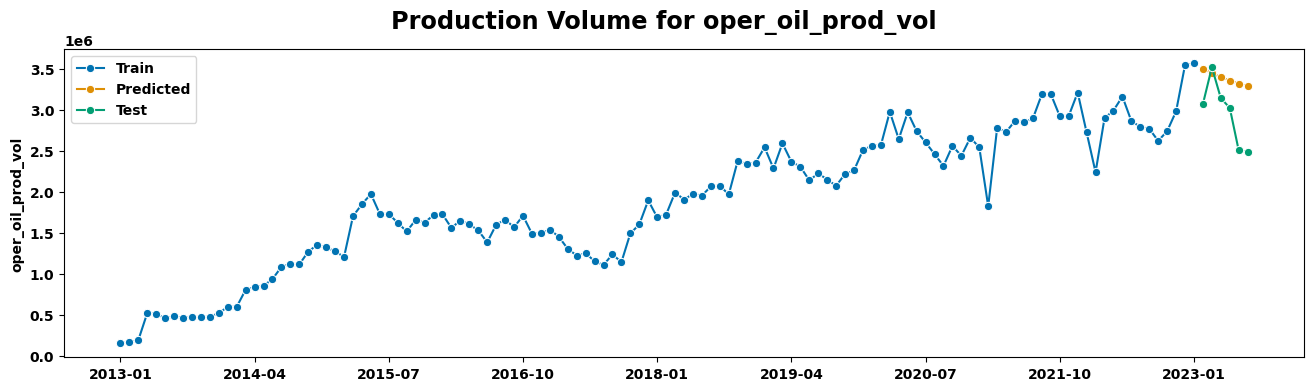

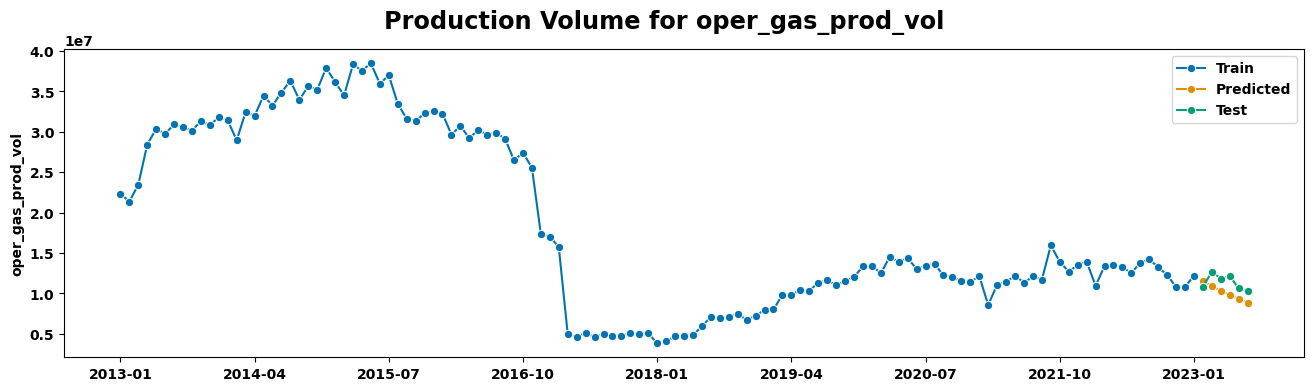

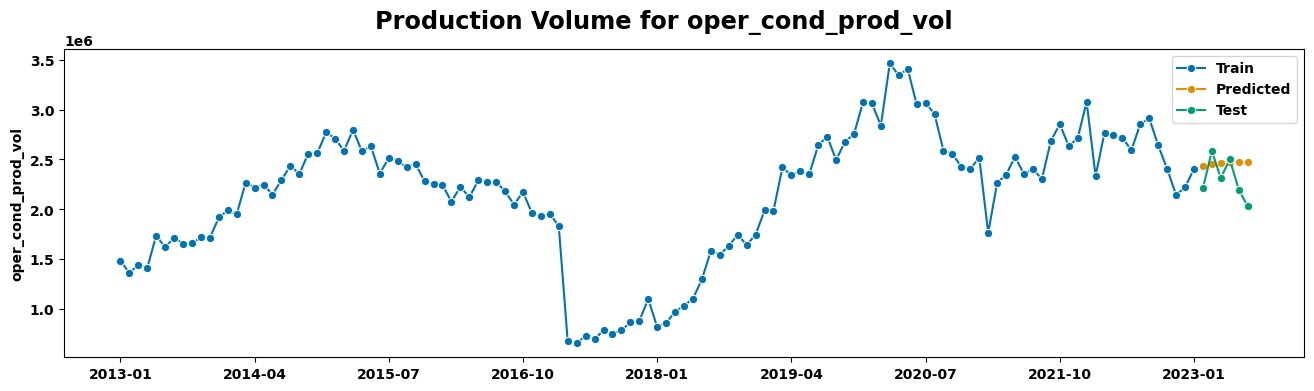

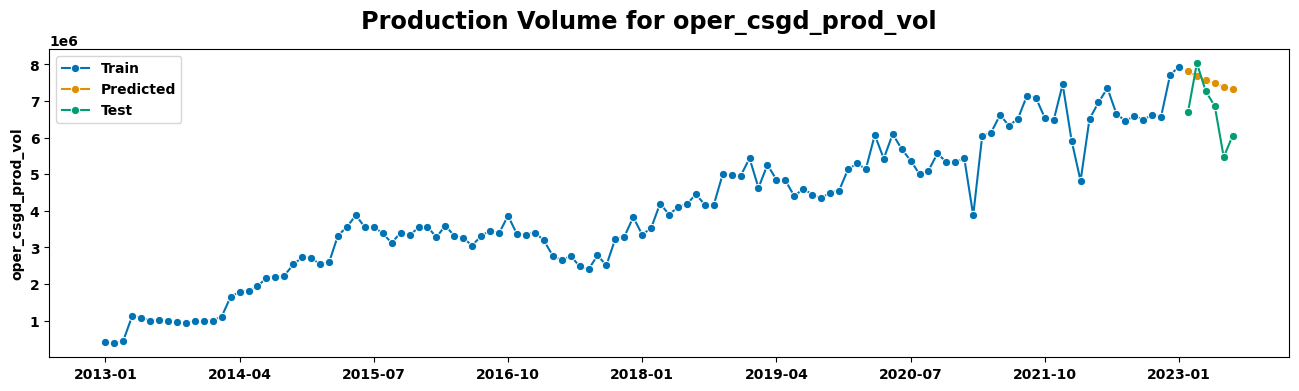

In [61]:
# Plot the train, predicted, and test values
for prod in oper_prod_vol_cols:
    plot_series(
        y_train[prod],
        y_pred_df[prod],
        y_test[prod],
        labels=["Train", "Predicted", "Test"],
        title=f"Production Volume for {prod}",
    )


# overlay = (
#     y_train.hvplot.scatter(
#         x="cycle_year_month", y="oper_oil_prod_vol", logy=True, label="Train"
#     )
#     * y_pred.hvplot.scatter(
#         x="cycle_year_month", y="oper_oil_prod_vol", logy=True, label="Predicted"
#     )
#     * y_test.hvplot.scatter(
#         x="cycle_year_month", y="oper_oil_prod_vol", logy=True, label="Test"
#     )
# )
# overlay.opts(
#     legend_position="bottom_right",
#     width=800,
# )

In [62]:
es_forecaster = ExponentialSmoothing()
param_grid = {
    "sp": [4, 6, 12],
    "seasonal": ["add", "mul"],
    "trend": ["add", "mul"],
    "damped_trend": [True, False],
}


gscv = ForecastingGridSearchCV(
    es_forecaster,
    cv=cv,
    n_jobs=-1,
    param_grid=param_grid,
    scoring=MeanSquaredError(square_root=True),
    verbose=2,
)

gscv.fit(y_train)
# strt off with a blank dataframe os that no data is carried over
y_pred = pd.DataFrame()
y_pred = gscv.predict(fh)

Fitting 104 folds for each of 24 candidates, totalling 2496 fits


b:\project\CapstoneJourney\env\lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
b:\project\CapstoneJourney\env\lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
b:\project\CapstoneJourney\env\lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
b:\project\CapstoneJourney\env\lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
b:\project\CapstoneJourney\env\lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
b:\project\CapstoneJourney\env\lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: Convergen

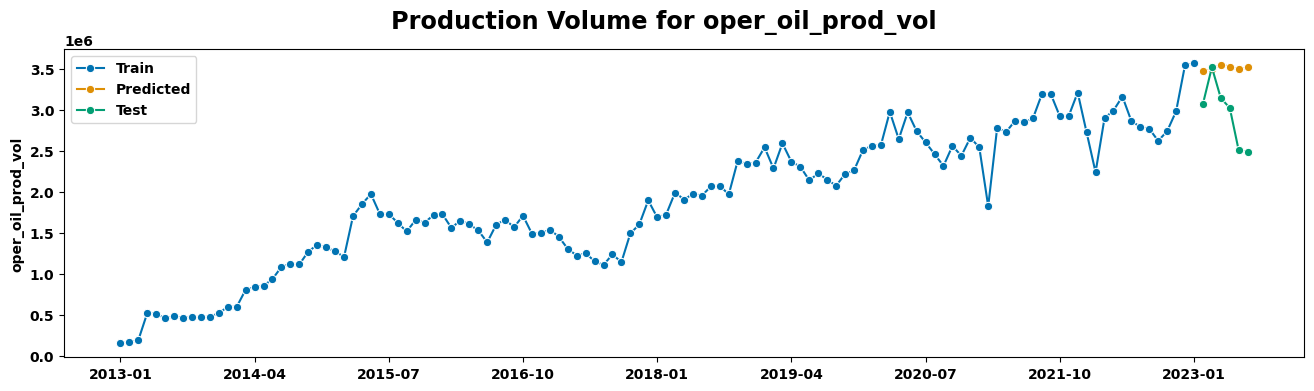

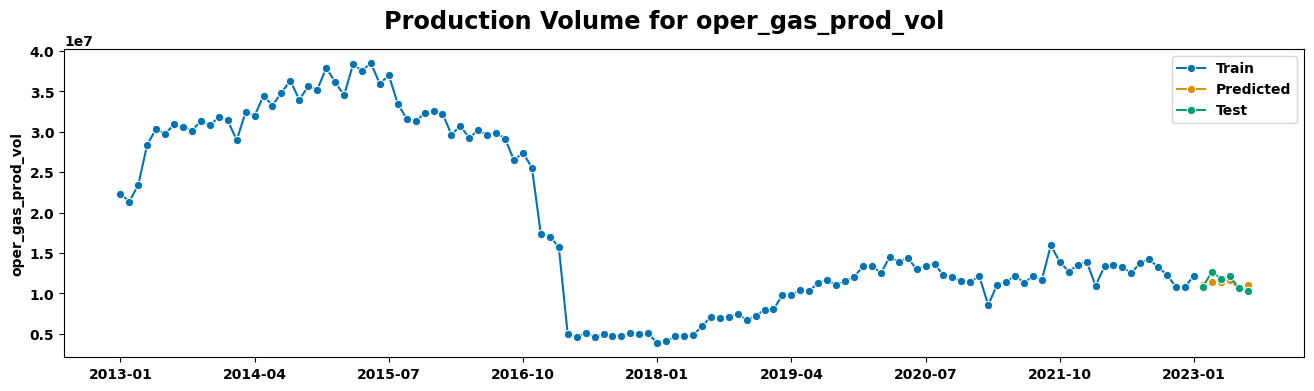

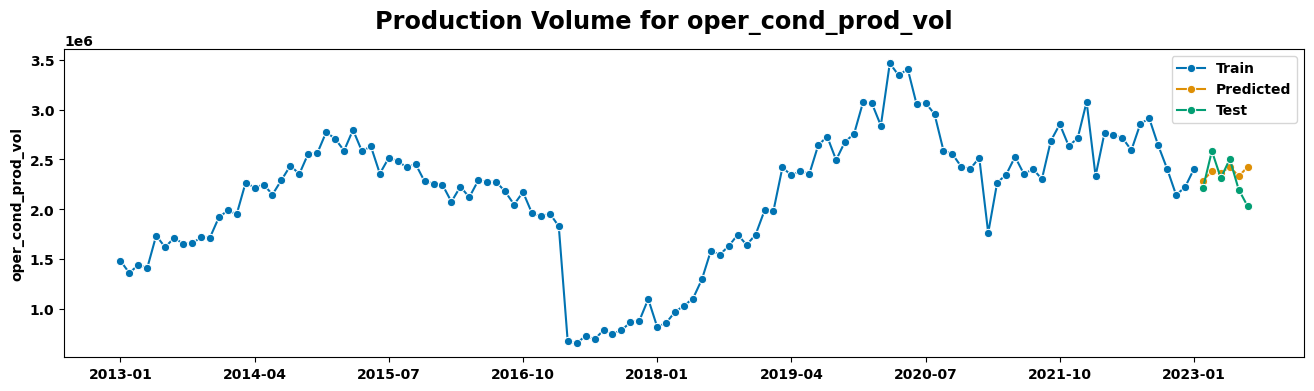

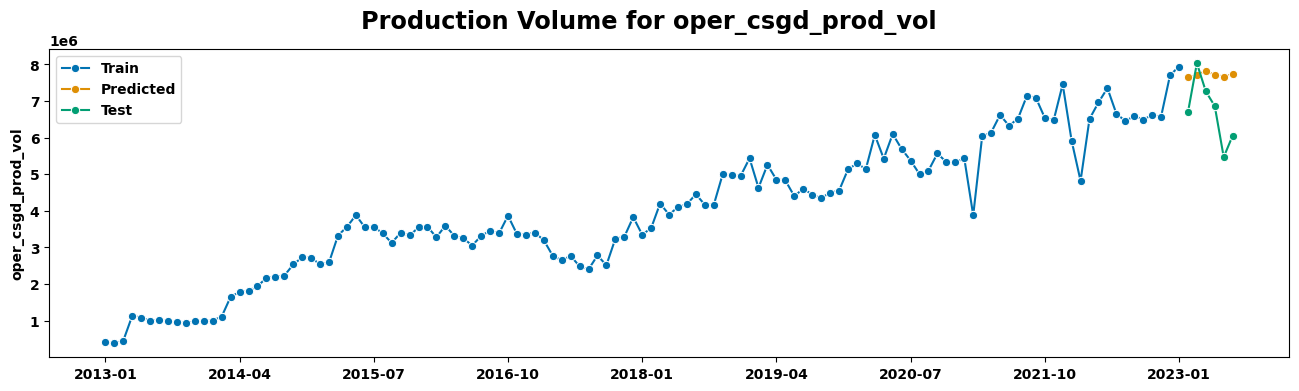

In [63]:
# plot the train, predicted, and test values
for prod in oper_prod_vol_cols:
    plot_series(
        y_train[prod],
        y_pred[prod],
        y_test[prod],
        labels=["Train", "Predicted", "Test"],
        title=f"Production Volume for {prod}",
    )

In [64]:
print(f"Best params: {gscv.best_params_}")
print(f"Best forecaster: {gscv.best_forecaster_}")

Best params: {'damped_trend': True, 'seasonal': 'add', 'sp': 4, 'trend': 'add'}
Best forecaster: ExponentialSmoothing(damped_trend=True, seasonal='add', sp=4, trend='add')


In [ ]:
# plot the forecast and the actuals


In [ ]:
forcaster = MultiplexForecaster(
    forecasters=[
        (
            "naive",
            NaiveForecaster(strategy="last"),
        ),
        ("ets", ExponentialSmoothing(trend="add", sp=12)),
    ],
)
forecaster_param_grid = {"selected_forcaster": ["naive", "ets"]}

In [ ]:
info = client.scheduler_info()  # get scheduler info

workers = info["workers"]  # get the workers

print(f"Number of workers: {len(workers)}")

In [ ]:
client.close()